
# **Investment Replica**

## **Problem Statement**
We consider the following problem:

- There is a **secret portfolio**, a financial **black-box**, which publicly reports its returns on a regular basis (e.g., weekly, monthly, daily).
- We do **not** know either **which instruments** the portfolio contains or **what weight** each instrument has.
- We **do** know the vast investment vehicles available in the markets, such as **bonds, stocks, ETFs, funds, futures contracts**.
- Even if we don't know how the black-box processes input information, we can observe its **output**, i.e., the time series of returns.

Our goal is to **infer the structure of the black-box**, extracting information about latent variables or functions and structural parameters from observed data.

This notebook shows how to reverse-engineer such black-box portfolios by analyzing their return patterns and finding combinations of liquid instruments that can replicate their performance.

---

## **Dataset Description**
This dataset consists of financial data representing:

- **HFRX Index**: A popular index of **Hedge Funds** ([HFRX Index](https://www.hfr.com/indices)) – for those unfamiliar with hedge funds, see [Wikipedia](https://en.wikipedia.org/wiki/Hedge_fund).
- **MSCI World Index**: Global **Developed Equities** ([MSCI World](https://www.msci.com/acwi)).
- **MSCI World All Country Index**: Global **Equities (Developed and Emerging)** ([MSCI ACWI](https://www.msci.com/acwi)).
- **Barclays Bloomberg Global Aggregate Bond Index**: **Global Bonds** (Developed & Emerging, Govt & Corporate) ([Bloomberg](https://www.bloomberg.com/quote/LEGATRUU:IND)).
- **A broad range of Futures contracts** on equity indices, benchmark bonds, currencies, and commodities.

### **Available Futures Contracts**
| Symbol | Instrument |
|--------|------------------|
| RX1    | Bund (10 Yrs Ger) |
| CO1    | Brent (Oil) |
| DU1    | Schatz (2yrs Gvt Ger) |
| ES1    | S&P 500 (US Equity) |
| GC1    | Gold |
| LLL1   | MSCI Emerging Markets (EM Equity) |
| NQ1    | Nasdaq 100 (Tech Equity) |
| TP1    | Topix (Japanese Equity) |
| TU2    | 2Yrs US Treasury (US Govt) |
| TY1    | 10Yrs US Treasury (US Govt) |
| VG1    | Eurostoxx 50 (EU Equity) |

### **Additional Dataset Information**
- **Source**: Bloomberg.
- **Frequency**: Weekly data in local currency.
- **Format**: Original, raw format (but mostly clean).
- **Time Period**: October 2007 – April 2021.

---

## **Who Replicates What?**
To conduct a challenging exercise in **index replication** and explore **financial analytics**, we will attempt to replicate a **"monster index"** that we construct ourselves combining different indexes. This index will include:
- **Tens of thousands** of securities at a micro level.
- A **non-investable** black-box combination of stocks, bonds, and hedge funds.
- A **multi-currency** structure.

To create our **clone**, we will use **Futures contracts (long-short, possibly leveraging them)** because they are:
- **Cheap** ([Cost comparison](https://www.cmegroup.com/trading/equity-index/report-a-cost-comparison-of-futures-and-etfs.html#)).
- **Liquid** and **easy-to-use**.
- **Covering almost everything** ([Futures overview](https://www.marketwatch.com/tools/futures)).

For those new to finance, see: [A Trader’s Guide to Futures](https://www.cmegroup.com/education/files/a-traders-guide-to-futures.pdf).

---

**Alternative Replication Approaches**
Alternatively, you might replicate any linear combination of: HFRX Hedge Fund Index,MSCI World, MSCI ACWI, and Barclays Bloomberg Global Aggregate Bond Index.

This exercise will help us understand **index replication techniques** and gain insights into **financial market structures**.

<br>

As usual, let's start with **data ingestion and preprocessing**.

<br>


In [ ]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization settings
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)

# Mount Google Drive to access files
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Drive already mounted or not in Colab environment.")


Mounted at /content/drive


In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/Final_Project/Group2_Dataset.xlsx'
#file_path = '/content/drive/MyDrive/Fintech/Final_Project/Group2_Dataset.xlsx'

# Read full names and tickers
full_names_df = pd.read_excel(file_path, header=None, skiprows=3, nrows=1)
tickers_df = pd.read_excel(file_path, header=None, skiprows=5, nrows=1)

full_names = full_names_df.iloc[0].tolist()[1:]  # skip date
tickers = tickers_df.iloc[0].tolist()[1:]

# Remove NaNs
valid_indices = [i for i, ticker in enumerate(tickers) if pd.notna(ticker)]
tickers = [tickers[i] for i in valid_indices]
full_names = [full_names[i] for i in valid_indices]

# Map ticker -> name
variable_info = dict(zip(tickers, full_names))

# Upload of true values
data_raw = pd.read_excel(file_path, header=None, skiprows=6)
data_raw = data_raw.iloc[:, :len(tickers) + 1]  # Limita le colonne a quelle valide
data_raw.columns = ['Date'] + tickers

# Dates and indices
data_raw['Date'] = pd.to_datetime(data_raw['Date'])
data = data_raw.set_index('Date')

# Display
print("Dataset preview:")
display(data.head())

print("\nVariable Information (Bloomberg Ticker -> Full Name):")
for ticker, name in variable_info.items():
    print(f"{ticker} -> {name}")

print("\nDataset information:")
display(data.info())

print("\nBasic statistics:")
display(data.describe())


Dataset preview:


MXWO Index  MXWD Index  LEGATRUU Index  HFRXGL Index     RX1  \
Date                                                                       
2007-10-23     1633.44      414.14        350.2138       1343.63  113.70   
2007-10-30     1663.89      423.26        352.5413       1356.53  113.79   
2007-11-06     1651.59      419.51        354.1758       1360.20  113.79   
2007-11-13     1601.81      405.98        357.2217       1347.16  114.35   
2007-11-20     1570.74      398.54        359.4446       1335.21  114.72   

                   TY1    GC1    CO1      ES1     VG1      NQ1    LLL1  \
Date                                                                     
2007-10-23  110.515625  759.0  82.85  1525.50  4393.0  2212.00  1287.0   
2007-10-30  110.656250  787.8  87.44  1536.00  4476.0  2217.75  1323.9   
2007-11-06  110.875000  823.4  93.26  1525.00  4425.0  2233.50  1320.0   
2007-11-13  111.718750  799.0  88.83  1483.25  4323.0  2066.75  1271.0   
2007-11-20  113.156250  791.4  95.49  1446.00  4296.0  2035.50  1225.2   

               TP1      DU1         TU2  
Date                                     
2007-10-23  1570.5  103.385  103.718750  
2007-10-30  1610.5  103.410  103.812500  
2007-11-06  1575.5  103.410  104.046875  
2007-11-13  1440.5  103.595  104.304688  
2007-11-20  1472.5  103.800  104.945312


Variable Information (Bloomberg Ticker -> Full Name):
MXWO Index -> MSCI WORLD
MXWD Index -> MSCI ACWI
LEGATRUU Index -> Global Aggregate
HFRXGL Index -> Hedge Fund Research HFRX Globa
RX1 -> Generic 1st 'RX' Future
TY1 -> Generic 1st 'TY' Future
GC1 -> Generic 1st 'GC' Future
CO1 -> Generic 1st 'CO' Future
ES1 -> Generic 1st 'ES' Future
VG1 -> Generic 1st 'VG' Future
NQ1 -> Generic 1st 'NQ' Future
LLL1 -> Generic 1st 'LLL' Future
TP1 -> Generic 1st 'TP' Future
DU1 -> Generic 1st 'DU' Future
TU2 -> Generic 2nd 'TU' Future

Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 705 entries, 2007-10-23 to 2021-04-20
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MXWO Index      705 non-null    float64
 1   MXWD Index      705 non-null    float64
 2   LEGATRUU Index  705 non-null    float64
 3   HFRXGL Index    705 non-null    float64
 4   RX1             705 non-null    float64
 5   TY1  

None


Basic statistics:


MXWO Index  MXWD Index  LEGATRUU Index  HFRXGL Index         RX1  \
count   705.00000  705.000000      705.000000    705.000000  705.000000   
mean   1644.12566  404.151915      452.203206   1210.092071  147.278837   
std     443.39041  100.980126       47.338067     73.965200   19.318527   
min     705.35000  176.100000      342.247100   1021.400000  110.200000   
25%    1293.43000  328.790000      431.737400   1158.150000  128.900000   
50%    1646.69000  402.570000      456.728800   1215.200000  148.000000   
75%    1978.83000  478.410000      478.186800   1254.250000  163.240000   
max    2944.05000  702.990000      559.311700   1415.110000  179.320000   

              TY1          GC1         CO1          ES1          VG1  \
count  705.000000   705.000000  705.000000   705.000000   705.000000   
mean   125.966977  1317.902837   77.018496  1960.443050  3072.167631   
std      6.295242   274.477979   26.794278   770.070634   473.812729   
min    110.515625   732.700000   19.330000   689.500000  1873.000000   
25%    121.203125  1178.000000   54.270000  1314.500000  2753.000000   
50%    126.000000  1283.000000   72.050000  1909.250000  3071.000000   
75%    130.343750  1499.700000  105.780000  2569.750000  3433.000000   
max    140.328125  2001.200000  140.670000  4132.800000  4476.000000   

                NQ1         LLL1          TP1         DU1         TU2  
count    705.000000   705.000000   705.000000  705.000000  705.000000  
mean    4526.981206  1064.444113  1277.263121  110.221277  108.627682  
std     2900.866833   128.954655   353.598276    2.374875    1.532632  
min     1072.000000   465.100000   704.000000  102.190000  103.718750  
25%     2244.000000  1103.600000   905.000000  109.230000  107.871094  
50%     3884.750000  1103.600000  1302.500000  110.855000  109.093750  
75%     6333.250000  1103.600000  1587.500000  111.990000  109.906250  
max    13975.750000  1323.900000  1978.000000  112.720000  110.527344


# **Data Exploration**

Let's analyze the potential replication targets to understand their characteristics.



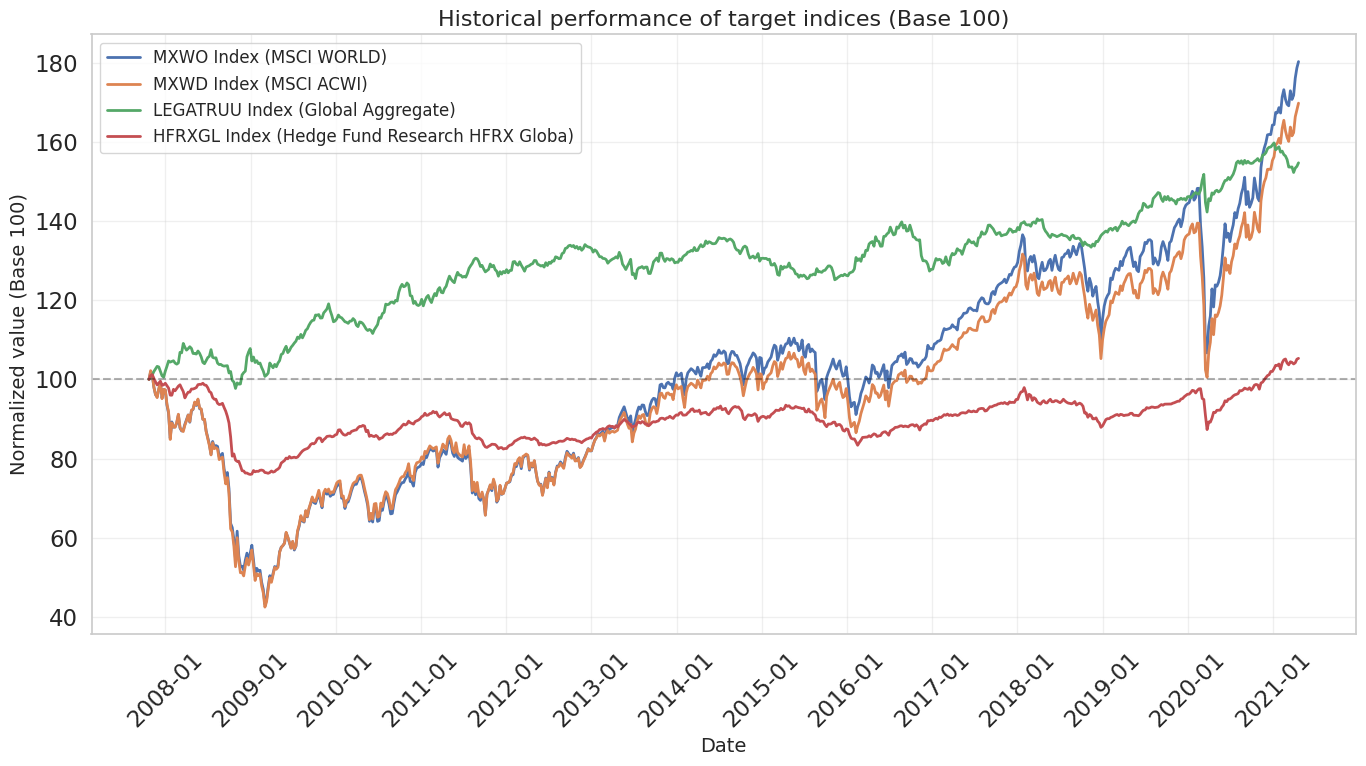


Return statistics for target indices:


Annualized Return Annualized Volatility  Sharpe Ratio  \
MXWO Index                 5.90%                17.52%      0.336955   
MXWD Index                 5.51%                17.78%      0.309683   
LEGATRUU Index             3.37%                 5.34%      0.630472   
HFRXGL Index               0.50%                 4.78%      0.104156   

               Max Drawdown  Skewness   Kurtosis  
MXWO Index          -57.61% -0.682289   4.357034  
MXWD Index          -58.39% -0.641270   4.663275  
LEGATRUU Index      -10.41% -0.329675   4.118169  
HFRXGL Index        -24.91% -2.301318  13.702270

In [ ]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Target indices to explore
target_indices = ['MXWO Index', 'MXWD Index', 'LEGATRUU Index', 'HFRXGL Index']

# Create a figure for the historical price series
plt.figure(figsize=(14, 8))

# Plot each index
for idx in target_indices:
    # Normalize to 100 at the beginning for comparison
    normalized_series = data[idx] / data[idx].iloc[0] * 100
    plt.plot(normalized_series.index, normalized_series, linewidth=2, label=f"{idx} ({variable_info.get(idx, idx)})")

# Format the plot
plt.title('Historical performance of target indices (Base 100)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Normalized value (Base 100)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)

# Format the x-axis to show dates nicely
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

# Add a horizontal line at y=100
plt.axhline(y=100, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display statistics for all indices
print("\nReturn statistics for target indices:")
# Calculate returns
returns = data[target_indices].pct_change().dropna()

# Calculate annualized statistics
annual_factor = 52  # For weekly data (52 weeks = 1 year)

# Format as percentage with 2 decimal places
def format_pct(x):
    return f"{x*100:.2f}%"

stats = pd.DataFrame({
    'Annualized Return': returns.mean() * annual_factor,
    'Annualized Volatility': returns.std() * np.sqrt(annual_factor),
    'Sharpe Ratio': (returns.mean() * annual_factor) / (returns.std() * np.sqrt(annual_factor)),
    'Max Drawdown': returns.apply(lambda x: (1 + x).cumprod().div((1 + x).cumprod().cummax()) - 1).min(),
    'Skewness': returns.skew(),
    'Kurtosis': returns.kurtosis()
})

# Convert some columns to percentage format for better readability
for col in ['Annualized Return', 'Annualized Volatility', 'Max Drawdown']:
    stats[col] = stats[col].apply(format_pct)

display(stats)


### Correlation & probability distribution analysis
Understanding the shape and the relationships between different indices helps us understanding the behavior of our ingredients and identify potential replication components.

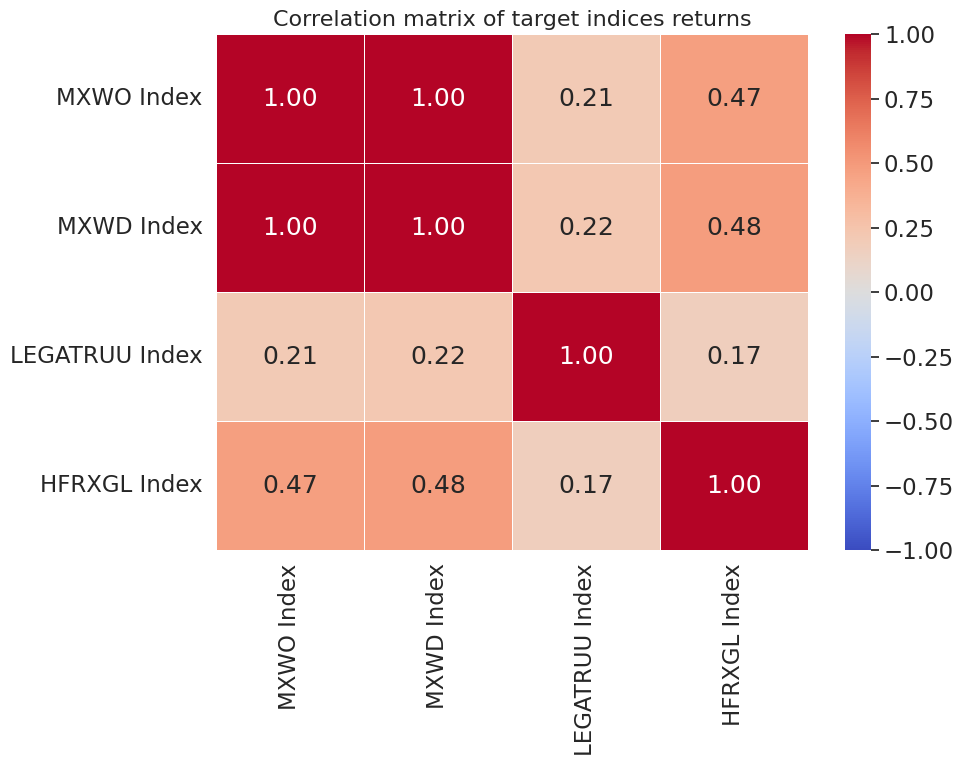

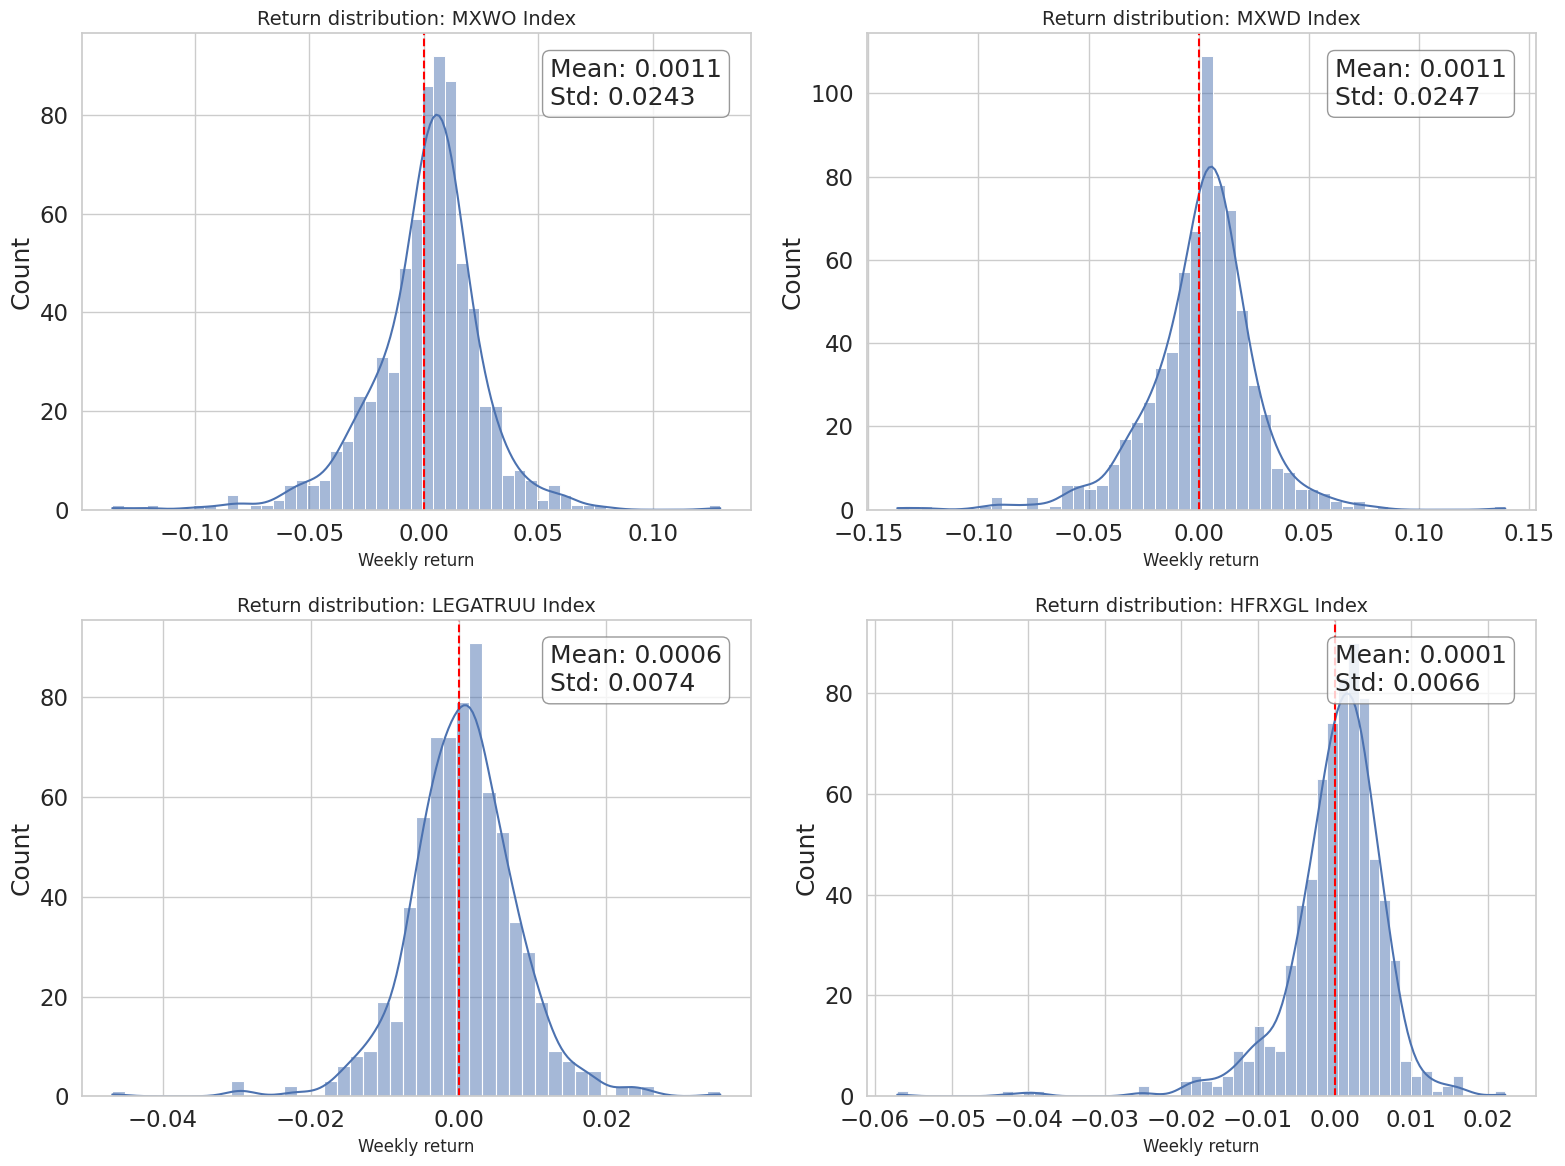

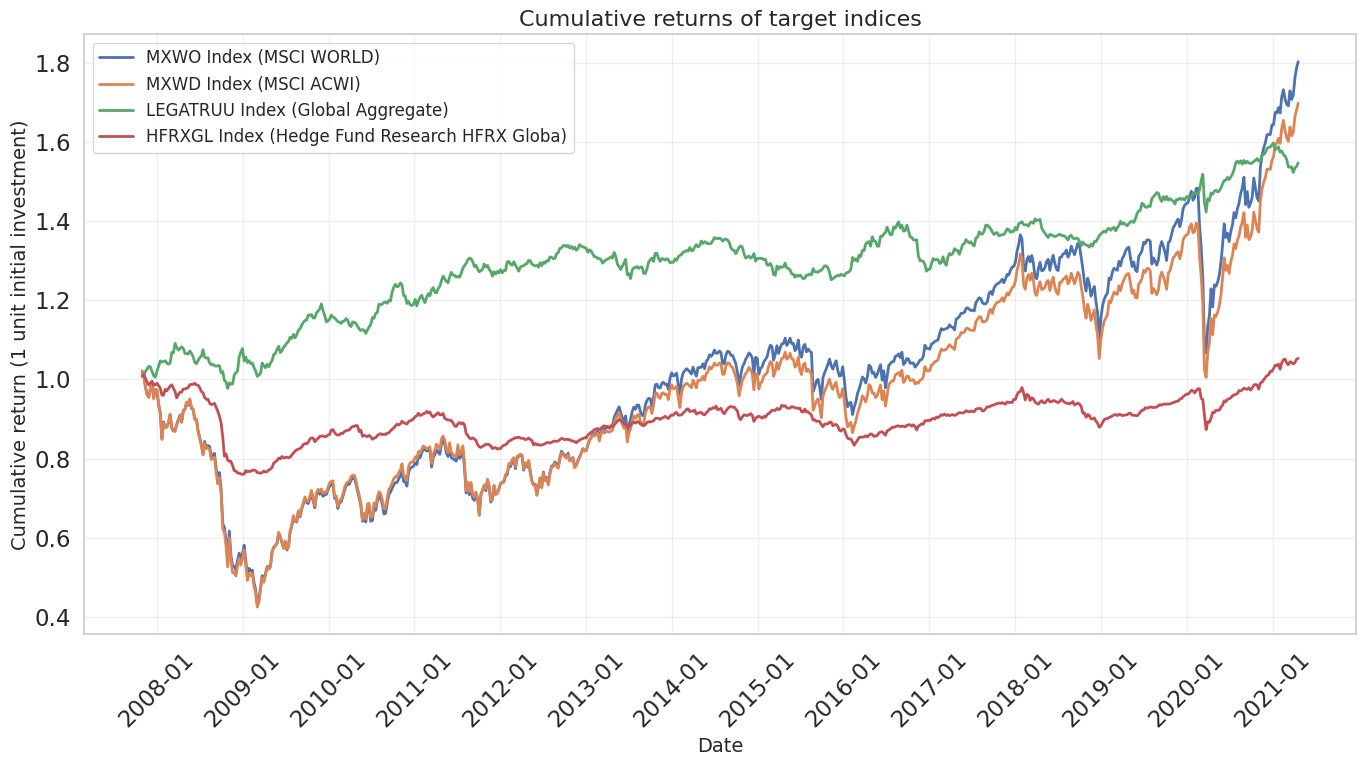

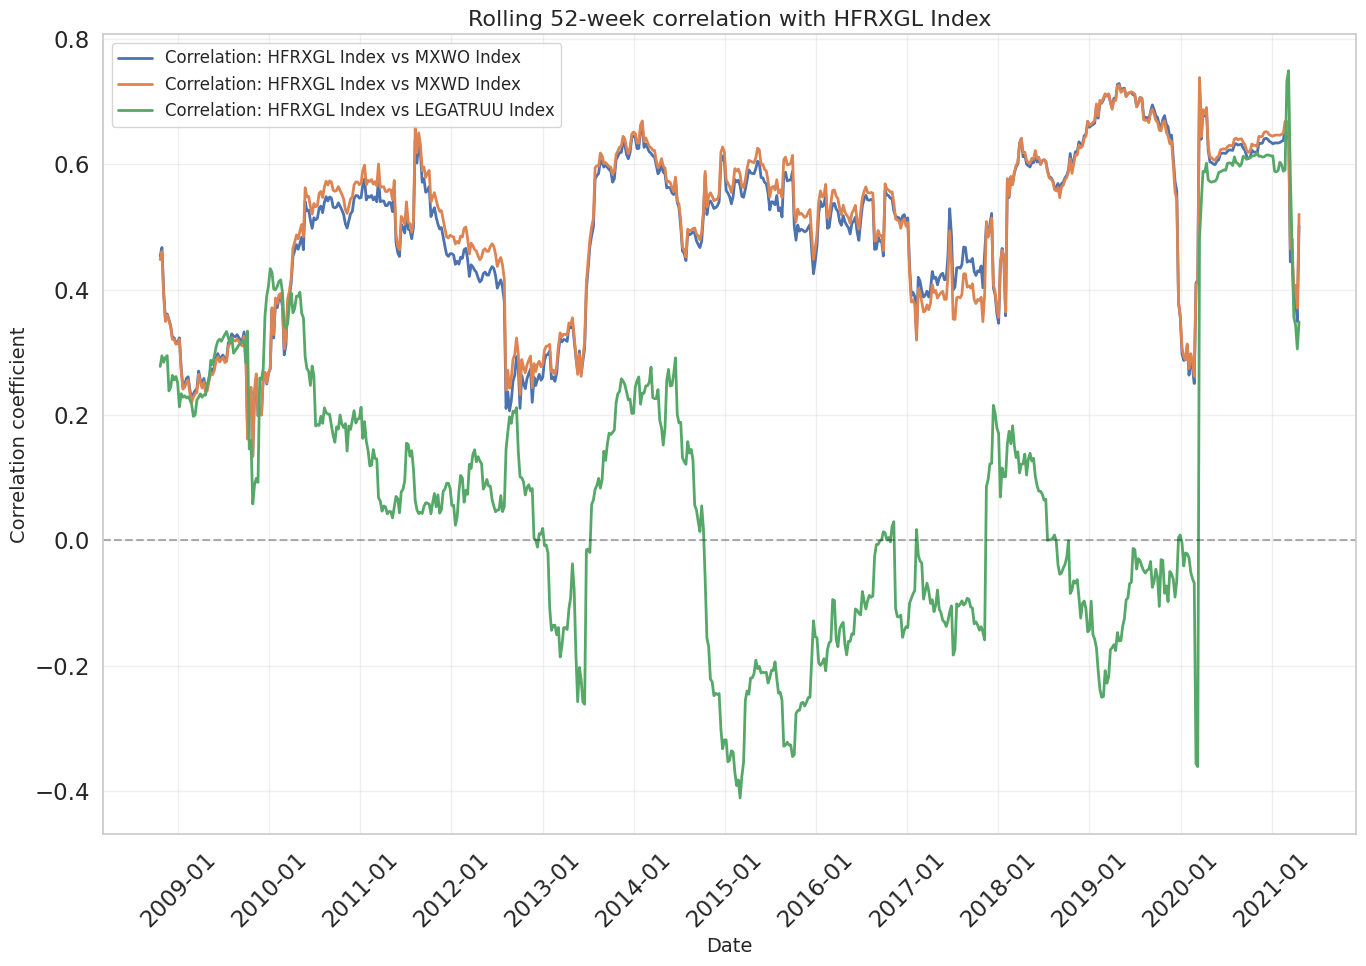

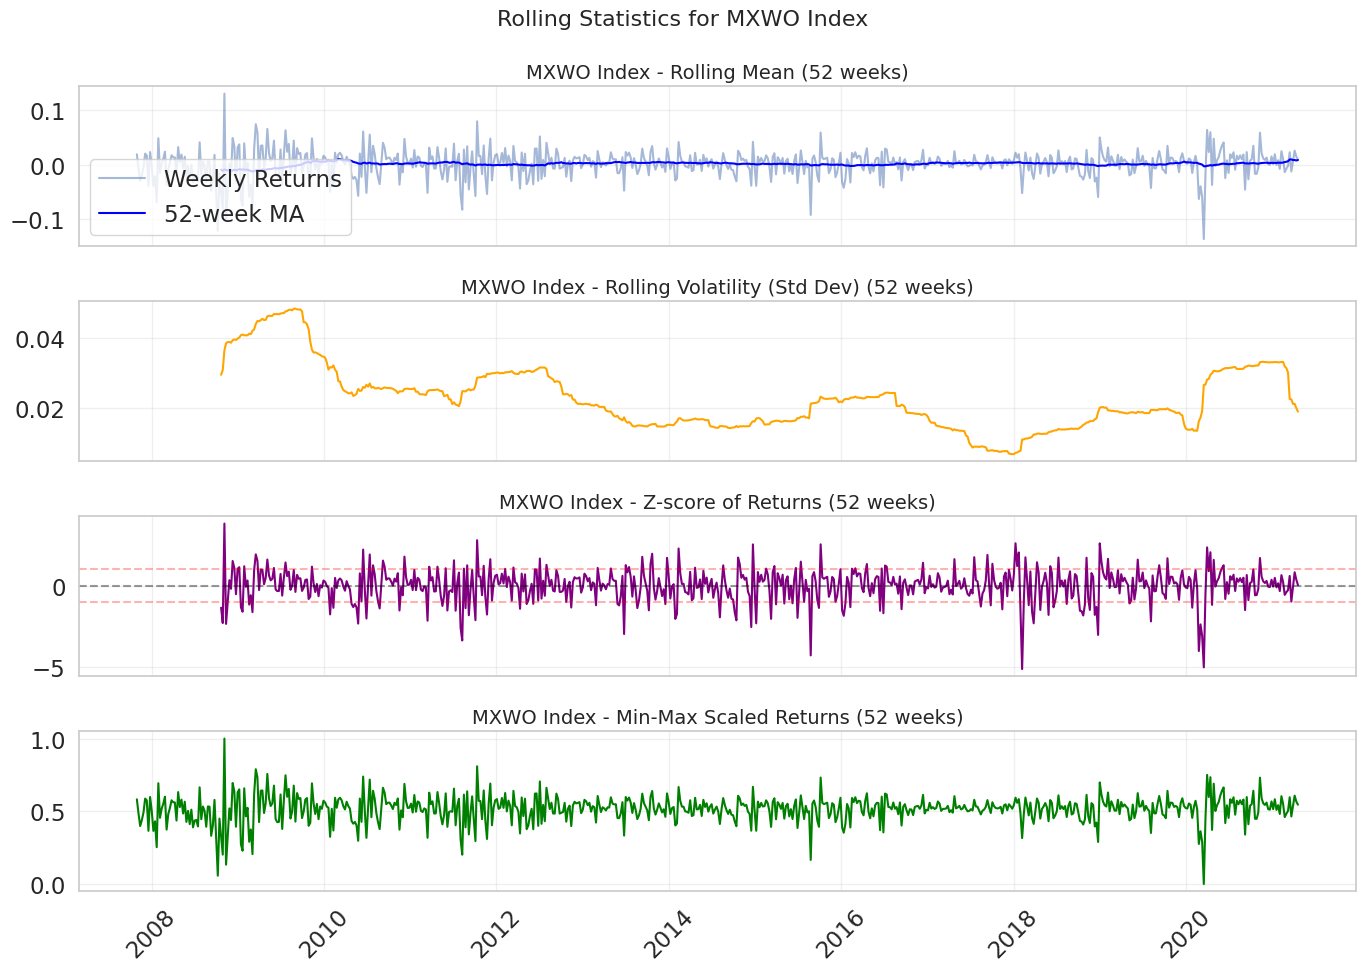

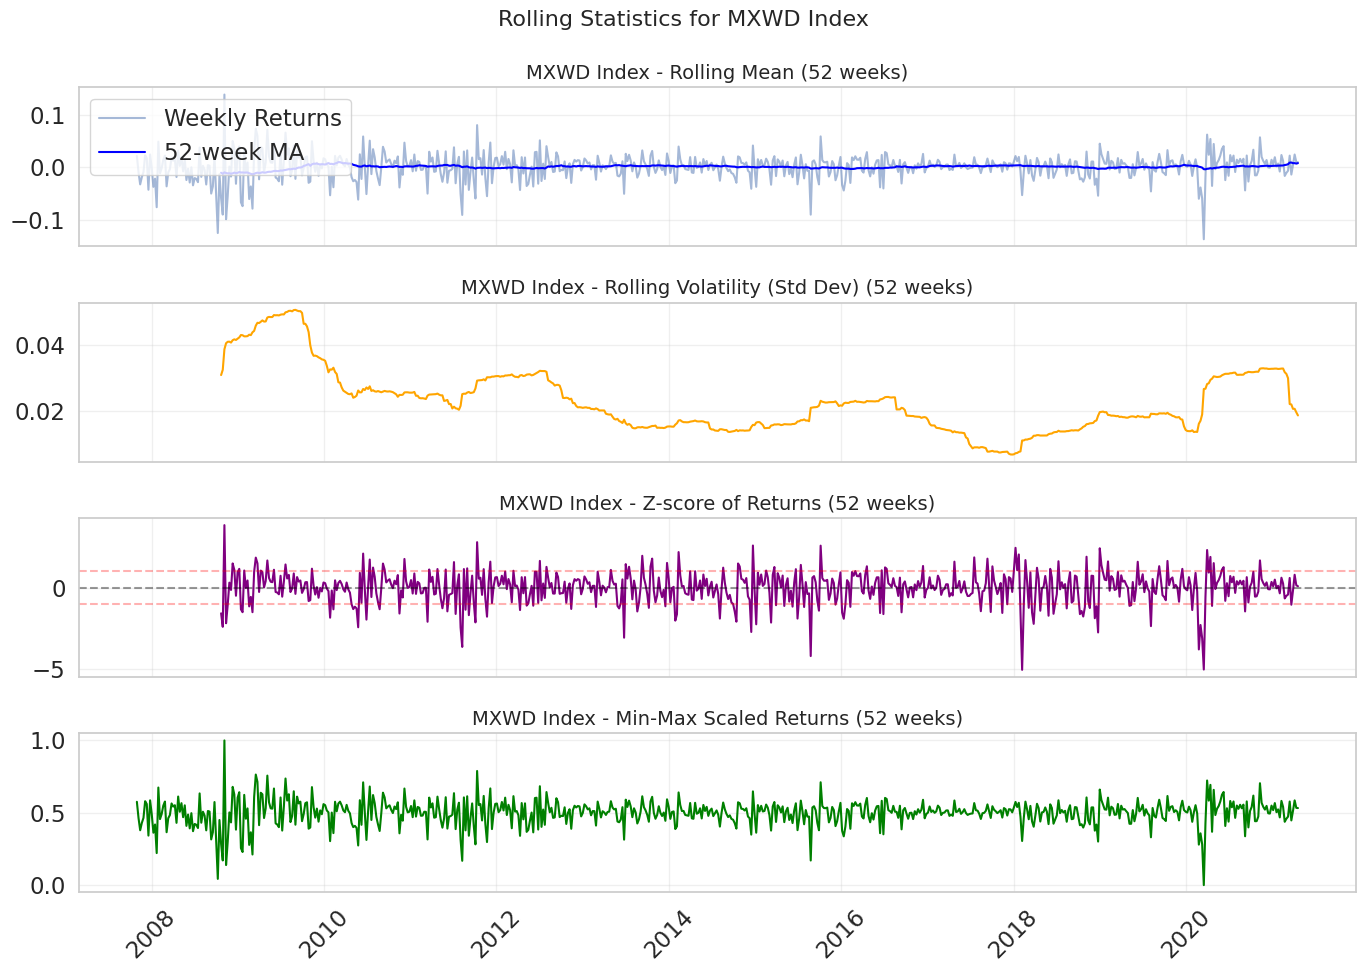

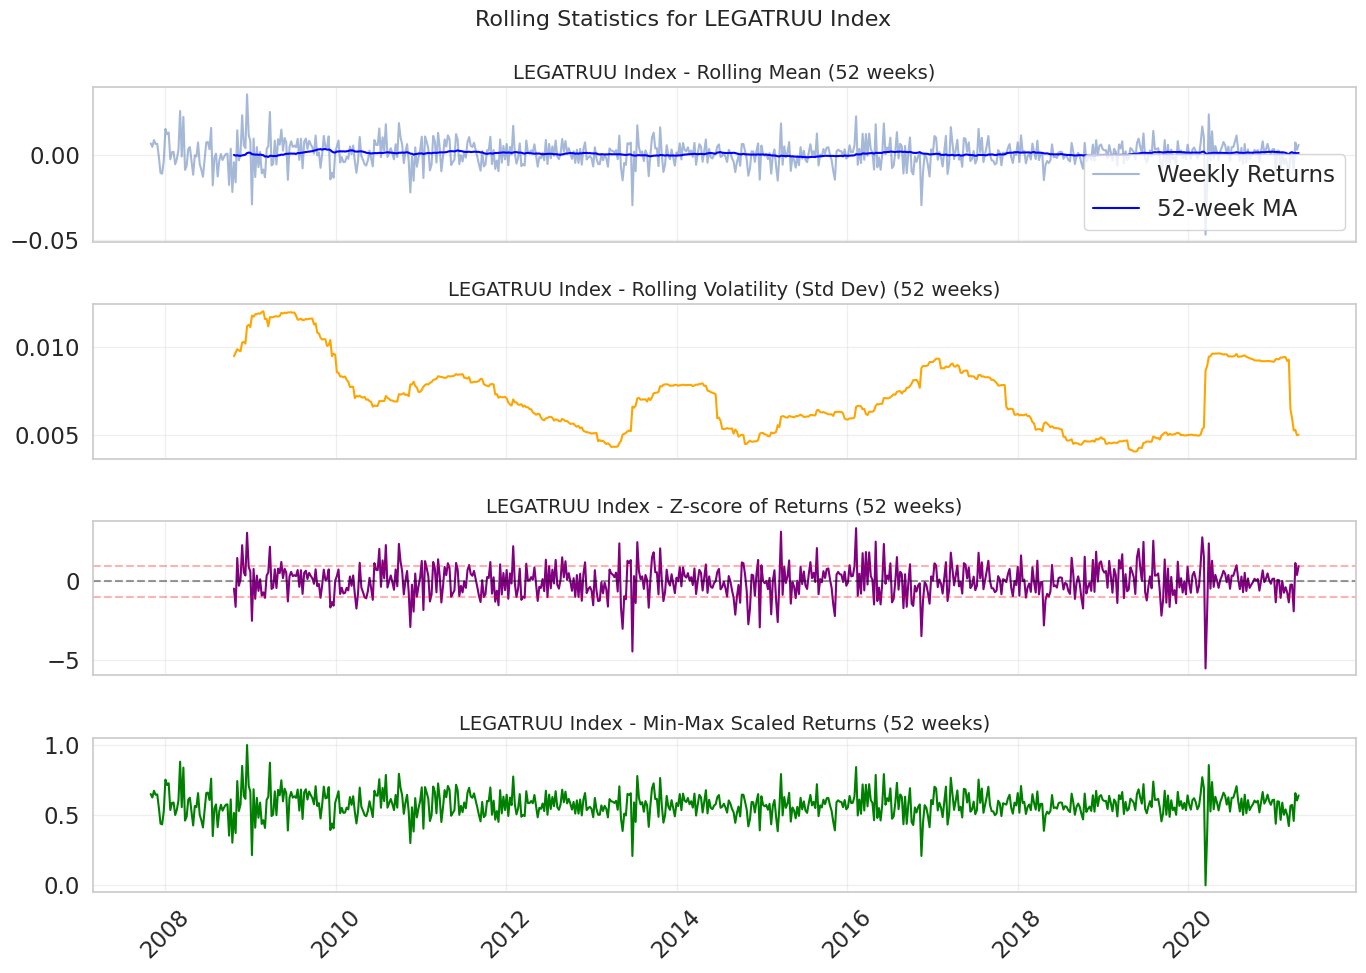

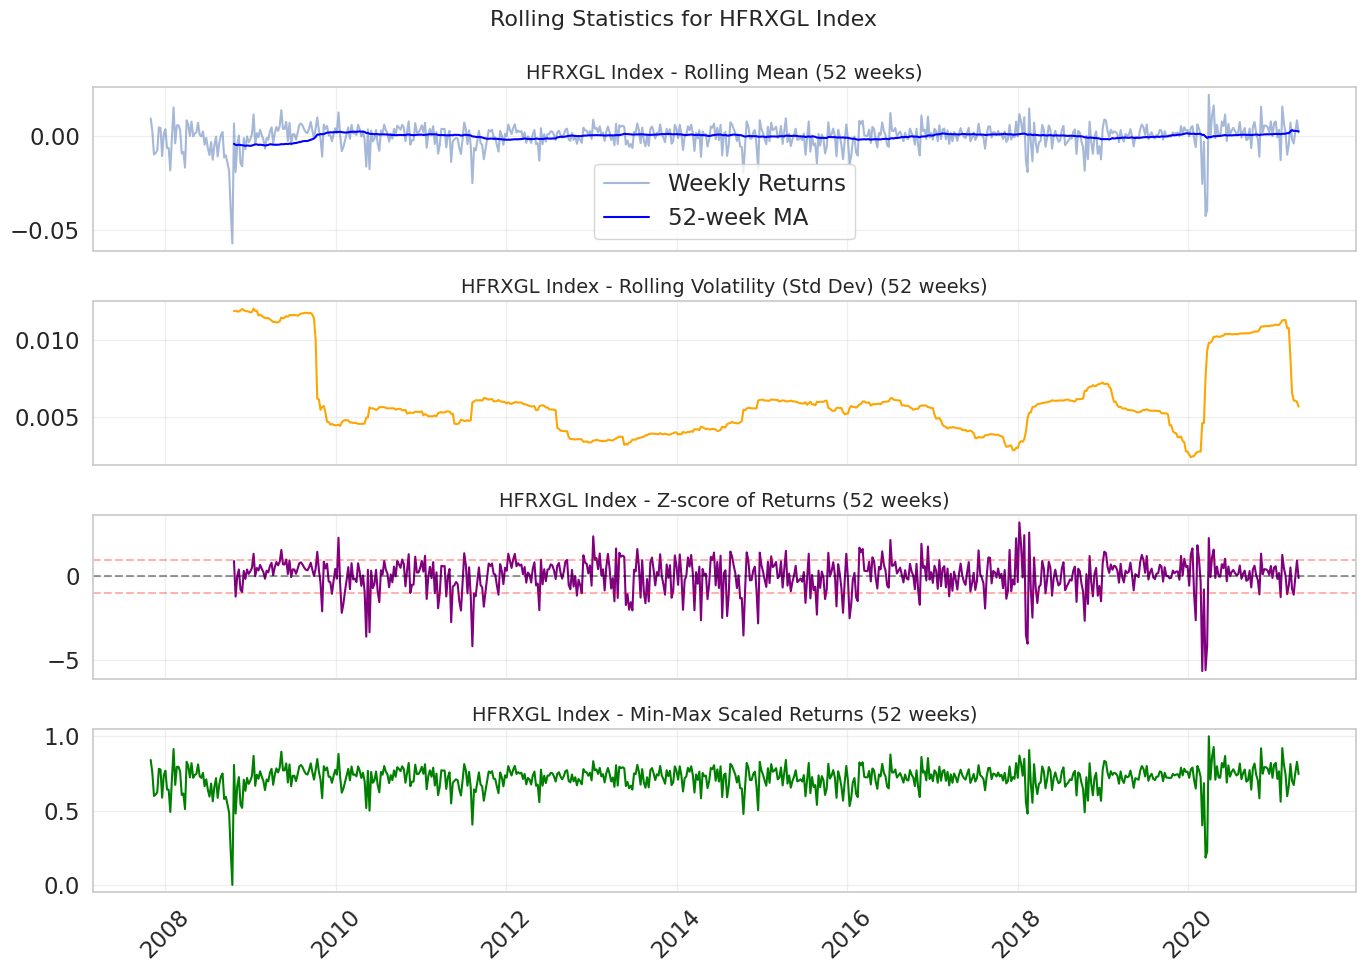

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create a correlation heatmap for the target indices
plt.figure(figsize=(10, 8))
correlation_matrix = returns[target_indices].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
            linewidths=0.5, fmt='.2f')
plt.title('Correlation matrix of target indices returns', fontsize=16)
plt.tight_layout()
plt.show()

# Plot returns distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, idx in enumerate(target_indices):
    sns.histplot(returns[idx], kde=True, ax=axes[i])
    axes[i].set_title(f'Return distribution: {idx}', fontsize=14)
    axes[i].set_xlabel('Weekly return', fontsize=12)
    axes[i].axvline(x=0, color='red', linestyle='--')
    # Add mean and std annotations
    mean = returns[idx].mean()
    std = returns[idx].std()
    axes[i].annotate(f'Mean: {mean:.4f}\nStd: {std:.4f}',
                     xy=(0.7, 0.85), xycoords='axes fraction',
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# Compute cumulative returns for visualization
cumulative_returns = (1 + returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 8))
for idx in target_indices:
    plt.plot(cumulative_returns.index, cumulative_returns[idx], linewidth=2,
             label=f"{idx} ({variable_info.get(idx, idx)})")

plt.title('Cumulative returns of target indices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative return (1 unit initial investment)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot rolling correlations over time (12-month window)
rolling_window = 52  # 52 weeks ≈ 1 year
plt.figure(figsize=(14, 10))

# Base correlation against HFRXGL (Hedge Fund Index)
base_idx = 'HFRXGL Index'
for idx in [i for i in target_indices if i != base_idx]:
    roll_corr = returns[[base_idx, idx]].rolling(rolling_window).corr().unstack()[base_idx][idx]
    plt.plot(roll_corr.index, roll_corr, linewidth=2,
             label=f"Correlation: {base_idx} vs {idx}")

plt.title(f'Rolling {rolling_window}-week correlation with {base_idx}', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Correlation coefficient', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Rolling statistics (mean, std, z-score) for each target index
rolling_window = 52  # 52 weeks ≈ 1 year
scaler = MinMaxScaler()

for idx in target_indices:
    series = returns[idx].dropna()
    rolling_mean = series.rolling(rolling_window).mean()
    rolling_std = series.rolling(rolling_window).std()
    z_score = (series - rolling_mean) / rolling_std

    min_max_scaled = pd.Series(scaler.fit_transform(series.values.reshape(-1, 1)).flatten(), index=series.index)

    fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

    # Rolling mean
    axes[0].plot(series.index, series, label='Weekly Returns', alpha=0.5)
    axes[0].plot(rolling_mean.index, rolling_mean, color='blue', label=f'{rolling_window}-week MA')
    axes[0].set_title(f'{idx} - Rolling Mean ({rolling_window} weeks)', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Rolling std
    axes[1].plot(rolling_std.index, rolling_std, color='orange')
    axes[1].set_title(f'{idx} - Rolling Volatility (Std Dev) ({rolling_window} weeks)', fontsize=14)
    axes[1].grid(True, alpha=0.3)

    # Z-score
    axes[2].plot(z_score.index, z_score, color='purple')
    axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.4)
    axes[2].axhline(y=1, color='red', linestyle='--', alpha=0.3)
    axes[2].axhline(y=-1, color='red', linestyle='--', alpha=0.3)
    axes[2].set_title(f'{idx} - Z-score of Returns ({rolling_window} weeks)', fontsize=14)
    axes[2].grid(True, alpha=0.3)

    # Min-Max Scaling
    axes[3].plot(min_max_scaled.index, min_max_scaled, color='green')
    axes[3].set_title(f'{idx} - Min-Max Scaled Returns ({rolling_window} weeks)', fontsize=14)
    axes[3].grid(True, alpha=0.3)


    plt.suptitle(f'Rolling Statistics for {idx}', fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


<br>

Let's examine the statistical properties of our target indices.


Futures kept: ['RX1', 'TY1', 'GC1', 'CO1', 'ES1', 'VG1', 'NQ1', 'TP1', 'DU1', 'TU2']


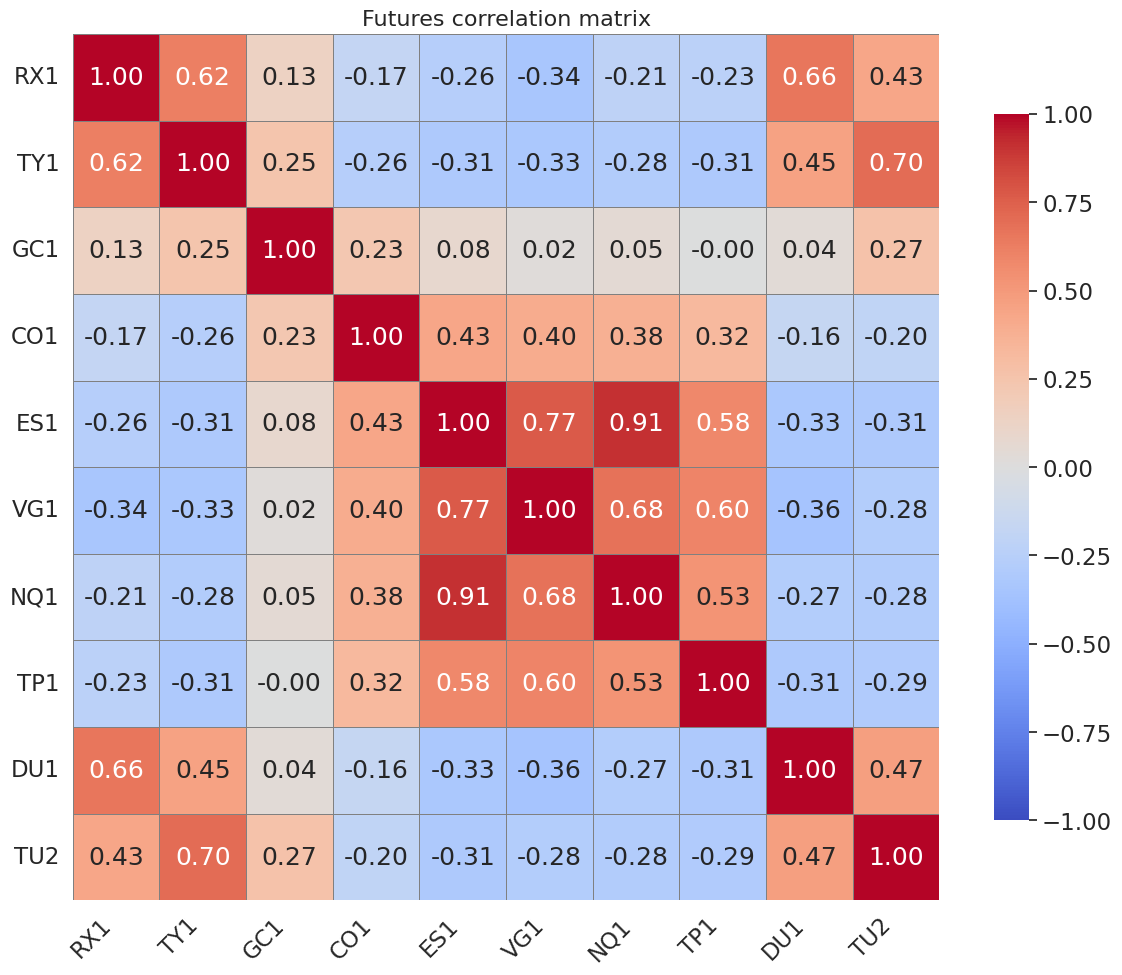

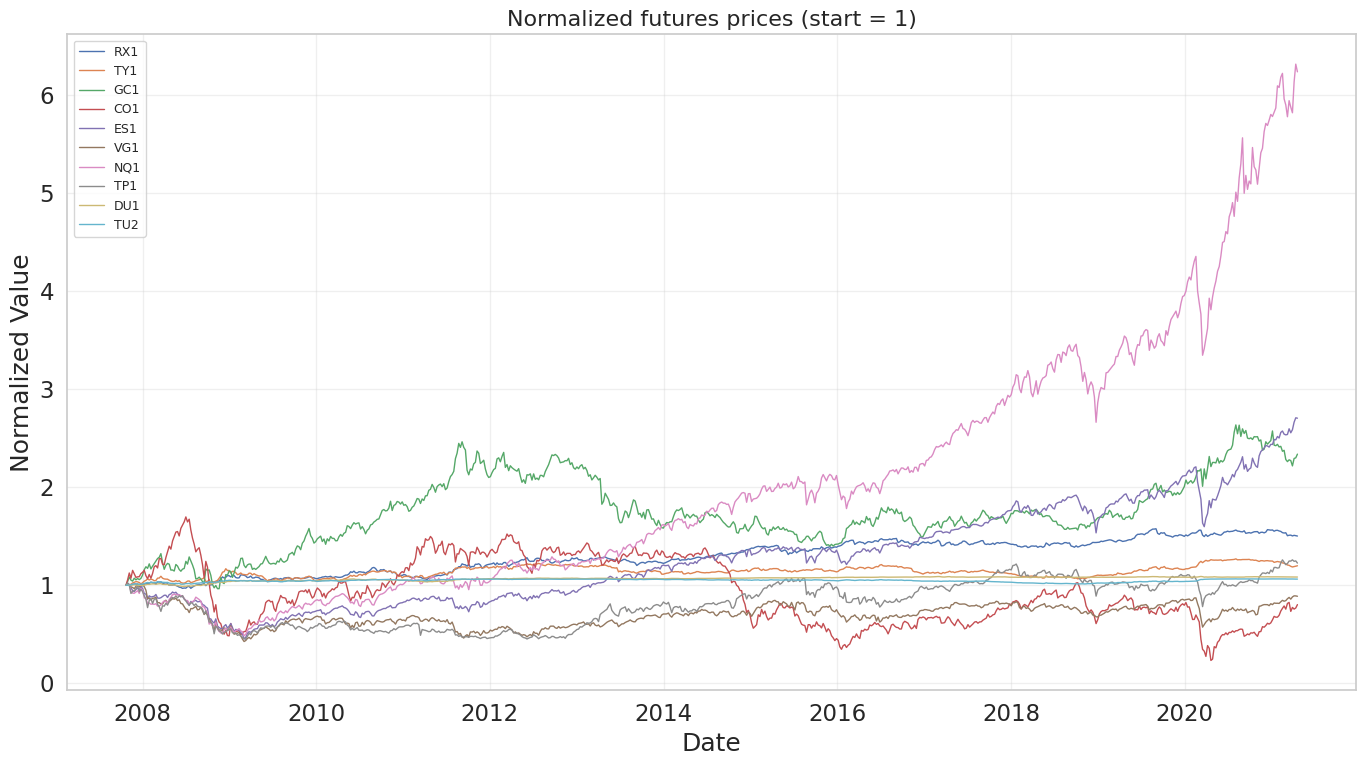


Correlation with monster index:
    Correlation with target index
ES1                      0.914492
NQ1                      0.819812
VG1                       0.81773
TP1                      0.645042
CO1                      0.468406
DU1                     -0.325807
RX1                     -0.219606
GC1                      0.211299
TY1                     -0.202715
TU2                     -0.202328

Shapiro-Wilk Normality Test Results:

Target Index: W=0.9341, p-value=4.506e-17 -> Not normal
ES1: W=0.9259, p-value=3.916e-18 -> Not normal
NQ1: W=0.9492, p-value=7.788e-15 -> Not normal
VG1: W=0.9586, p-value=3.435e-13 -> Not normal


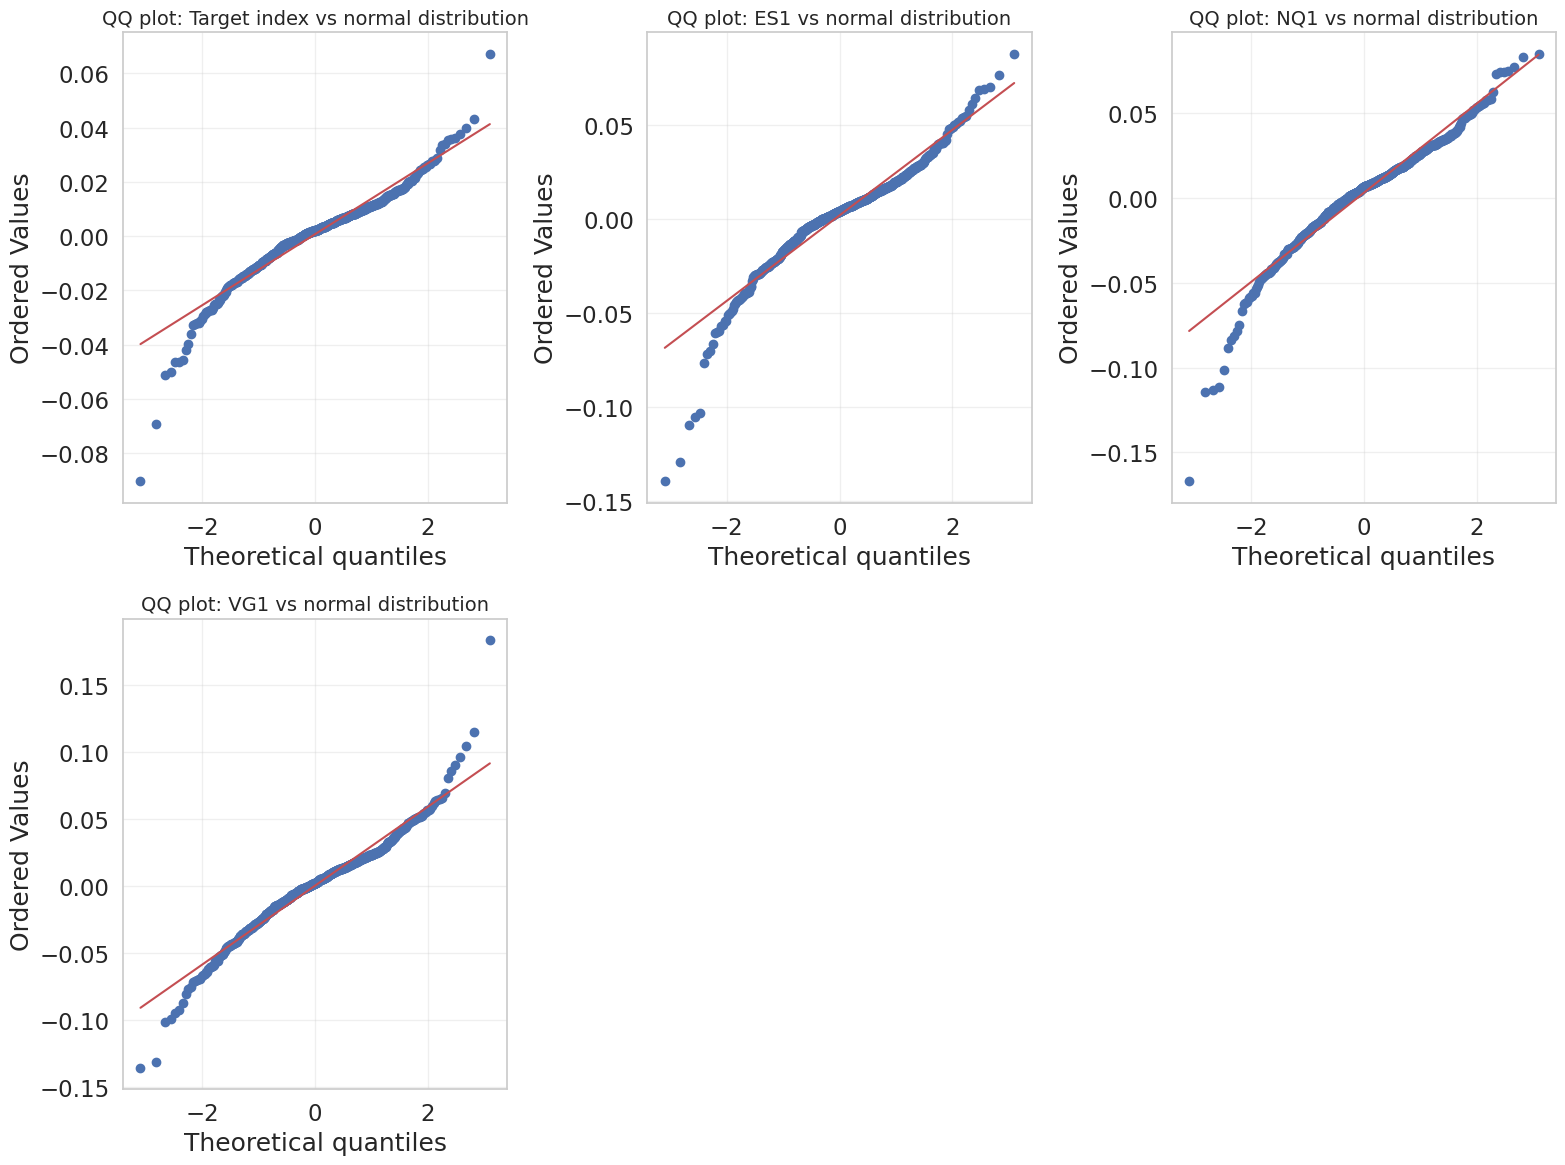

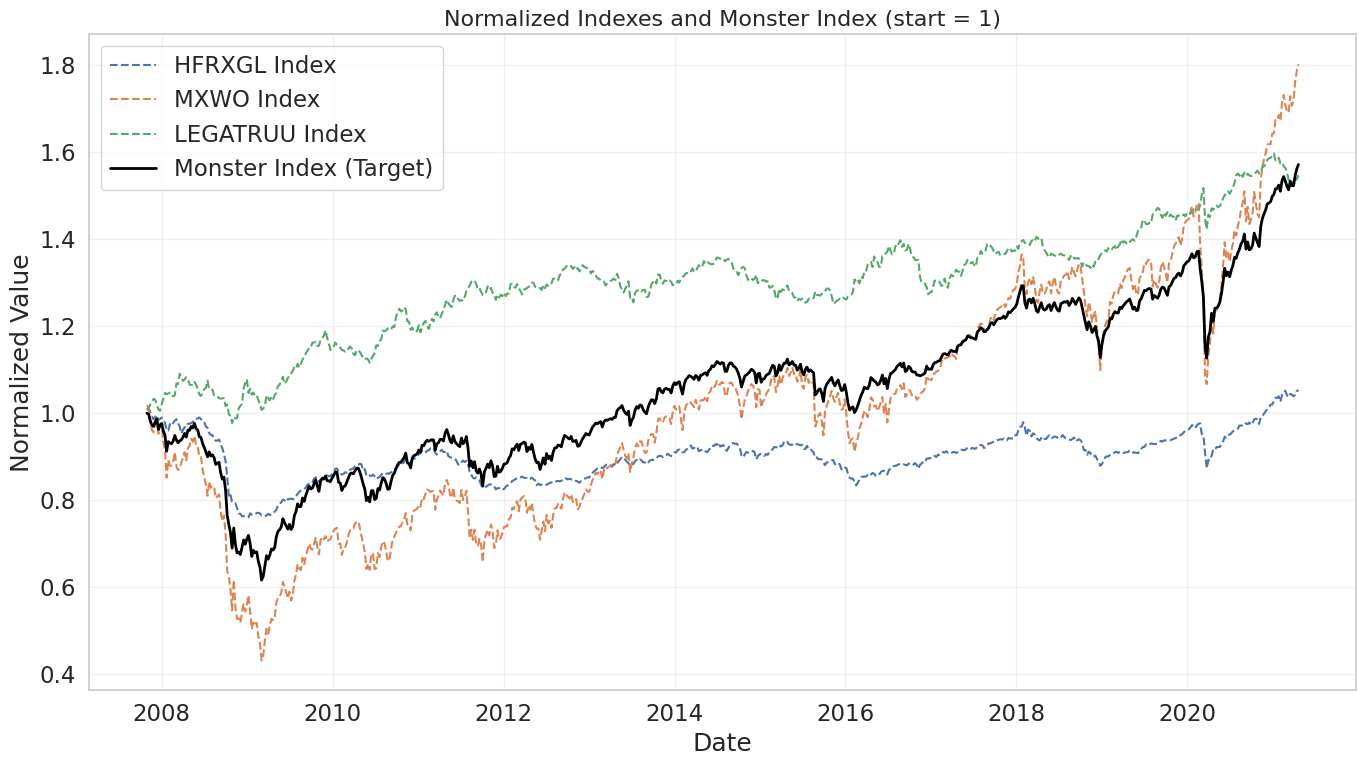

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Suppress specific warnings about invalid divisions
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")

# ======================
# FUTURES CORRELATION ANALYSIS
# ======================

# Initial definition of futures contracts
futures_contracts = [
    'RX1', 'TY1', 'GC1', 'CO1',
    'ES1', 'VG1', 'NQ1', 'LLL1',
    'TP1', 'DU1', 'TU2'
]

# Remove futures that have not been traded (constant prices) in the last 2 years
two_years_ago = data.index.max() - pd.DateOffset(years=2)
recent_data = data.loc[data.index >= two_years_ago, futures_contracts]
futures_contracts = [f for f in futures_contracts if recent_data[f].nunique() > 1]

print("Futures kept:", futures_contracts)

# Compute daily returns for futures
futures_returns_raw = data[futures_contracts].pct_change().dropna()

# Compute correlation matrix
corr_matrix = futures_returns_raw.corr()

# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True,
            linewidths=0.5, linecolor='gray', cbar_kws={"shrink": 0.8})
plt.title('Futures correlation matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot normalized price series (start = 1)
normalized_prices = (data[futures_contracts] / data[futures_contracts].iloc[0])

plt.figure(figsize=(14, 8))
for contract in futures_contracts:
    plt.plot(normalized_prices[contract], label=contract, linewidth=1)

plt.title('Normalized futures prices (start = 1)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend(loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ======================
# MONSTER INDEX CREATION
# ======================

index_components = {
    'HFRXGL Index': 1/4,
    'MXWO Index': 1/2,
    'LEGATRUU Index': 1/4
    }

# Compute returns of the index components
component_returns = data[list(index_components.keys())].pct_change().dropna()

# Compute weighted sum of component returns
weighted_returns = pd.DataFrame(index=component_returns.index)
for component, weight in index_components.items():
    weighted_returns[component] = component_returns[component] * weight

# Aggregate into the target index
target_returns = weighted_returns.sum(axis=1)
target_returns.name = 'Target_Index'

# ======================
# TARGET VS FUTURES CORRELATION
# ======================

# Compute aligned returns
futures_returns = data[futures_contracts].pct_change().dropna()
common_dates = futures_returns.index.intersection(target_returns.index)
futures_returns = futures_returns.loc[common_dates]
target_returns_aligned = target_returns.loc[common_dates]

# Correlation computation
correlations = pd.DataFrame(index=futures_contracts,
                            columns=['Correlation with target index'])

for contract in futures_contracts:
    correlations.loc[contract] = target_returns_aligned.corr(futures_returns[contract])

# Sort by absolute correlation
correlations['Abs correlation'] = correlations['Correlation with target index'].abs()
correlations = correlations.sort_values('Abs correlation', ascending=False)
correlations = correlations.drop('Abs correlation', axis=1)

print("\nCorrelation with monster index:")
print(correlations)

# ======================
# QQ PLOTS
# ======================

plt.figure(figsize=(16, 12))

# QQ Plot for target
plt.subplot(2, 3, 1)
stats.probplot(target_returns_aligned.dropna(), dist="norm", plot=plt)
plt.title('QQ plot: Target index vs normal distribution', fontsize=14)
plt.grid(True, alpha=0.3)

# Top 3 correlated futures
top_futures = correlations.index[:3].tolist()

for i, contract in enumerate(top_futures):
    plt.subplot(2, 3, i + 2)
    returns_data = futures_returns[contract].dropna()
    stats.probplot(returns_data, dist="norm", plot=plt)
    plt.title(f'QQ plot: {contract} vs normal distribution', fontsize=14)
    plt.grid(True, alpha=0.3)

# Shapiro-Wilk test for normality
print("\nShapiro-Wilk Normality Test Results:\n")
shapiro_stat, shapiro_p = stats.shapiro(target_returns_aligned.dropna())
print(f"Target Index: W={shapiro_stat:.4f}, p-value={shapiro_p:.3e} -> {'Not normal' if shapiro_p < 0.05 else 'Normal'}")

for contract in top_futures:
    shapiro_stat, shapiro_p = stats.shapiro(futures_returns[contract].dropna())
    print(f"{contract}: W={shapiro_stat:.4f}, p-value={shapiro_p:.3e} -> {'Not normal' if shapiro_p < 0.05 else 'Normal'}")

plt.tight_layout()
plt.show()

# ======================
# PLOT MONSTER INDEX + COMPONENTS
# ======================

# Normalize all components for visualization (start = 1)
normalized = pd.DataFrame(index=data.index)
for idx in index_components:
    normalized[idx] = data[idx] / data[idx].iloc[0]

# Normalize the monster index
monster_index = (1 + target_returns).cumprod()
monster_index = monster_index / monster_index.iloc[0]
normalized['Monster Index'] = monster_index

# Drop NaNs for clean plotting
normalized = normalized.dropna()

# Plot
plt.figure(figsize=(14, 8))
for col in index_components.keys():
    plt.plot(normalized[col], label=col, linestyle='--')
plt.plot(normalized['Monster Index'], label='Monster Index (Target)', linewidth=2, color='black')

plt.title("Normalized Indexes and Monster Index (start = 1)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Print the top correlated futures, just for reference
print("Top futures contracts by correlation with target index:")
display(correlations.head())

Top futures contracts by correlation with target index:


Correlation with target index
ES1                      0.914492
NQ1                      0.819812
VG1                       0.81773
TP1                      0.645042
CO1                      0.468406

<br>

Let's analyze the **autocorrelation** properties of our target indices to understand their time series behavior.
<br>

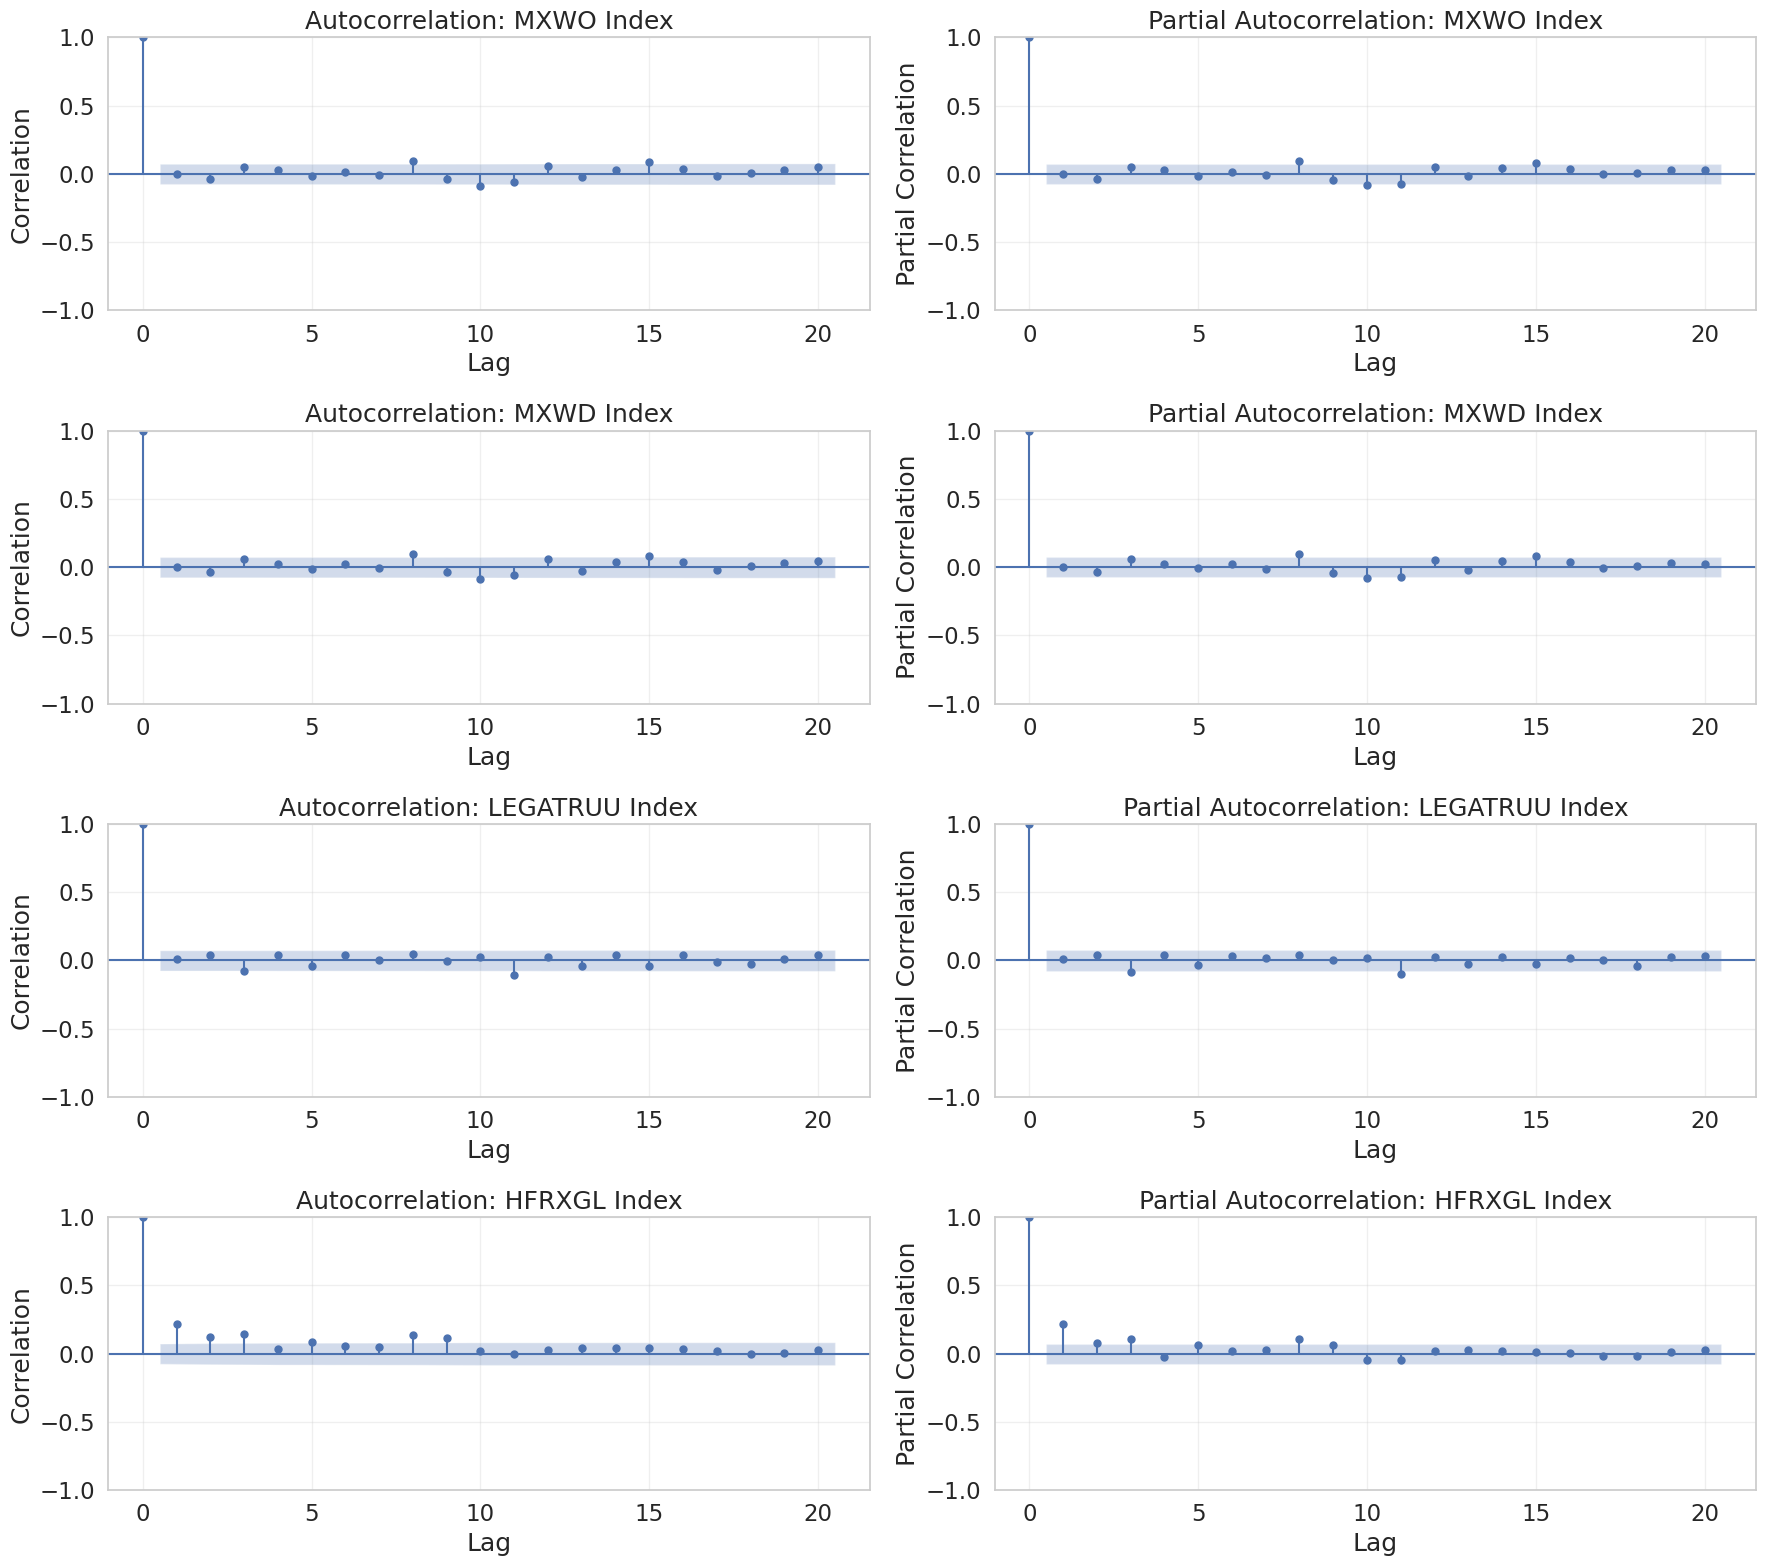


Engle-Granger Cointegration Test Results:

MXWO Index vs MXWD Index: p-value = 0.000e+00 -> Cointegrated
MXWO Index vs LEGATRUU Index: p-value = 7.437e-27 -> Cointegrated
MXWO Index vs HFRXGL Index: p-value = 4.379e-20 -> Cointegrated
MXWD Index vs LEGATRUU Index: p-value = 9.406e-27 -> Cointegrated
MXWD Index vs HFRXGL Index: p-value = 7.968e-20 -> Cointegrated
LEGATRUU Index vs HFRXGL Index: p-value = 0.000e+00 -> Cointegrated


In [ ]:
# Autocorrelation and Partial Autocorrelation analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Define the maximum number of lags to analyze
max_lags = 20

# Create a figure for ACF and PACF plots
fig, axes = plt.subplots(len(target_indices), 2, figsize=(18, 4*len(target_indices)))

# For each target index
for i, idx in enumerate(target_indices):
    # Get returns data for this index
    returns_data = returns[idx].dropna()

    # Plot ACF
    plot_acf(returns_data,
             lags=max_lags,
             ax=axes[i, 0],
             title=f'Autocorrelation: {idx}',
             alpha=0.05)  # 95% confidence intervals

    axes[i, 0].set_xlabel('Lag')
    axes[i, 0].set_ylabel('Correlation')
    axes[i, 0].grid(True, alpha=0.3)

    # Plot PACF
    plot_pacf(returns_data,
              lags=max_lags,
              ax=axes[i, 1],
              title=f'Partial Autocorrelation: {idx}',
              alpha=0.05)  # 95% confidence intervals

    axes[i, 1].set_xlabel('Lag')
    axes[i, 1].set_ylabel('Partial Correlation')
    axes[i, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

from statsmodels.tsa.stattools import coint

# Engle-Granger cointegration test between all pairs in target_indices (NEW)
print("\nEngle-Granger Cointegration Test Results:\n")

for i in range(len(target_indices)):
    for j in range(i+1, len(target_indices)):
        idx1 = target_indices[i]
        idx2 = target_indices[j]

        series1 = returns[idx1].dropna()
        series2 = returns[idx2].dropna()

        # Align series
        common_idx = series1.index.intersection(series2.index)
        s1 = series1.loc[common_idx]
        s2 = series2.loc[common_idx]

        # Run cointegration test
        coint_stat, p_value, crit_values = coint(s1, s2)

        print(f"{idx1} vs {idx2}: p-value = {p_value:.3e} -> {'Cointegrated' if p_value < 0.05 else 'Not cointegrated'}")



In [ ]:
# Engle-Granger Cointegration Test between LEGATRUU Index and HFRXGL Index
from statsmodels.tsa.stattools import coint

# Run the Engle-Granger Cointegration Test between LEGATRUU Index and HFRXGL Index
series1 = returns['LEGATRUU Index'].dropna()
series2 = returns['HFRXGL Index'].dropna()

# Align the series to the common dates
common_idx = series1.index.intersection(series2.index)
s1 = series1.loc[common_idx]
s2 = series2.loc[common_idx]

# Perform the cointegration test
coint_stat, p_value, crit_values = coint(s1, s2)

# Print the results
print("\nEngle-Granger Cointegration Test between LEGATRUU Index and HFRXGL Index:")
print(f"p-value = {p_value:.3e} -> {'Cointegrated' if p_value < 0.05 else 'Not cointegrated'}")

# If cointegrated, you can find the cointegrating relationship:
if p_value < 0.05:
    # Run OLS to find the cointegration relationship
    import statsmodels.api as sm

    # Add constant to the independent variable (HFRXGL Index)
    X = sm.add_constant(s2)

    # Fit the OLS model
    model = sm.OLS(s1, X).fit()

    # Print the results of the regression
    print("\nCointegration relationship (Regression of LEGATRUU Index on HFRXGL Index):")
    print(model.summary())


Engle-Granger Cointegration Test between LEGATRUU Index and HFRXGL Index:
p-value = 0.000e+00 -> Cointegrated

Cointegration relationship (Regression of LEGATRUU Index on HFRXGL Index):
                            OLS Regression Results                            
Dep. Variable:         LEGATRUU Index   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     19.98
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           9.15e-06
Time:                        13:14:49   Log-Likelihood:                 2465.2
No. Observations:                 704   AIC:                            -4926.
Df Residuals:                     702   BIC:                            -4917.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef

The cointegration relationship between the LEGATRUU Index (Global Aggregate Bond) and the HFRXGL Index (Hedge Fund Index) indicates that they are linked by a stable long-term relationship.
This suggests that their price dynamics move in parallel over time, driven by some economic or financial factor that keeps them tending towards a long-term equilibrium.

The regression analysis confirms a linear relationship between the two indices, with HFRXGL Index positively influencing LEGATRUU Index. However, the low R-squared (2.4%) indicates that this relationship is not particularly strong in terms of explaining the variation in LEGATRUU Index solely based on HFRXGL Index.

The Engle-Granger cointegration test with a p-value of 0 strongly indicates that the two indices are indeed cointegrated (Ttheir movements are linked in a way that persists over time while their short-term fluctuations may vary, they are tied in the long run)



Some **statistical tests for Autocorrelation**:
Let's perform formal statistical tests to check for autocorrelation in our return series.

In [ ]:
# Ljung-Box test for autocorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox

print("\nLjung-Box test for Autocorrelation (H0: No autocorrelation)")
for idx in target_indices:
    # Get returns data for this index
    returns_data = returns[idx].dropna()

    # Perform Ljung-Box test for different lags
    lb_test = acorr_ljungbox(returns_data, lags=[5, 10, 15, 20])

    print(f"\n{idx}:")
    print(f"  Lag 5:  Test Statistic = {lb_test.iloc[0, 0]:.4f}, p-value = {lb_test.iloc[0, 1]:.4f}")
    print(f"  Lag 10: Test Statistic = {lb_test.iloc[1, 0]:.4f}, p-value = {lb_test.iloc[1, 1]:.4f}")
    print(f"  Lag 15: Test Statistic = {lb_test.iloc[2, 0]:.4f}, p-value = {lb_test.iloc[2, 1]:.4f}")
    print(f"  Lag 20: Test Statistic = {lb_test.iloc[3, 0]:.4f}, p-value = {lb_test.iloc[3, 1]:.4f}")



Ljung-Box test for Autocorrelation (H0: No autocorrelation)

MXWO Index:
  Lag 5:  Test Statistic = 3.7194, p-value = 0.5905
  Lag 10: Test Statistic = 16.3144, p-value = 0.0910
  Lag 15: Test Statistic = 27.3792, p-value = 0.0258
  Lag 20: Test Statistic = 31.2372, p-value = 0.0521

MXWD Index:
  Lag 5:  Test Statistic = 4.0704, p-value = 0.5393
  Lag 10: Test Statistic = 17.4323, p-value = 0.0653
  Lag 15: Test Statistic = 28.4624, p-value = 0.0188
  Lag 20: Test Statistic = 32.0118, p-value = 0.0432

LEGATRUU Index:
  Lag 5:  Test Statistic = 8.3823, p-value = 0.1364
  Lag 10: Test Statistic = 11.6799, p-value = 0.3071
  Lag 15: Test Statistic = 23.8265, p-value = 0.0681
  Lag 20: Test Statistic = 26.5486, p-value = 0.1484

HFRXGL Index:
  Lag 5:  Test Statistic = 63.9540, p-value = 0.0000
  Lag 10: Test Statistic = 90.7371, p-value = 0.0000
  Lag 15: Test Statistic = 94.7913, p-value = 0.0000
  Lag 20: Test Statistic = 96.3138, p-value = 0.0000


We now perform a Durbin-Watson test to test for autocorrelation

DW ≈ 2 suggests no autocorrelation (this is ideal).

DW < 2 indicates positive autocorrelation (i.e., a trend in the data, with consecutive values being more similar).

DW > 2 indicates negative autocorrelation (i.e., consecutive values tend to alternate or move oppositely).

DW used just for one lag

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

# Durbin-Watson test for autocorrelation
def durbin_watson_test(returns):
    dw_stats = {}
    for idx in returns.columns:
        dw_stat = sm.stats.durbin_watson(returns[idx])
        dw_stats[idx] = dw_stat
    return dw_stats

# Perform Durbin-Watson test
dw_results = durbin_watson_test(returns)
print("\nDurbin-Watson Test Results:")
for idx, dw_stat in dw_results.items():
    print(f"{idx}: DW Statistic = {dw_stat:.2f}")





Durbin-Watson Test Results:
MXWO Index: DW Statistic = 1.99
MXWD Index: DW Statistic = 1.99
LEGATRUU Index: DW Statistic = 1.96
HFRXGL Index: DW Statistic = 1.57


<br>

**Volatility Clustering Analysis**: Financial returns often exhibit volatility clustering - periods of high volatility tend to be followed by similar high volatility periods. We'll examine this phenomenon.

<br>

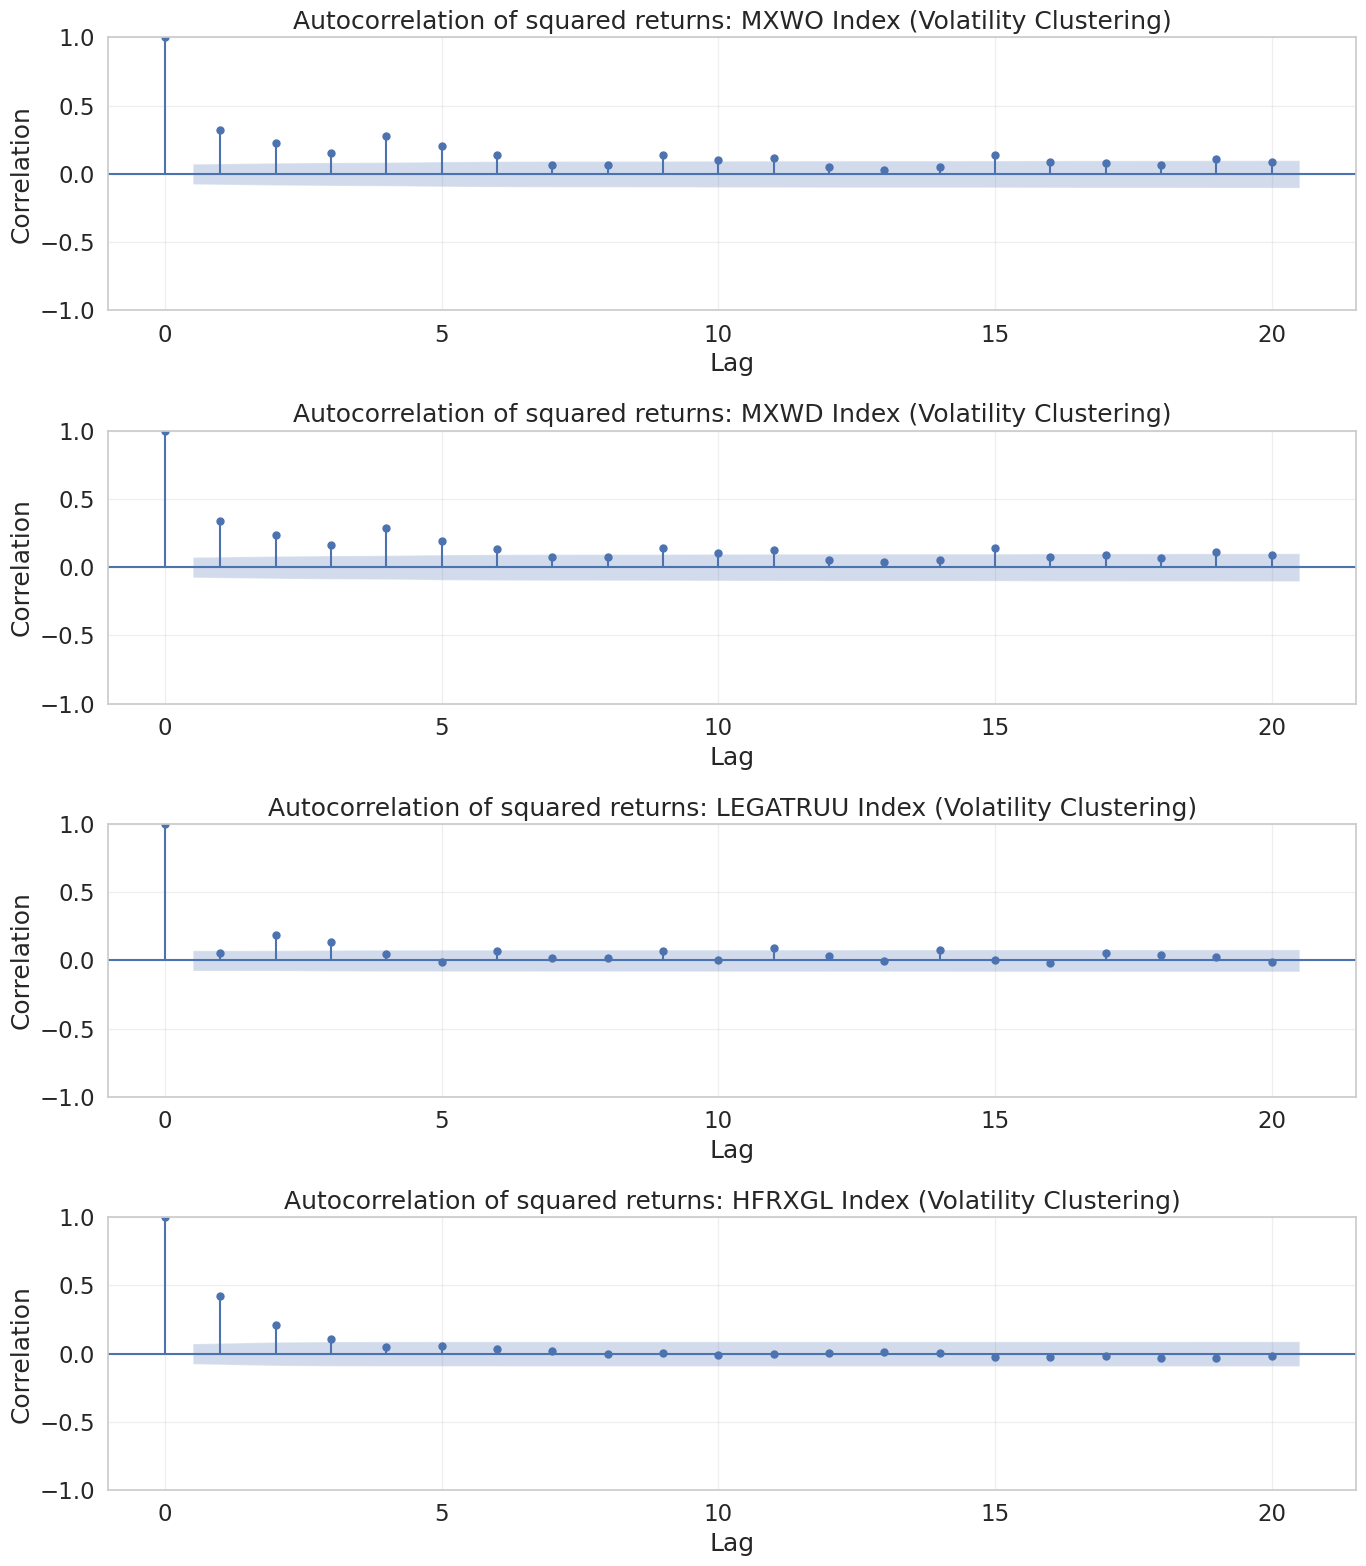

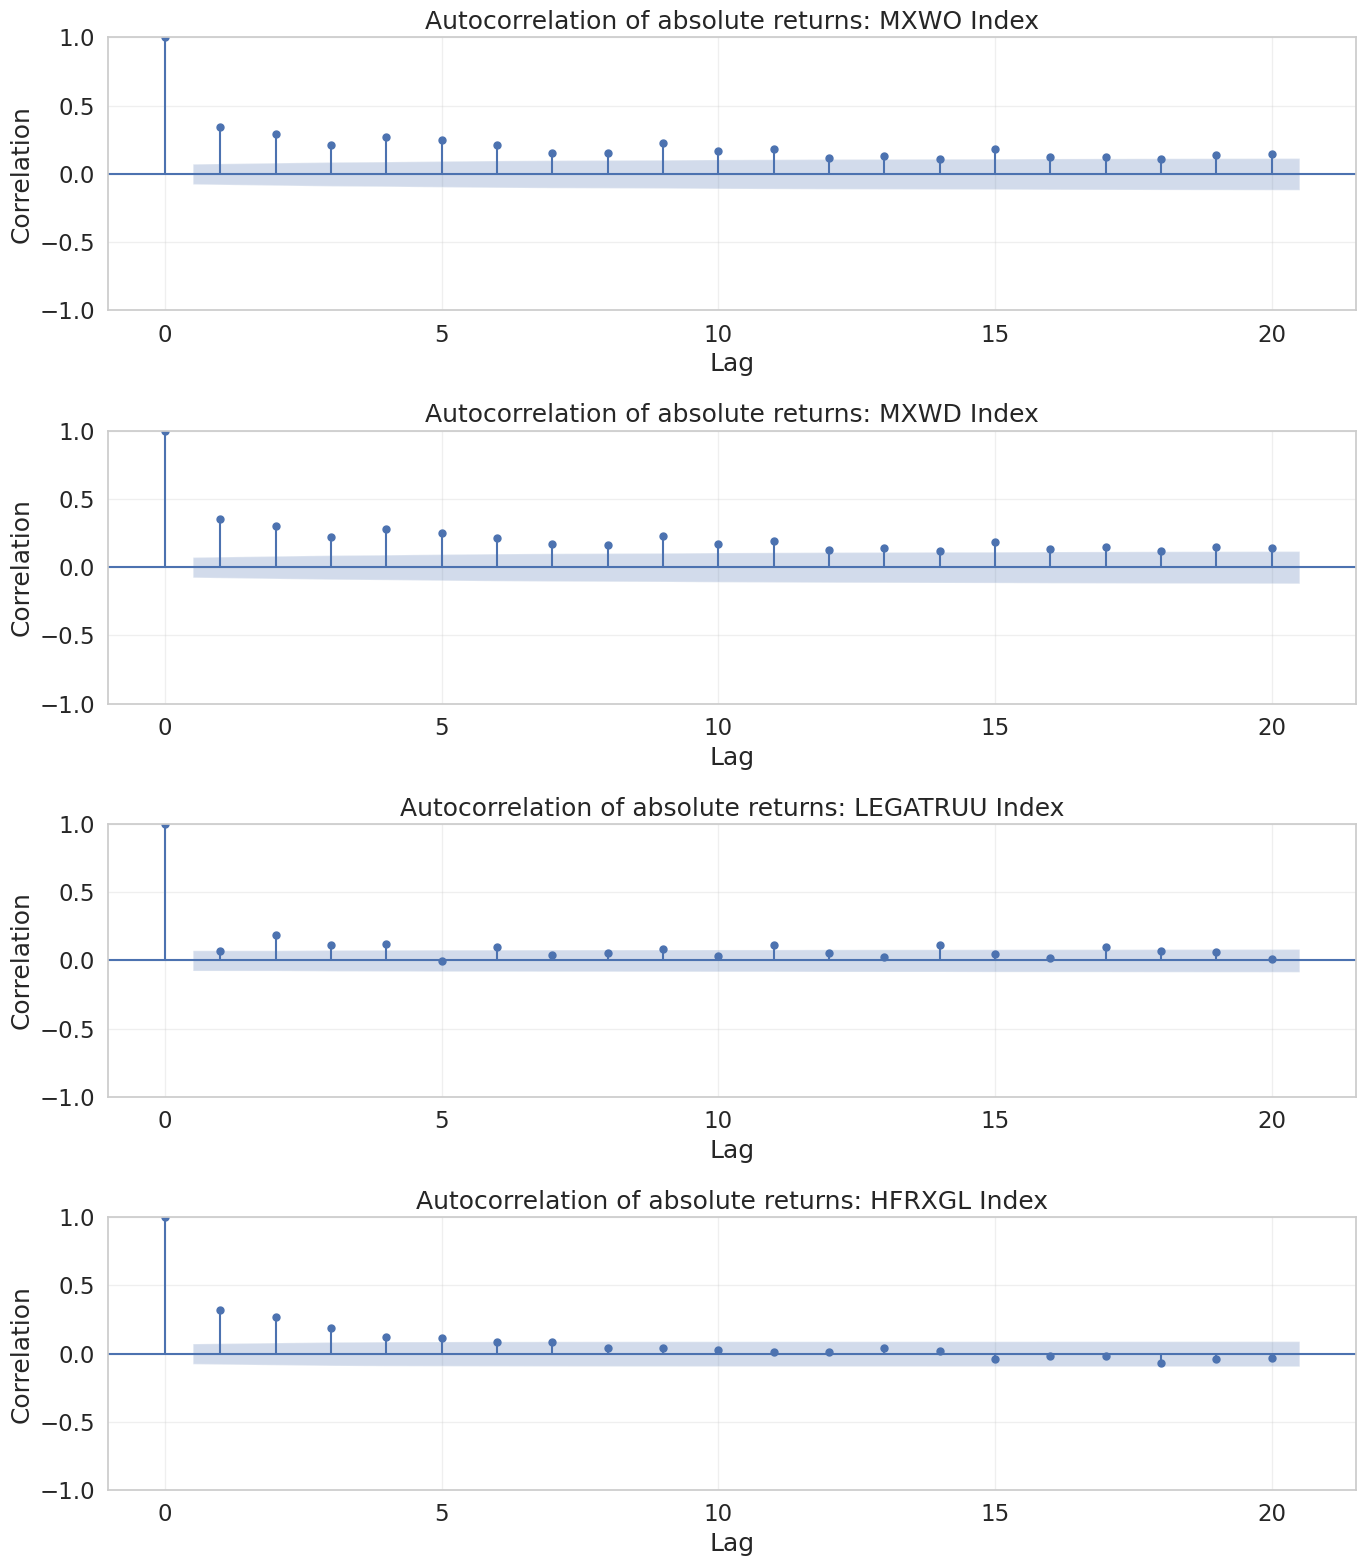

In [ ]:
# Create a figure for squared returns ACF (volatility clustering)
fig, axes = plt.subplots(len(target_indices), 1, figsize=(14, 4*len(target_indices)))

# For each target index
for i, idx in enumerate(target_indices):
    # Get squared returns data for this index (for volatility clustering, ie GARC-like situations)
    squared_returns = returns[idx].dropna() ** 2

    # Plot ACF of squared returns
    plot_acf(squared_returns,
             lags=max_lags,
             ax=axes[i] if len(target_indices) > 1 else axes,
             title=f'Autocorrelation of squared returns: {idx} (Volatility Clustering)',
             alpha=0.05)  # 95% confidence intervals

    if len(target_indices) > 1:
        axes[i].set_xlabel('Lag')
        axes[i].set_ylabel('Correlation')
        axes[i].grid(True, alpha=0.3)
    else:
        axes.set_xlabel('Lag')
        axes.set_ylabel('Correlation')
        axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create a figure for absolute returns ACF (another measure of volatility clustering)
fig, axes = plt.subplots(len(target_indices), 1, figsize=(14, 4*len(target_indices)))

# For each target index
for i, idx in enumerate(target_indices):
    # Get absolute returns data for this index
    abs_returns = abs(returns[idx].dropna())

    # Plot ACF of absolute returns
    plot_acf(abs_returns,
             lags=max_lags,
             ax=axes[i] if len(target_indices) > 1 else axes,
             title=f'Autocorrelation of absolute returns: {idx}',
             alpha=0.05)  # 95% confidence intervals

    if len(target_indices) > 1:
        axes[i].set_xlabel('Lag')
        axes[i].set_ylabel('Correlation')
        axes[i].grid(True, alpha=0.3)
    else:
        axes.set_xlabel('Lag')
        axes.set_ylabel('Correlation')
        axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


We can notice that volatility clustering is present, especially for the first 5/6 lags

<br>

Now let's analyze our constructed target index, the Monster Index, and Futures contracts that are candidates to replicate it in more detail to understand its characteristics before attempting replication.

<br>

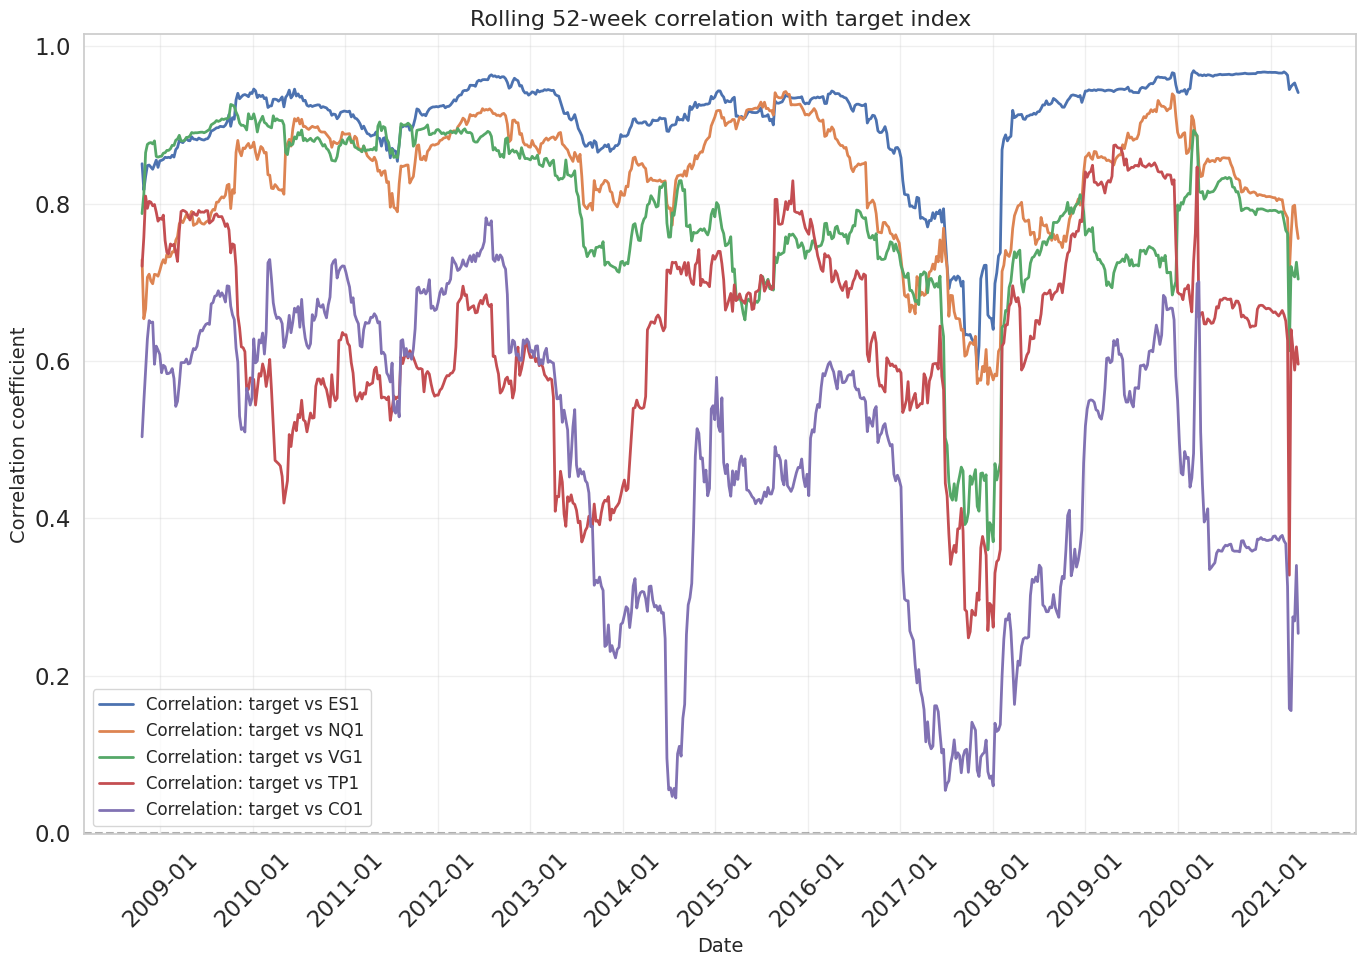

In [ ]:
# Plot rolling correlations between target index and Futures contracts
rolling_window = 52  # 52 weeks ≈ 1 year
plt.figure(figsize=(14, 10))

# Select top 5 futures by correlation (absolute value)
top_futures = correlations.index[:5].tolist()

for contract in top_futures:
    # Calculate rolling correlation
    combined_df = pd.DataFrame({
        'Target': target_returns_aligned,
        'Future': futures_returns[contract]
    })
    rolling_corr = combined_df['Target'].rolling(rolling_window).corr(combined_df['Future'])

    # Plot
    plt.plot(rolling_corr.index, rolling_corr, linewidth=2,
             label=f"Correlation: target vs {contract}")

plt.title(f'Rolling {rolling_window}-week correlation with target index', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Correlation coefficient', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=12)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Looking at the time series and their correlations with the target, they have heterogeneous paths. This can be of help if we want to replicate complex assets, such as our "Monster Index".

In [ ]:
# Calculate and display target index statistics
print("\nTarget index statistics:")
annual_factor = 52  # For weekly data

# Calculate statistics
mean_return = target_returns_aligned.mean() * annual_factor
volatility = target_returns_aligned.std() * np.sqrt(annual_factor)
sharpe_ratio = mean_return / volatility
cumulative_returns = (1 + target_returns_aligned).cumprod()
drawdowns = 1 - cumulative_returns / cumulative_returns.cummax()
max_drawdown = drawdowns.max()
skewness = target_returns_aligned.skew()
kurtosis = target_returns_aligned.kurtosis()

# Display statistics
stats_df = pd.DataFrame({
    'Statistic': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
                  'Max Drawdown', 'Skewness', 'Kurtosis'],
    'Value': [f"{mean_return*100:.2f}%",
              f"{volatility*100:.2f}%",
              f"{sharpe_ratio:.2f}",
              f"{max_drawdown*100:.2f}%",
              f"{skewness:.2f}",
              f"{kurtosis:.2f}"]
})

display(stats_df)

# Also calculate and display monthly returns statistics
if len(target_returns_aligned) >= 12:  # Ensure we have enough data
    # Resample to monthly returns using 'ME' (month end) frequency - more robust
    monthly_returns = target_returns_aligned.resample('ME').apply(
        lambda x: (1 + x).prod() - 1)

    # Calculate monthly statistics
    monthly_mean = monthly_returns.mean() * 12
    monthly_vol = monthly_returns.std() * np.sqrt(12)
    monthly_sharpe = monthly_mean / monthly_vol if monthly_vol > 0 else 0

    # Display monthly statistics
    print("\nMonthly return statistics:")
    monthly_stats = pd.DataFrame({
        'Statistic': ['Annualized return (monthly)',
                     'Annualized volatility (monthly)',
                     'Sharpe ratio (monthly)'],
        'Value': [f"{monthly_mean*100:.2f}%",
                 f"{monthly_vol*100:.2f}%",
                 f"{monthly_sharpe:.2f}"]
    })

    display(monthly_stats)



Target index statistics:


Statistic   Value
0      Annualized return   3.92%
1  Annualized volatility   9.76%
2           Sharpe ratio    0.40
3           Max Drawdown  38.36%
4               Skewness   -0.87
5               Kurtosis    5.44


Monthly return statistics:


Statistic   Value
0      Annualized return (monthly)   4.00%
1  Annualized volatility (monthly)  10.50%
2           Sharpe ratio (monthly)    0.38

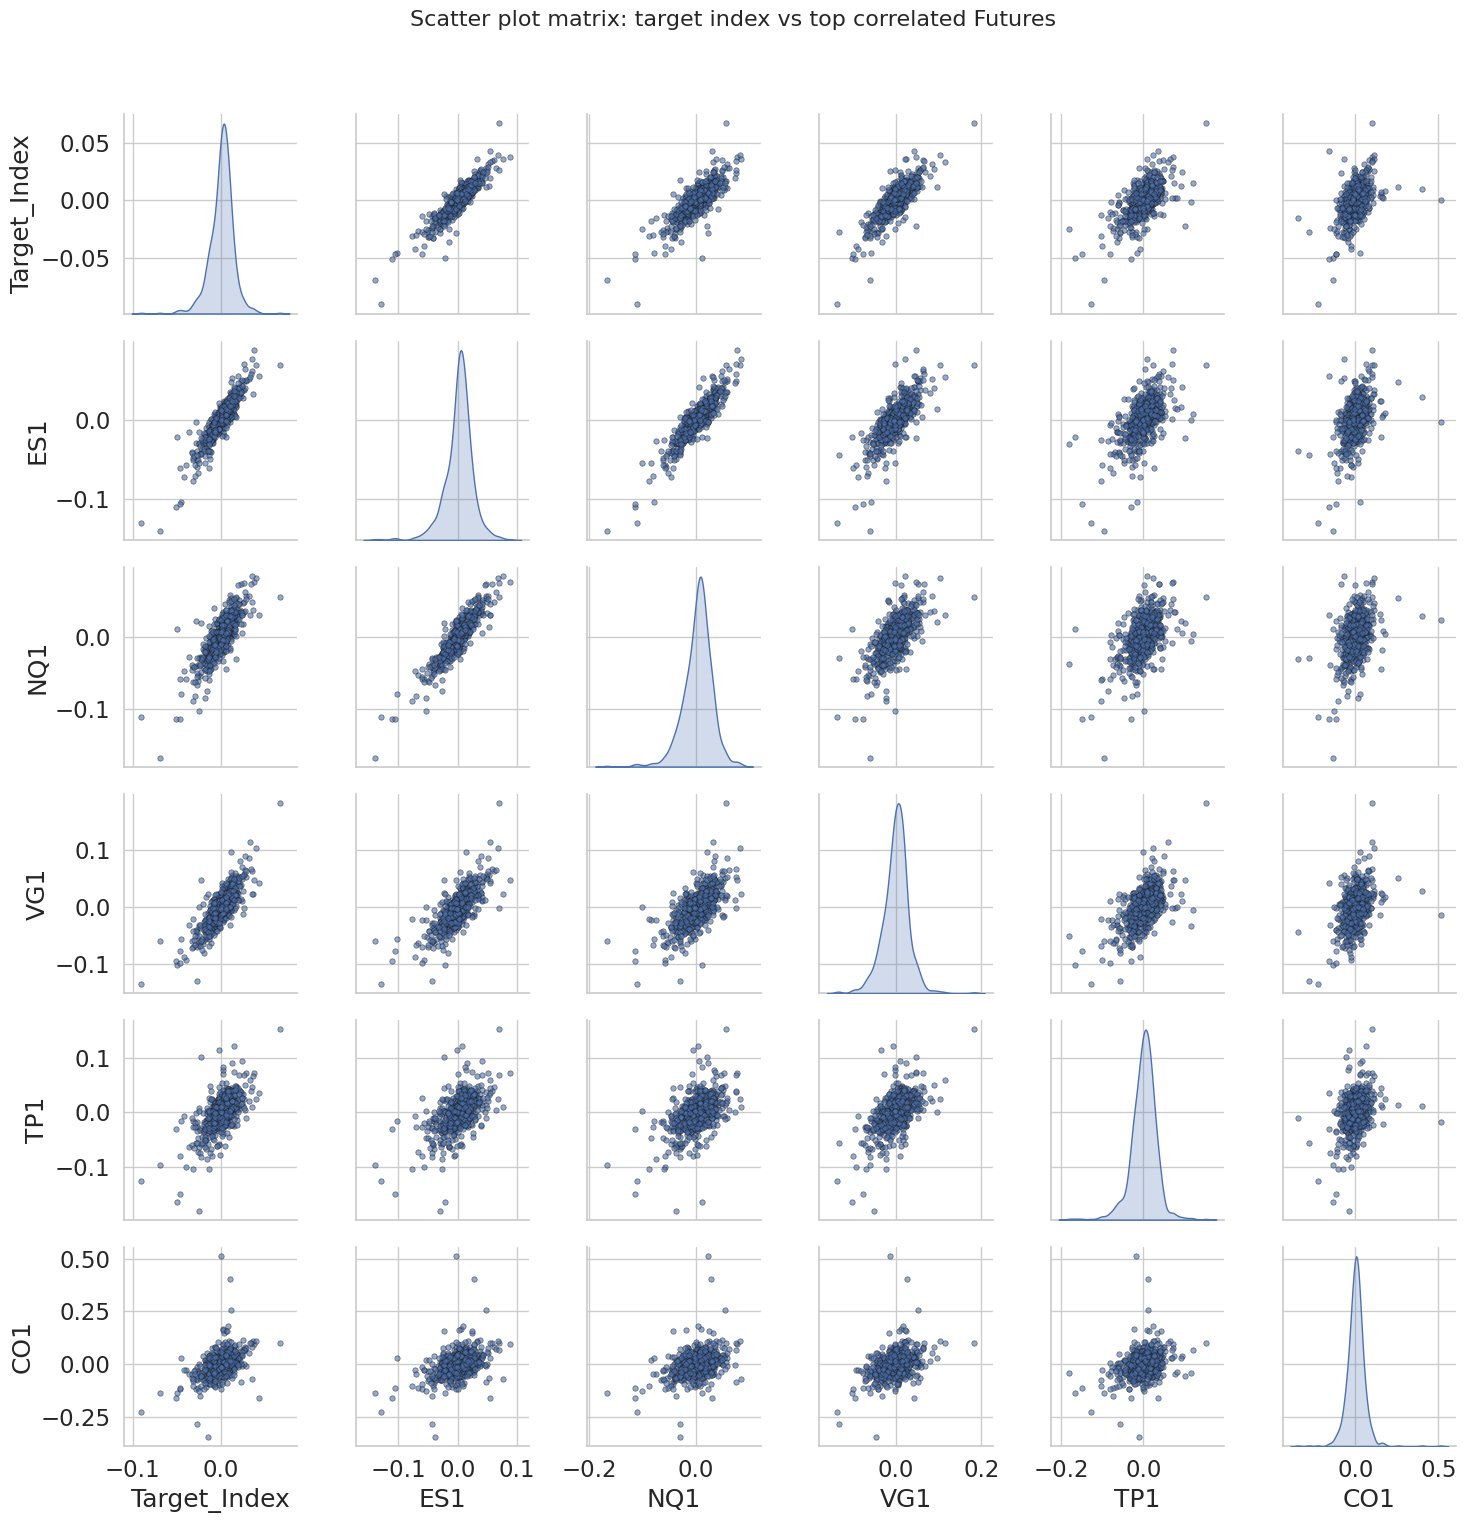

In [ ]:
# Create a scatter plot matrix for the target index and top correlated futures
top_futures_plus_target = ['Target_Index'] + top_futures
scatter_data = pd.concat([target_returns_aligned.rename('Target_Index'),
                          futures_returns[top_futures]], axis=1)

# Create a pair plot
sns.pairplot(scatter_data, kind='scatter', diag_kind='kde',
             plot_kws={'alpha': 0.6, 's': 15, 'edgecolor': 'k', 'linewidth': 0.5})
plt.suptitle('Scatter plot matrix: target index vs top correlated Futures',
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


# Model setup and VAR computation

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import MinMaxScaler
from itertools import product

# Ensure data is properly aligned
y = target_returns_aligned  # Target index returns
X = futures_returns.loc[y.index]  # Futures returns aligned with target

# VaR parameters
var_confidence = 0.01  # 1% VaR
var_horizon = 4  # 4 weeks (1 month)
max_var_threshold = 0.08  # 20% maximum VaR(1%, 1 month)

# Convert to numpy arrays for easier indexing
X_values = X.values
y_values = y.values
dates_array = X.index.to_numpy()

# We set a rolling window of 1 year
rolling_window = 52

# Suppress boring warnings during the loop
import warnings
warnings.filterwarnings('ignore')

# Function for weighted historical VaR with exponential decay and horizon scaling
def calculate_var_weighted_historical(returns, decay=0.95, confidence=0.01, horizon=4):

    returns = np.array(returns)
    n = len(returns)
    if n == 0:
        return np.nan
    weights = np.exp(-decay * (n - 1 - np.arange(n)))
    weights /= weights.sum()
    sorted_idx = np.argsort(returns)
    sorted_returns = returns[sorted_idx]
    sorted_weights = weights[sorted_idx]
    cumw = np.cumsum(sorted_weights)
    idx = np.searchsorted(cumw, confidence)
    # ensure index is within bounds
    idx = min(idx, n-1)
    var = -sorted_returns[idx] * np.sqrt(horizon)
    return var

# 📈 Portfolio Replication Using Linear Models

In portfolio replication, the goal is not just to forecast returns — it is to construct a portfolio that mimics a target return series. This requires a model aligned with the structural nature of portfolios.

---

## 📌 Portfolios as Linear Combinations

A portfolio is fundamentally a linear combination of asset returns:

$$
r_p = \sum_{i=1}^{n} w_i \cdot r_i
$$

- $r_p$: return of the portfolio  
- $w_i$: weight of asset $i$  
- $r_i$: return of asset $i$

---

## 🎯 Structure Over Forecasting

Modern machine learning models like neural networks, random forests and Gaussian processes can predict returns well but do **not** yield usable portfolio weights. They model:

$$
y = f(X)
$$

where $f$ is a complex, nonlinear function.

In contrast, linear models offer interpretable structure:

$$
y_t = X_t \cdot \beta + \varepsilon_t
$$

- $y_t$: target return at time $t$  
- $X_t$: matrix of asset returns  
- $\beta$: vector of coefficients (weights)  
- $\varepsilon_t$: error term

Once the model is trained, the coefficients $\beta_j$ represent the contribution of each asset:

$$
\hat{r}_{\text{replica}} = \sum_j \beta_j \cdot r_j
$$

---

## ⚠️ Risk Management: Value-at-Risk (VaR)

To manage downside risk, we apply a VaR constraint:

- Horizon: 1 month  
- Confidence: 99%  
- Max VaR: 20%

If the portfolio exceeds the threshold, we rescale the weights to reduce risk.

---

## 🔄 Rolling Backtest for Time Series

Time series data require dynamic evaluation:

1. Use a rolling window of length $K$ for training  
2. Predict out-of-sample at $t + 1$  
3. Roll the window forward  
4. Repeat and evaluate performance on unseen data  


---

## 🔧 Regularized Linear Models

To improve robustness, we use **regularization**:

###  Ridge Regression (L2 penalty)

$$
\min_\beta \left\{ \| y - X\beta \|^2 + \lambda \sum_j \beta_j^2 \right\}
$$

- Keeps all features  
- Useful when many variables matter  
- Controls multicollinearity  

###  Lasso Regression (L1 penalty)

$$
\min_\beta \left\{ \| y - X\beta \|^2 + \lambda \sum_j |\beta_j| \right\}
$$

- Shrinks some weights to **zero**  
- Leads to **sparser** portfolios  
- Great for feature selection  

###  Elastic Net (L1 + L2)

$$
\min_\beta \left\{ \| y - X\beta \|^2 + \lambda \left( \alpha \sum_j |\beta_j| + (1 - \alpha) \sum_j \beta_j^2 \right) \right\}
$$

- $\alpha = 1$: Lasso  
- $\alpha \to 0$: Ridge  
- Works well with many **correlated** features  

---

## 🔍 Hyperparameter Tuning

For each model, we tune:

- $\lambda$: regularization strength  
- $\alpha$: mixing ratio (Elastic Net)

Use **cross-validation** or **grid search** to select optimal values.

---

## ✅ Our model

**Elastic Net** is highly effective for portfolio replication:

- Robust to noise  
- Performs feature selection  
- Balances interpretability and flexibility  


### ⚠️ Normalization

When using penalized regression models, it's standard practice to **normalize the input variables**.

Regularization adds a penalty term to the loss function, ie:

$
\min_{\beta} \left\{ \| y - X\beta \|^2 + \alpha \left( \lambda \|\beta\|_1 + (1 - \lambda) \|\beta\|_2^2 \right) \right\}
$

If the columns of $X$ have **different scales**, then the penalty will **affect them unequally**. More volatile instruments will receive **higher penalties**, just because of their unit of measurement. This distorts the model.

We normalize each feature to bring them to a comparable range.

This makes the penalty fair and allows Elastic Net to **select variables and assign weights** based on their **predictive power**, not their scale.


We also normalize $y$, the target time series, to ensure the regression works properly in the normalized space.

However, we do **not use predictions in the normalized space**. After the model is trained, we:

1. **Extract the coefficients** in the normalized space: $beta^{\text{norm}}$;
2. **Rescale them** back to the original units by dividing by the feature scaling factors:

$
\beta^{\text{original}}_j = \frac{\beta^{\text{norm}}_j}{s_j}
$

where $s_j$ is the scaling factor of feature $j$.

<br>

---

<br>


#### 📌 Why this is acceptable

In this application, we are not looking for interpretable regression coefficients — we want a **replicating portfolio**. The final weights must be in **original units** so we can compute portfolio returns, exposures, Value-at-Risk, etc.

Normalizing and then rescaling allows us to:
- Train a more robust and regularized model
- Avoid scale-induced bias
- Operate in real-world financial units in the end.

---
<br>


In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler

# Function tht replicates Elastic net one-step-ahead with recalibration option

def run_elastic_net_normalized(
    l1_ratio: float,
    rolling_window: int,
    alpha: float,
    start_test: int = 365,
    end_test: int = None,
    recalib: bool = False,
    calib_window: int = 52,
    transaction_costs: bool = True
) -> dict:

    # === Calibration Mode ===
    if recalib:

        # Split into train/validation
        X_block = X_values[:start_test]
        y_block = y_values[:start_test]

        train_end = len(y_block) - calib_window
        X_sub = X_block[:train_end]
        y_sub = y_block[:train_end]
        X_val = X_block[train_end:]
        y_val = y_block[train_end:]

        # Fit scaler and model on training
        scaler = StandardScaler().fit(X_sub)
        Xs_sub = scaler.transform(X_sub)
        Xs_val = scaler.transform(X_val)

        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio,
                           fit_intercept=False, max_iter=10000, tol=1e-4)
        model.fit(Xs_sub, y_sub)
        y_pred = model.predict(Xs_val)

        # Compute validation metrics
        te = np.std(y_pred - y_val) * np.sqrt(52)
        ann_pred = np.mean(y_pred) * 52
        ann_val = np.mean(y_val) * 52
        ir = (ann_pred - ann_val) / te if te > 0 else np.nan
        avg_var = abs(np.percentile(y_pred - y_val, 1) * np.sqrt(4))

        return {
            'tracking_error_valid': te,
            'information_ratio_valid': ir,
            'avg_var_valid': avg_var,
            'alpha': alpha,
            'l1_ratio': l1_ratio
        }

    # === Backtest Mode ===
    end_idx = end_test if end_test is not None else len(X_values)
    X_bt = X_values[start_test:end_idx]
    y_bt = y_values[start_test:end_idx]
    dates_bt = dates_array[start_test:end_idx]

    N = len(y_bt)
    weights_history, replica_rets = [], []
    gross_exposures, var_vals, scale_factors = [], [], []
    prev_w = None
    tc_rate = 0.0005 if transaction_costs else 0.0

    for i in range(rolling_window, N):
        # Rolling window training set
        X_train = X_bt[i - rolling_window:i]
        y_train = y_bt[i - rolling_window:i]

        # Normalize inputs
        scaler = StandardScaler().fit(X_train)
        Xt = scaler.transform(X_train)
        x_next = scaler.transform(X_bt[i].reshape(1, -1)).ravel()  # <-- Enhancement 1

        # Fit model and compute weights
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio,
                           fit_intercept=False, max_iter=10000, tol=1e-4)
        model.fit(Xt, y_train)
        w_scaled = model.coef_
        w_orig = w_scaled / scaler.scale_

        # Compute return and apply transaction
        tc = np.sum(np.abs(w_orig - prev_w)) * tc_rate if prev_w is not None else 0.0
        r_next = float(np.dot(X_bt[i], w_orig) - tc)
        replica_rets.append(r_next)
        prev_w = w_orig.copy()

        # Store metrics
        gross_exposures.append(np.sum(np.abs(w_orig)))
        weights_history.append(w_orig.copy())
        var_vals.append(np.nan)
        scale_factors.append(1.0)

    # Align time series
    dates_out = dates_bt[rolling_window:]
    replica_ser = pd.Series(replica_rets, index=dates_out)
    target_ser = pd.Series(y_bt, index=dates_bt).loc[dates_out]

    # Compute performance metrics
    cum_rep = (1 + replica_ser).cumprod()
    cum_tgt = (1 + target_ser).cumprod()

    freq = 52
    ann_rep = replica_ser.mean() * freq
    ann_tgt = target_ser.mean() * freq
    vol_rep = replica_ser.std() * np.sqrt(freq)
    vol_tgt = target_ser.std() * np.sqrt(freq)
    te = (replica_ser - target_ser).std() * np.sqrt(freq)
    ir = (ann_rep - ann_tgt) / te if te > 0 else np.nan
    corr = replica_ser.corr(target_ser)
    max_dd = (1 - cum_rep / cum_rep.cummax()).max()
    avg_exp = np.mean(gross_exposures)

    return {
        'l1_ratio': l1_ratio,
        'rolling_window': rolling_window,
        'alpha': alpha,
        'replica_return': ann_rep,
        'target_return': ann_tgt,
        'replica_vol': vol_rep,
        'target_vol': vol_tgt,
        'replica_sharpe': ann_rep / vol_rep if vol_rep > 0 else np.nan,
        'target_sharpe': ann_tgt / vol_tgt if vol_tgt > 0 else np.nan,
        'tracking_error': te,
        'information_ratio': ir,
        'correlation': corr,
        'max_drawdown': max_dd,
        'avg_gross_exposure': avg_exp,
        'avg_var': np.nanmean(var_vals),
        'replica_returns': replica_ser,
        'aligned_target': target_ser,
        'cumulative_replica': cum_rep,
        'cumulative_target': cum_tgt,
        'gross_exposures': gross_exposures,
        'var_values': var_vals,
        'scaling_factors': scale_factors,
        'weights_history': weights_history
    }


<br>

Now let's run the model with various values ​​for the hyperparameters. We use a multiobject trial: we tried all the models separately, but this one gives better results.

<br>

In [ ]:
!pip install optuna

import optuna
import plotly.graph_objects as go
from optuna.samplers import NSGAIISampler
import pandas as pd
import matplotlib.pyplot as plt

# Objective function
def multi_objective(trial):
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
    alpha = trial.suggest_float("alpha", 1e-6, 5*1e-1, log=True)

    res = run_elastic_net_normalized(
        l1_ratio=l1_ratio,
        rolling_window=rolling_window,
        alpha=alpha,
        start_test=7 * 52,   # start test after 7 years of training
        recalib=True,       # False -> NO calibration → use real backtest
        transaction_costs=False
    )

    return (
        res['tracking_error_valid'],
        -res['information_ratio_valid'],
        res['avg_var_valid']
    )

# Run Optuna multi-objective optimization
study = optuna.create_study(
    directions=["minimize", "minimize", "minimize"],
    sampler=NSGAIISampler()
)
study.optimize(multi_objective, n_trials=3000)

# Pareto frontier visualization
pareto_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
fig = go.Figure(data=[go.Scatter3d(
    x=[t.values[0] for t in pareto_trials],                # Tracking Error
    y=[-t.values[1] for t in pareto_trials],               # Info Ratio (restored sign)
    z=[t.values[2] for t in pareto_trials],                # Avg VaR
    mode='markers',
    marker=dict(size=8, color=[t.values[2] for t in pareto_trials], colorscale='Viridis'),
    text=[f"L1={t.params['l1_ratio']:.2f}, α={t.params['alpha']:.4f}"
          for t in pareto_trials]
)])
fig.update_layout(
    scene=dict(
        xaxis_title='Tracking Error',
        yaxis_title='Information Ratio',
        zaxis_title='Avg VaR (1%, 1M)'
    ),
    title="Pareto Frontier (Backtest-Based Optimization)"
)
fig.show()

# Select best trial by highest information ratio
best_trial = max(pareto_trials, key=lambda t: -t.values[1])
best_l1 = best_trial.params['l1_ratio']
best_alpha = best_trial.params['alpha']

# Run final evaluation with transaction costs
en_res = run_elastic_net_normalized(
    l1_ratio=best_l1,
    rolling_window=rolling_window,
    alpha=best_alpha,
    start_test=7*52,
    recalib=False,
    transaction_costs=True
)

# Display performance metrics
metrics_df = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{en_res['target_return']*100:.2f}%",
               f"{en_res['target_vol']*100:.2f}%",
               f"{en_res['target_sharpe']:.2f}",
               f"{en_res['max_drawdown']*100:.2f}%",
               "N/A", "N/A", "N/A", "N/A", "N/A"],
    'Replica': [f"{en_res['replica_return']*100:.2f}%",
                f"{en_res['replica_vol']*100:.2f}%",
                f"{en_res['replica_sharpe']:.2f}",
                f"{en_res['max_drawdown']*100:.2f}%",
                f"{en_res['tracking_error']*100:.2f}%",
                f"{en_res['information_ratio']:.2f}",
                f"{en_res['correlation']:.4f}",
                f"{en_res['avg_gross_exposure']:.4f}",
                f"{en_res['avg_var']*100:.2f}%"]
})
print("\nMetrics for Selected Pareto-Optimal Configuration:")
display(metrics_df) # Cumulative returns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 22.5 MB/s eta 0:00:00


[I 2025-06-02 13:15:00,200] A new study created in memory with name: no-name-3d85c094-c7e5-40ba-a7a0-0828b9da92d5
[I 2025-06-02 13:15:00,206] Trial 0 finished with values: [0.03580830780526291, 0.3522520480473395, 0.026853534958254717] and parameters: {'l1_ratio': 0.025967409172875433, 'alpha': 0.24986586866621066}.
[I 2025-06-02 13:15:00,211] Trial 1 finished with values: [0.02897526335405924, 0.233512168497547, 0.020564665563794913] and parameters: {'l1_ratio': 0.370479972521237, 'alpha': 0.01297613763015631}.
[I 2025-06-02 13:15:00,215] Trial 2 finished with values: [0.01904626376815838, 0.7408536227769724, 0.010939133035556459] and parameters: {'l1_ratio': 0.8545054035813335, 'alpha': 1.2849833893835939e-06}.
[I 2025-06-02 13:15:00,219] Trial 3 finished with values: [0.059691099638933216, 0.4780171347319759, 0.04373216044444434] and parameters: {'l1_ratio': 0.27801977239042175, 'alpha': 0.16543857361364123}.
[I 2025-06-02 13:15:00,223] Trial 4 finished with values: [0.0189852697549


Metrics for Selected Pareto-Optimal Configuration:


Metric Target Replica
0       Annualized return  7.35%   5.03%
1   Annualized volatility  8.24%   4.84%
2            Sharpe ratio   0.89    1.04
3            Max Drawdown  7.08%   7.08%
4          Tracking Error    N/A   4.62%
5       Information ratio    N/A   -0.50
6             Correlation    N/A  0.8771
7  Average gross exposure    N/A  0.2767
8    Average VaR (1%, 1M)    N/A    nan%

### Key Performance metrics

All the following metrics are considered annualized (so are rescaled yearly where necessary).


---

**Cumulative Returns**  
The compounded portfolio return over time.

---

**Volatility**  
The standard deviation of a portfolio's returns.  
It represents the total variability of the investment.

---

**Tracking Error Volatility**  
The standard deviation of the difference between the returns of a portfolio and its benchmark.  
It measures how closely the portfolio follows the benchmark.  

$
TE = \sqrt{ \text{Variance}(r_{\text{portfolio}} - r_{\text{benchmark}}) }
$



---

**Sharpe Ratio**  
A measure of risk-adjusted return. It compares the excess return of a portfolio to its volatility.  
$
\text{Sharpe Ratio} = \frac{E[r_{\text{portfolio}} - r_f]}{\sigma_{\text{portfolio}}}
$
In practice, we often use 0% as the risk-free rate $r_f$ for short horizons.

---

**Max Drawdown**  
The maximum observed loss from a peak to a trough before a new peak is reached.  
It measures the worst-case decline in portfolio value over a given period.

---

**Gross Exposure**  
The sum of the absolute values of all portfolio weights.  
It indicates the total level of capital deployed, including both long and short positions.  
$
\text{Gross Exposure} = \sum_j |\text{weight}_j|
$

---

**Information Ratio**  
A measure of excess return over the benchmark per unit of tracking error.  
$
\text{Information Ratio} = \frac{E[r_{\text{portfolio}} - r_{\text{benchmark}}]}{\text{TE}}
$

---

**Correlation**  
The Pearson correlation between portfolio and benchmark returns.  

---
**Average VaR Estimate**  
The average Value-at-Risk over time at a fixed confidence level, scaled to the holding period.   Estimates the expected extreme loss.  







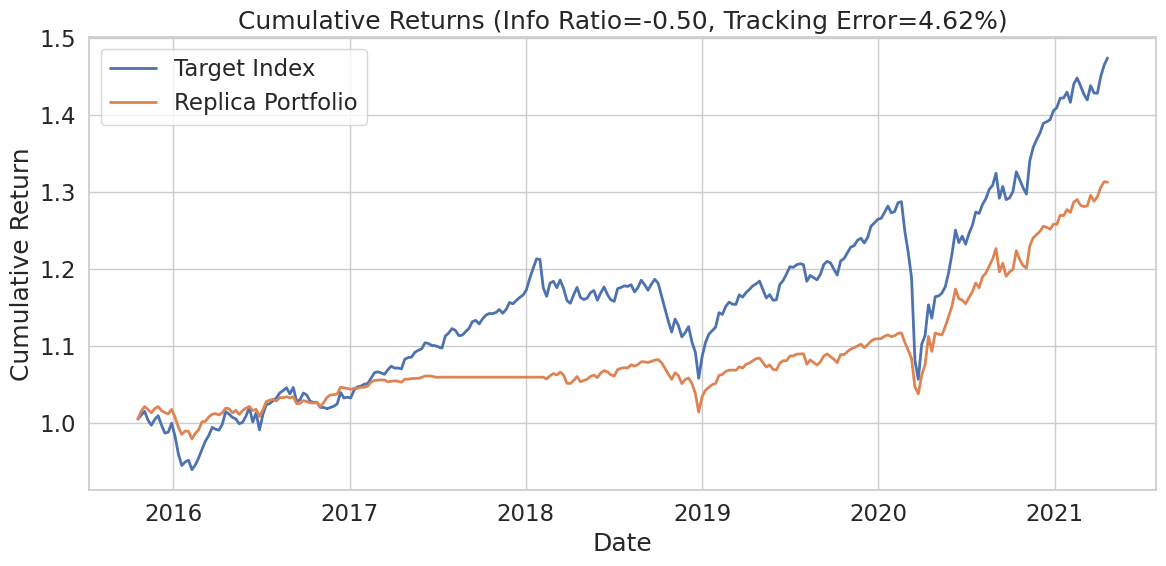

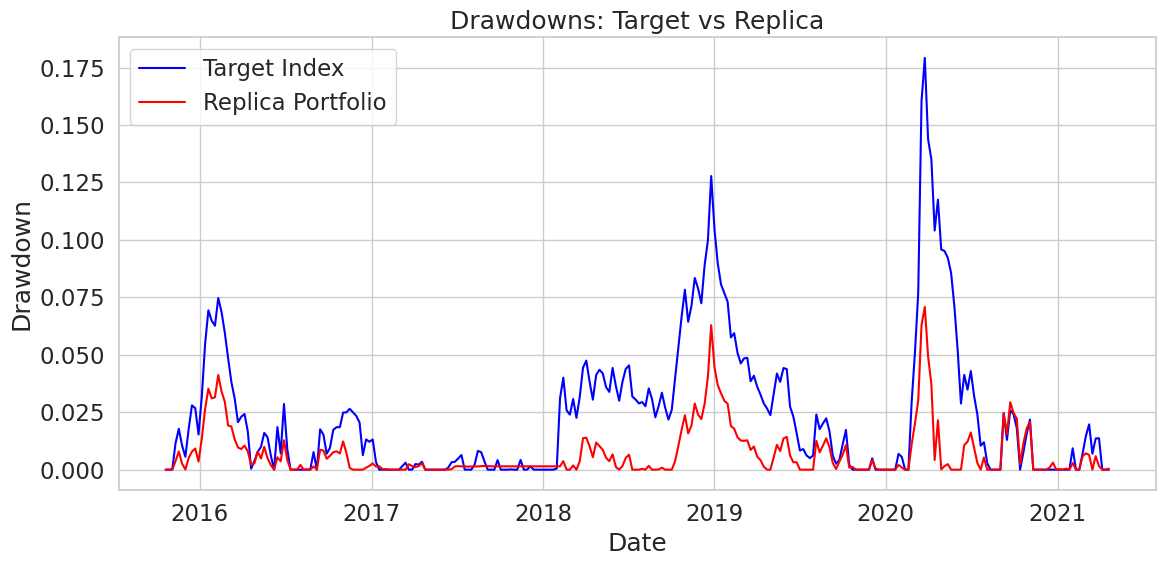

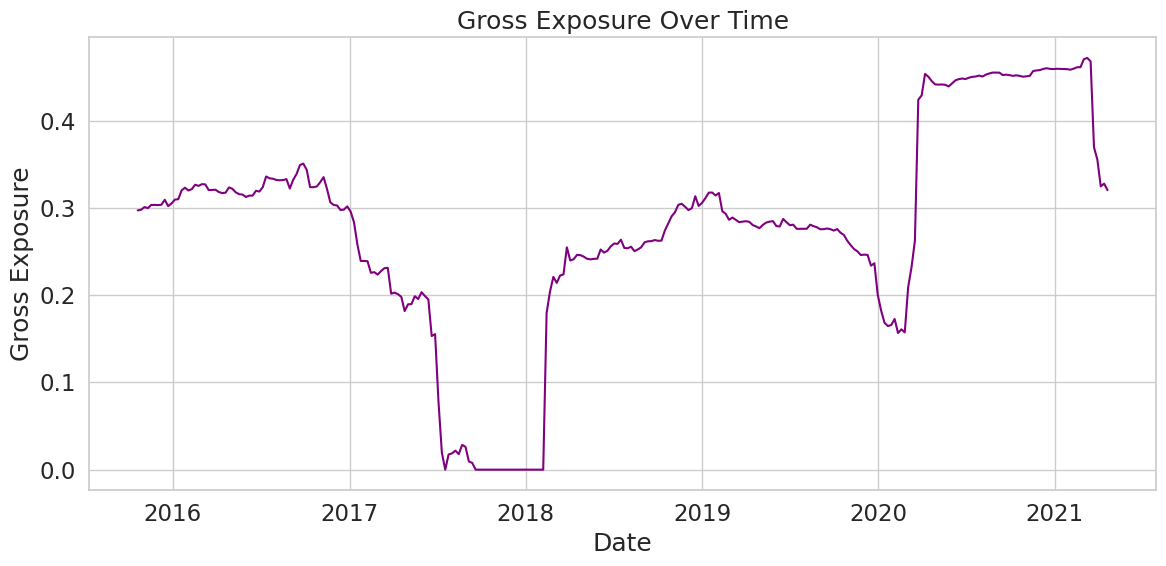

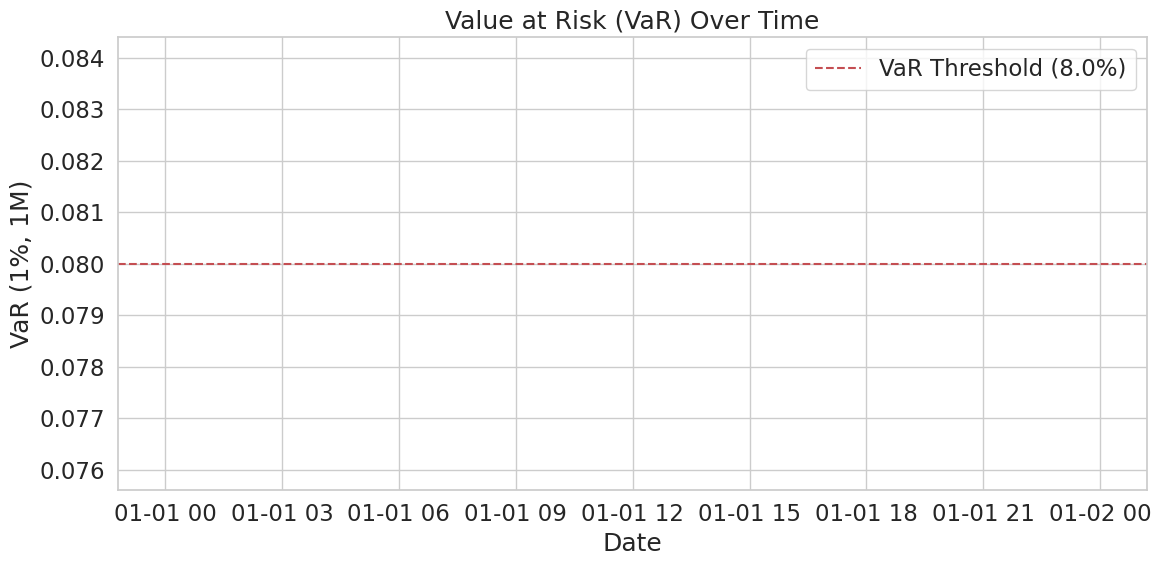

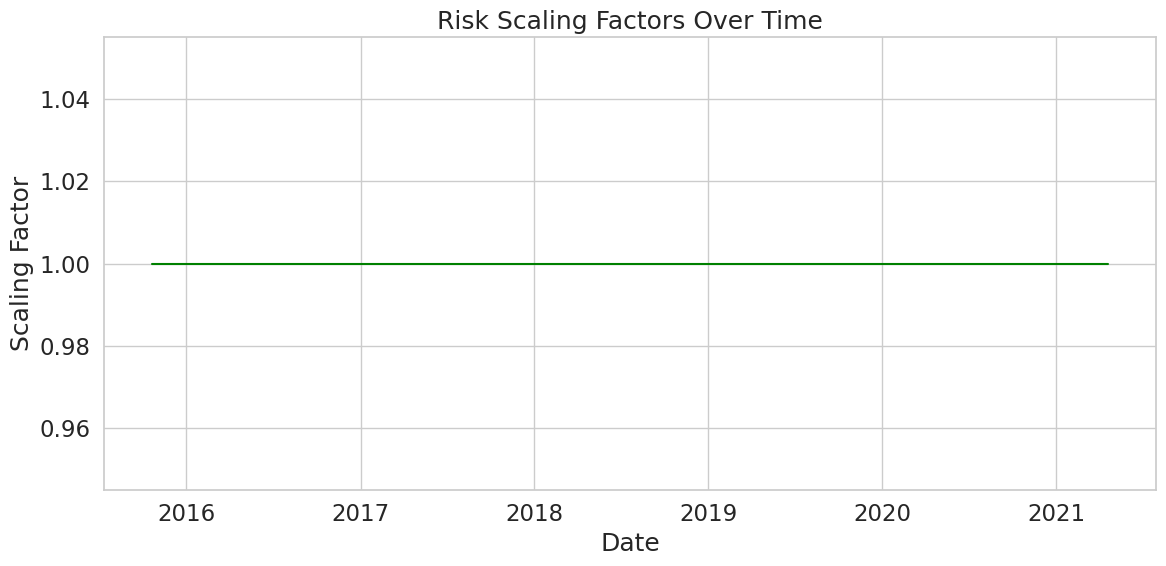

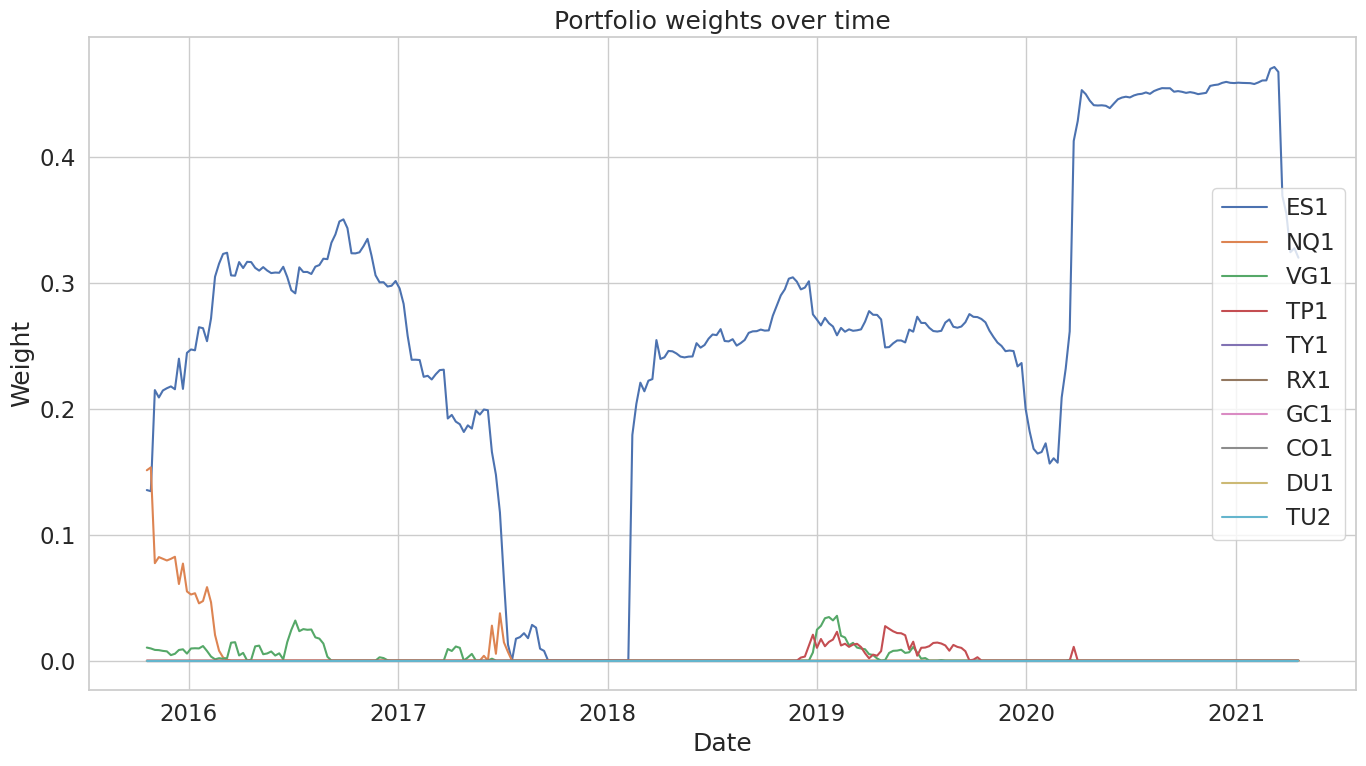

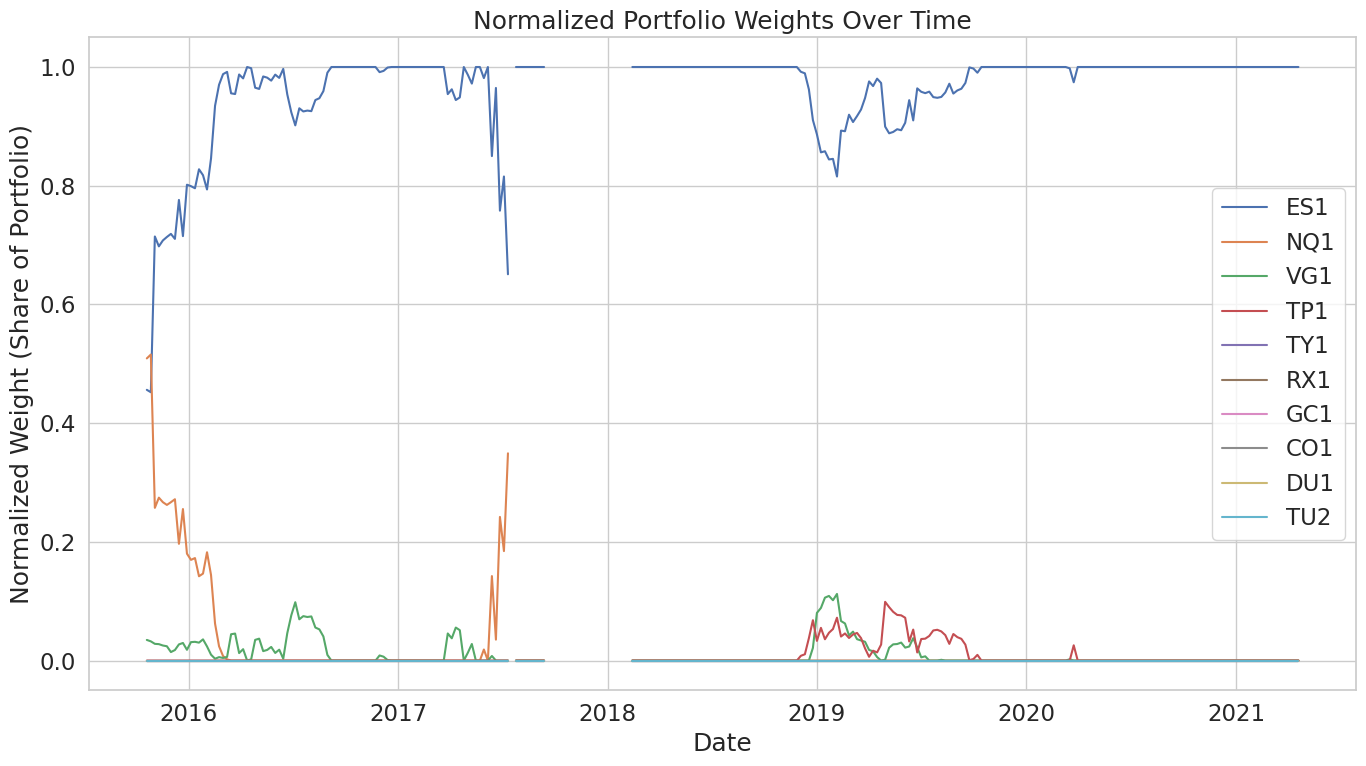

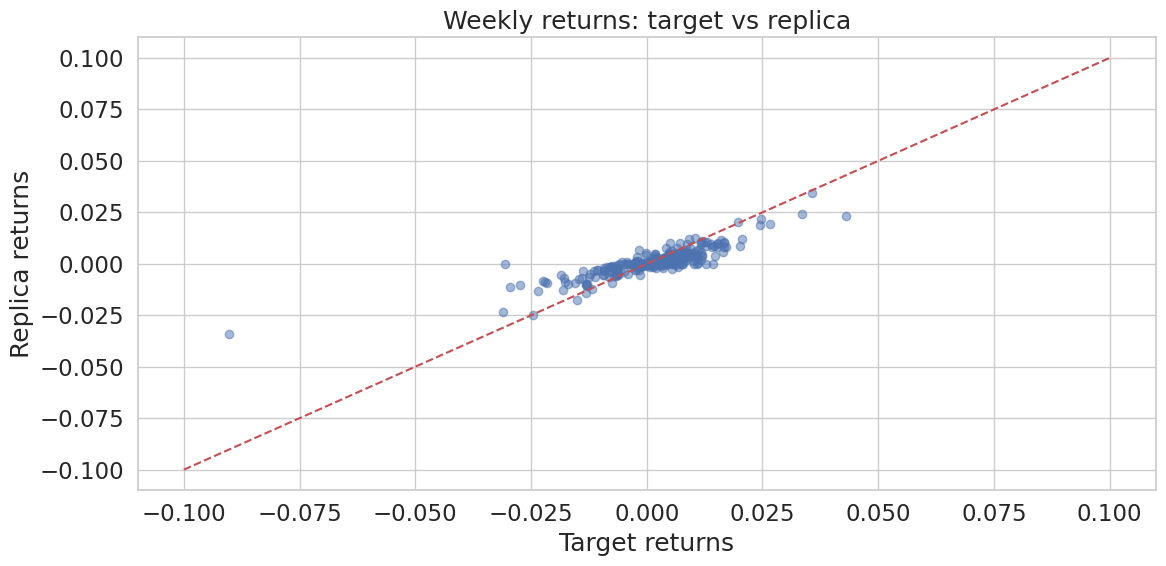

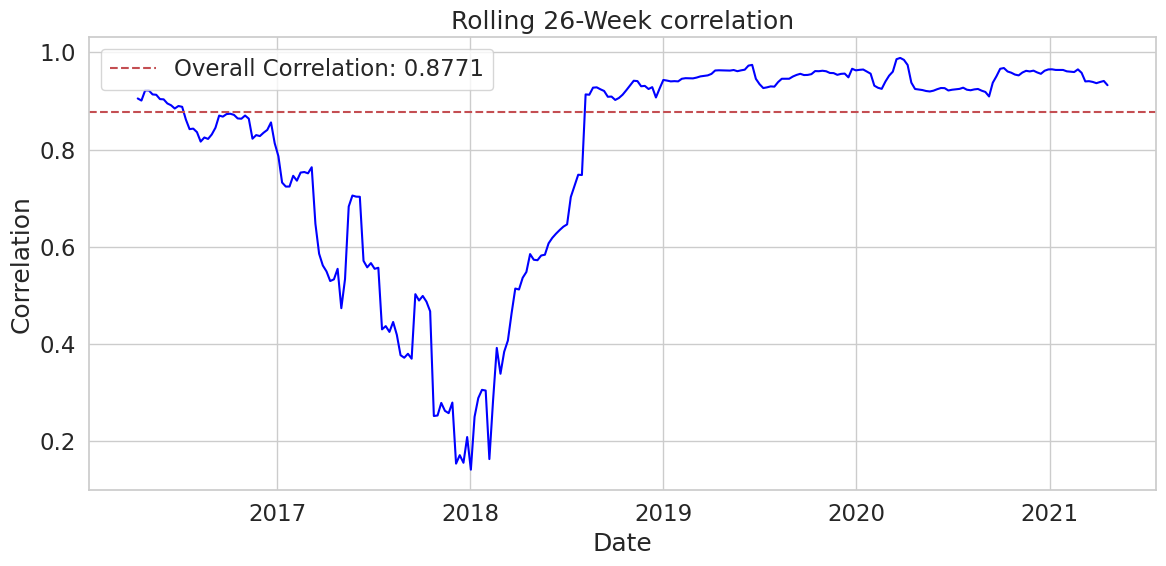

In [ ]:
# Cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(en_res['cumulative_target'], label='Target Index', linewidth=2)
plt.plot(en_res['cumulative_replica'], label='Replica Portfolio', linewidth=2)
plt.title(f'Cumulative Returns (Info Ratio={en_res["information_ratio"]:.2f}, '
          f'Tracking Error={en_res["tracking_error"]*100:.2f}%)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Drawdowns
plt.figure(figsize=(12, 6))
target_dd = 1 - en_res['cumulative_target'] / en_res['cumulative_target'].cummax()
replica_dd = 1 - en_res['cumulative_replica'] / en_res['cumulative_replica'].cummax()
plt.plot(target_dd, label='Target Index', color='blue')
plt.plot(replica_dd, label='Replica Portfolio', color='red')
plt.title('Drawdowns: Target vs Replica')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gross exposure
plt.figure(figsize=(12, 6))
plt.plot(pd.Series(en_res['gross_exposures'], index=en_res['replica_returns'].index), color='purple')
plt.title('Gross Exposure Over Time')
plt.xlabel('Date')
plt.ylabel('Gross Exposure')
plt.grid(True)
plt.tight_layout()
plt.show()

# VaR
plt.figure(figsize=(12, 6))
plt.plot(pd.Series(en_res['var_values'], index=en_res['replica_returns'].index), color='orange')
plt.axhline(y=max_var_threshold, color='r', linestyle='--', label=f'VaR Threshold ({max_var_threshold*100}%)')
plt.title('Value at Risk (VaR) Over Time')
plt.xlabel('Date')
plt.ylabel('VaR (1%, 1M)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scaling factors
plt.figure(figsize=(12, 6))
plt.plot(pd.Series(en_res['scaling_factors'], index=en_res['replica_returns'].index), color='green')
plt.title('Risk Scaling Factors Over Time')
plt.xlabel('Date')
plt.ylabel('Scaling Factor')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot weights over time
weights_history = en_res['weights_history']
weights_df = pd.DataFrame(weights_history, index=en_res['replica_returns'].index)

# Get the column names from the original futures data
weights_df.columns = X.columns

# Plot the weights by absolute average value
top_weights = weights_df.abs().mean().sort_values(ascending=False).head(11).index
plt.figure(figsize=(14, 8))
for col in top_weights:
    plt.plot(weights_df[col], label=col)
plt.title('Portfolio weights over time')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Extract weights history
weights_history = en_res['weights_history']
weights_df = pd.DataFrame(weights_history, index=en_res['replica_returns'].index)

# Normalize the weights row-wise (portfolio allocation per time point)
normalized_weights_df = weights_df.div(weights_df.sum(axis=1), axis=0)

# Assign the original column names (futures)
normalized_weights_df.columns = X.columns

# Select the top futures based on average absolute weights over time
top_weights = normalized_weights_df.abs().mean().sort_values(ascending=False).head(11).index

# Plot the normalized weights
plt.figure(figsize=(14, 8))
for col in top_weights:
    plt.plot(normalized_weights_df[col], label=col)
plt.title('Normalized Portfolio Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Weight (Share of Portfolio)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot weekly returns
plt.figure(figsize=(12, 6))
plt.scatter(en_res['aligned_target'], en_res['replica_returns'], alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], 'r--')  # Diagonal line
plt.title('Weekly returns: target vs replica')
plt.xlabel('Target returns')
plt.ylabel('Replica returns')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot rolling correlation
plt.figure(figsize=(12, 6))
rolling_corr = en_res['replica_returns'].rolling(window=26).corr(en_res['aligned_target'])
plt.plot(rolling_corr, color='blue')
plt.title('Rolling 26-Week correlation')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.axhline(y=en_res['correlation'], color='r', linestyle='--',
            label=f'Overall Correlation: {en_res["correlation"]:.4f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#**Kalman Filter**



# 📡 Kalman Filter for Portfolio Replication

The **Kalman Filter** is a recursive algorithm ideal for estimating **time-varying portfolio weights** from noisy observations — perfect for financial time series.

---

## 🎯 Goal: Replicate a Target Index

We model the target return as a linear combination of asset returns:

$$
r_t^{\text{target}} = X_t \cdot w_t + \varepsilon_t
$$

Where:
- $X_t$: asset returns at time $t$  
- $w_t$: **latent (hidden), time-varying weights**  
- $\varepsilon_t$: observation noise

---

## 🔁 Why a Kalman Filter?

A Kalman Filter assumes weights evolve over time:

$$
w_t = w_{t-1} + \omega_t
$$

- $\omega_t \sim \mathcal{N}(0, Q)$: process noise  
- Handles **non-stationary** relationships  
- Makes weights **adaptive**, not fixed

---

## ⚙️ Kalman Filter Internals

### 🔮 Prediction Step

$$
\hat{w}_t^- = F \cdot \hat{w}_{t-1}
$$  
$$
P_t^- = F \cdot P_{t-1} \cdot F^\top + Q
$$

### 🧠 Update Step

After observing the target return $y_t$:

$$
K_t = P_t^- \cdot H_t^\top \cdot (H_t \cdot P_t^- \cdot H_t^\top + R)^{-1}
$$  
$$
\hat{w}_t = \hat{w}_t^- + K_t \cdot (y_t - H_t \cdot \hat{w}_t^-)
$$  
$$
P_t = (I - K_t \cdot H_t) \cdot P_t^-
$$

Where:
- $H_t = X_t$: asset returns  
- $R$: observation noise (target return variance)  
- $Q$: process noise (controls weight drift)



In [ ]:
!pip install filterpy

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from filterpy.kalman import KalmanFilter
import numpy as np
import pandas as pd

# Function that runs kalmam filter
def run_kalman_normalized(
    rolling_window: int,
    start_test: int = 7*52,
    end_test: int = None,
    transaction_cost_rate: float = 0.0005,
    Q_scale: float = 0.001,
    var_confidence: float = 0.01,
    var_horizon: int = 4,
    max_var_threshold: float = 0.08
) -> dict:

    X = futures_returns.values
    y = target_returns.values
    dates = target_returns.index.to_numpy()
    n, m = X.shape

    # determine actual end index
    end_idx = end_test if end_test is not None else n

    replica_rets, weights_history = [], []
    gross_exposures, var_vals = [], []
    scale_factors = []
    prev_w = np.zeros(m)

    # forecasting loop
    for idx in range(start_test, end_idx):
        if idx < rolling_window:
            raise ValueError("start_test must be >= rolling_window")

        # seed weights by Ridge
        X_tr = X[idx-rolling_window:idx]
        y_tr = y[idx-rolling_window:idx]
        ridge = Ridge(alpha=1.0, fit_intercept=False)
        ridge.fit(X_tr, y_tr)

        # init KF
        w = ridge.coef_
        kf = KalmanFilter(dim_x=m, dim_z=1)
        kf.x = w.reshape(-1,1)
        kf.F = np.eye(m)
        kf.P *= 0.1
        kf.R = np.var(y_tr)
        kf.Q = Q_scale * np.eye(m)

        # filter on training block
        for t in range(idx-rolling_window, idx):
            xt = X[t].reshape(1,-1)
            kf.H = xt
            kf.predict()
            kf.update([[y[t]]])

        # one‐step forecast
        w = kf.x.ravel()
        x_next = X[idx]
        tc = np.sum(np.abs(w - prev_w)) * transaction_cost_rate
        raw_r = float(np.dot(x_next, w) - tc)

        # Compute VaR & scaling based on last 52 replica returns
        if len(replica_rets) >= 12:
            hist = replica_rets[-52:]
            # weighted historical VaR
            returns_arr = np.array(hist)
            n_hist = len(returns_arr)
            weights = np.exp(-0.95 * (n_hist-1 - np.arange(n_hist)))
            weights /= weights.sum()
            sorted_ix = np.argsort(returns_arr)
            cumw = np.cumsum(weights[sorted_ix])
            var_raw = -returns_arr[sorted_ix][np.searchsorted(cumw, var_confidence)] * np.sqrt(var_horizon)

            scale = 1.0
            if var_raw > max_var_threshold:
                scale = max_var_threshold / var_raw
                w = w * scale
                var_raw = -returns_arr[sorted_ix][np.searchsorted(cumw, var_confidence)] * np.sqrt(var_horizon)
            var_vals.append(var_raw)
            scale_factors.append(scale)
        else:
            var_vals.append(np.nan)
            scale_factors.append(1.0)

        # store
        replica_rets.append(raw_r)
        weights_history.append(w.copy())
        gross_exposures.append(np.sum(np.abs(w)))
        prev_w = w.copy()

    # assemble output
    dates_out   = dates[start_test:end_idx]
    replica_ser = pd.Series(replica_rets, index=dates_out)
    target_ser  = pd.Series(y[start_test:end_idx], index=dates_out)

    # metrics
    freq    = 52
    cum_rep = (1+replica_ser).cumprod()
    cum_tgt = (1+target_ser).cumprod()
    ann_rep = replica_ser.mean()*freq
    ann_tgt = target_ser.mean()*freq
    vol_rep = replica_ser.std()*np.sqrt(freq)
    vol_tgt = target_ser.std()*np.sqrt(freq)
    te      = (replica_ser-target_ser).std()*np.sqrt(freq)
    ir      = (ann_rep - ann_tgt)/te if te>0 else np.nan
    corr    = replica_ser.corr(target_ser)
    max_dd  = (1 - cum_rep/cum_rep.cummax()).max()
    avg_exp = np.mean(gross_exposures)
    avg_var = np.nanmean(var_vals)

    return {
        'rolling_window':        rolling_window,
        'start_test':            start_test,
        'transaction_cost_rate': transaction_cost_rate,
        'Q_scale':               Q_scale,
        'replica_return':        ann_rep,
        'target_return':         ann_tgt,
        'replica_vol':           vol_rep,
        'target_vol':            vol_tgt,
        'replica_sharpe':        ann_rep/vol_rep if vol_rep>0 else np.nan,
        'target_sharpe':         ann_tgt/vol_tgt if vol_tgt>0 else np.nan,
        'tracking_error':        te,
        'information_ratio':     ir,
        'correlation':           corr,
        'max_drawdown':          max_dd,
        'avg_gross_exposure':    avg_exp,
        'avg_var':               avg_var,
        'replica_returns':       replica_ser,
        'aligned_target':        target_ser,
        'cumulative_replica':    cum_rep,
        'cumulative_target':     cum_tgt,
        'gross_exposures':       gross_exposures,
        'var_values':            var_vals,
        'scaling_factors':       scale_factors,
        'weights_history':       weights_history
    }

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=49d367601eac97fa6c2a5b3a42761ef67e3344432dc452d596fc56febb7fa44f
  Stored in directory: /root/.cache/pip/wheels/12/dc/3c/e12983eac132d00f82a20c6cbe7b42ce6e96190ef8fa2d15e1
Successfully built filterpy


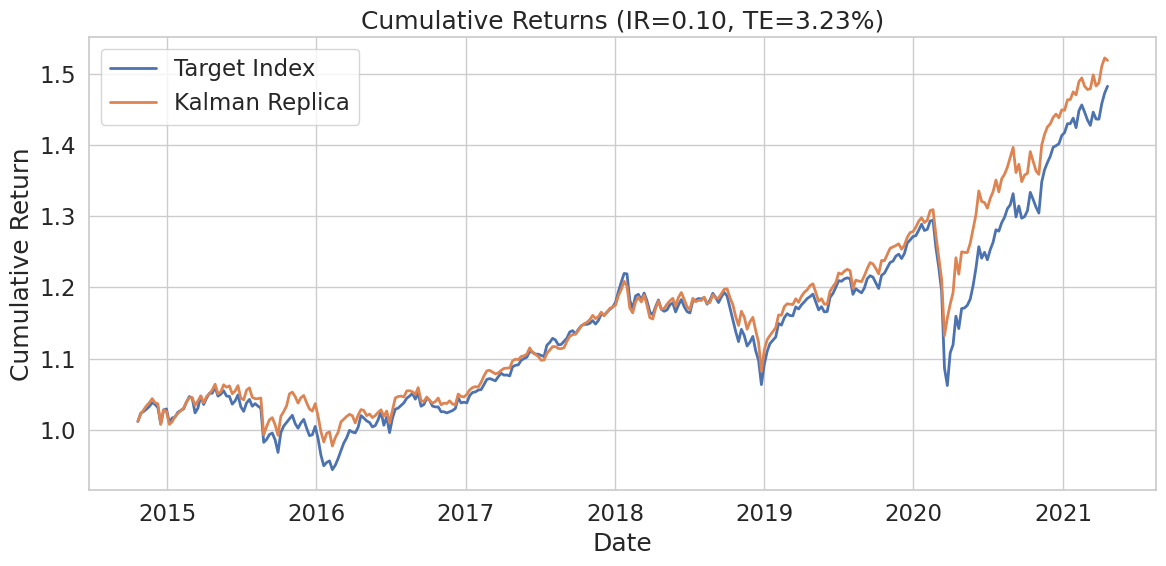

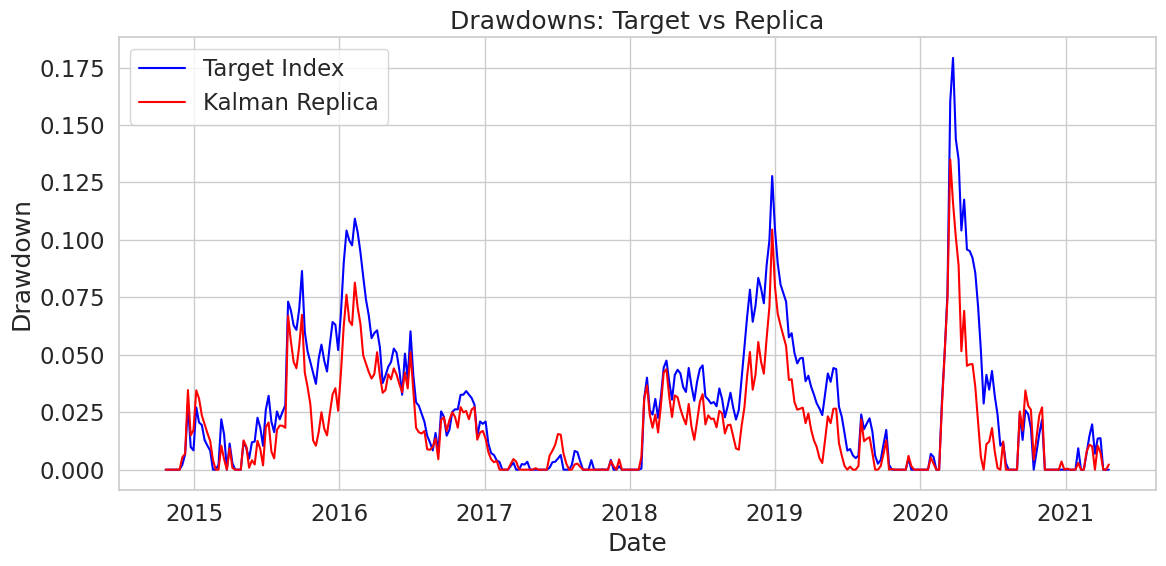

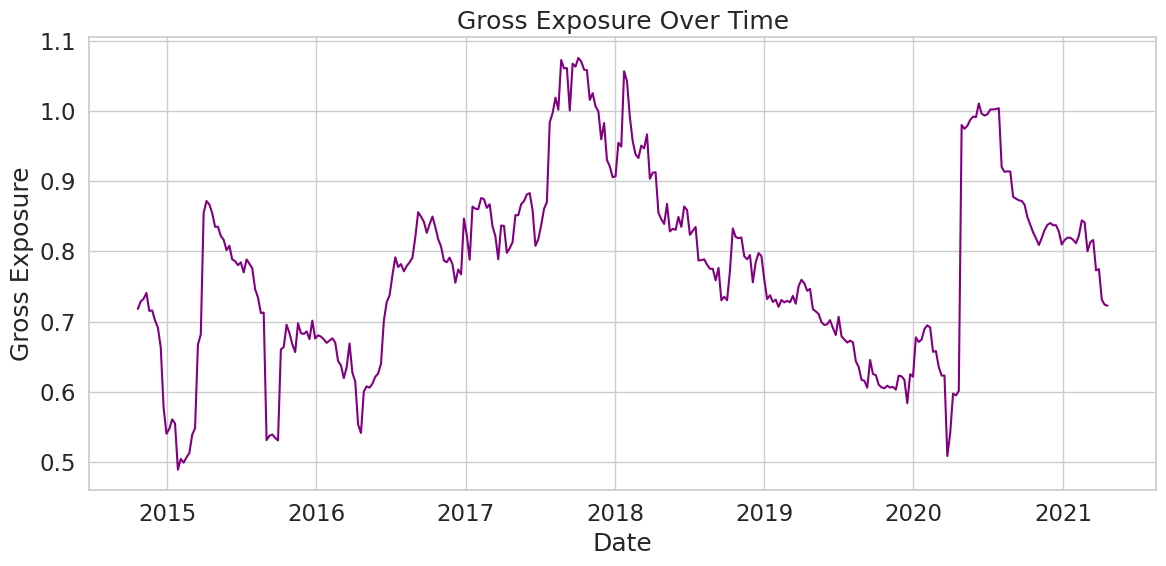

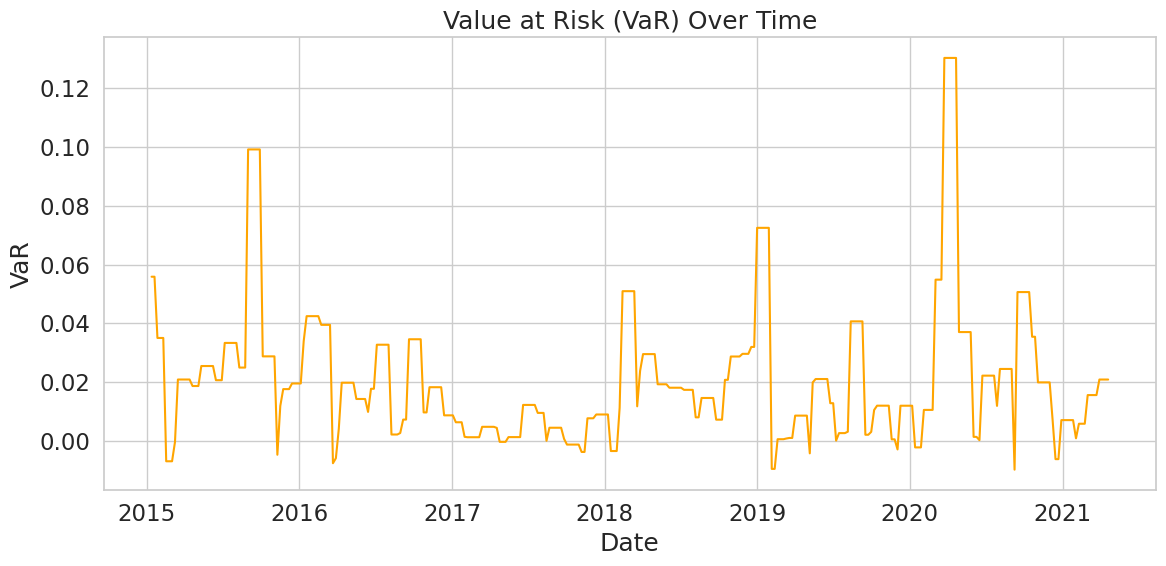

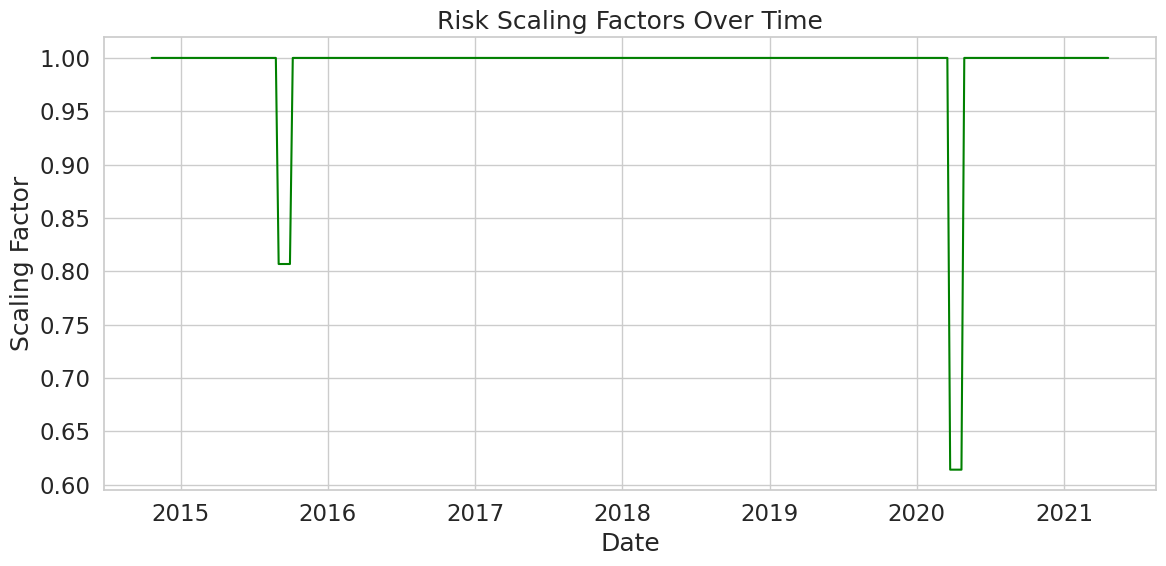

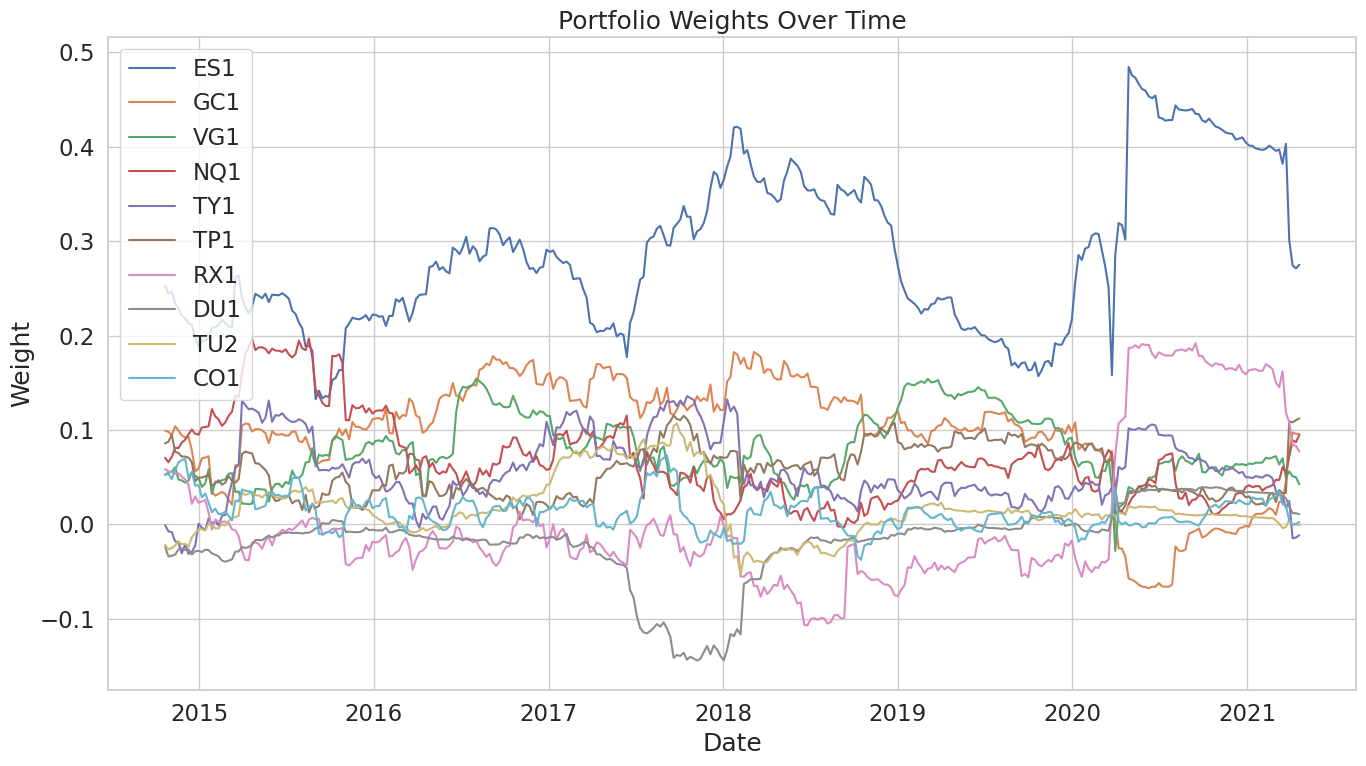

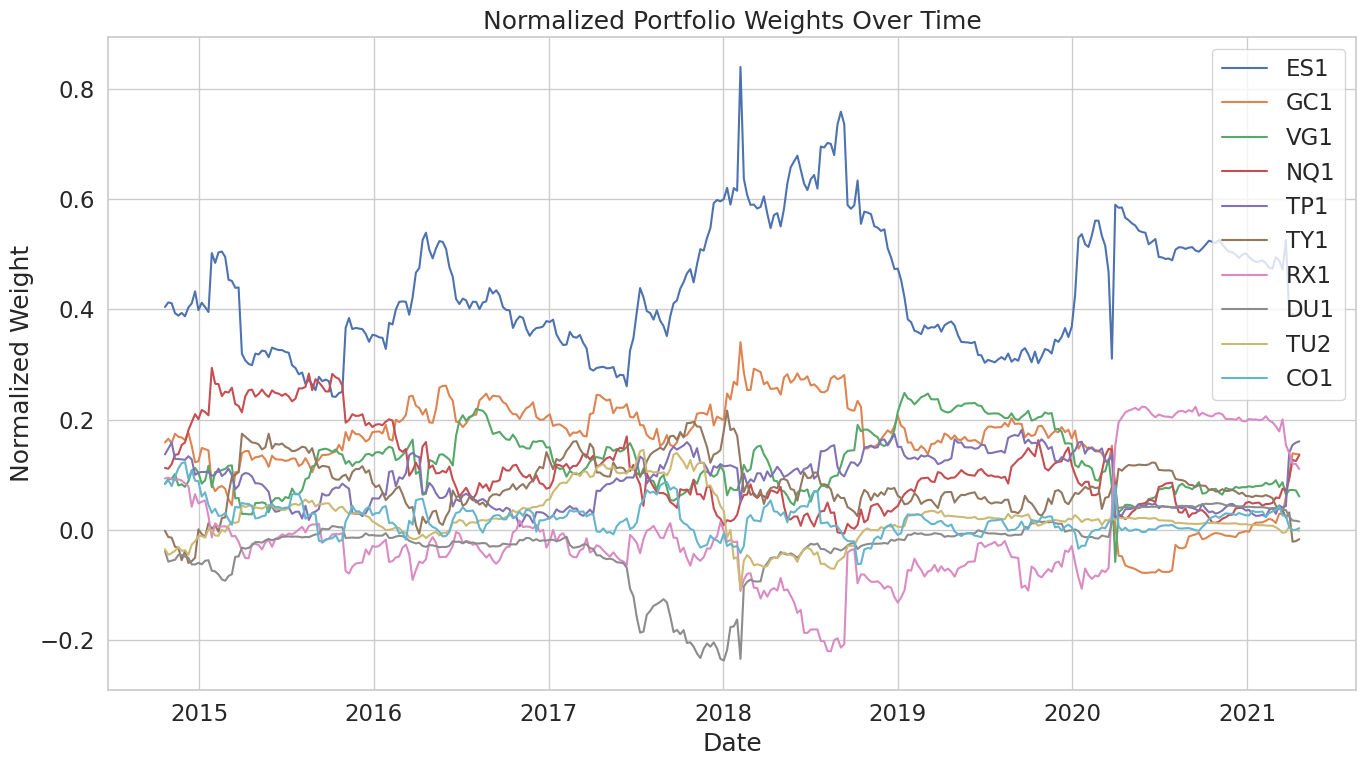

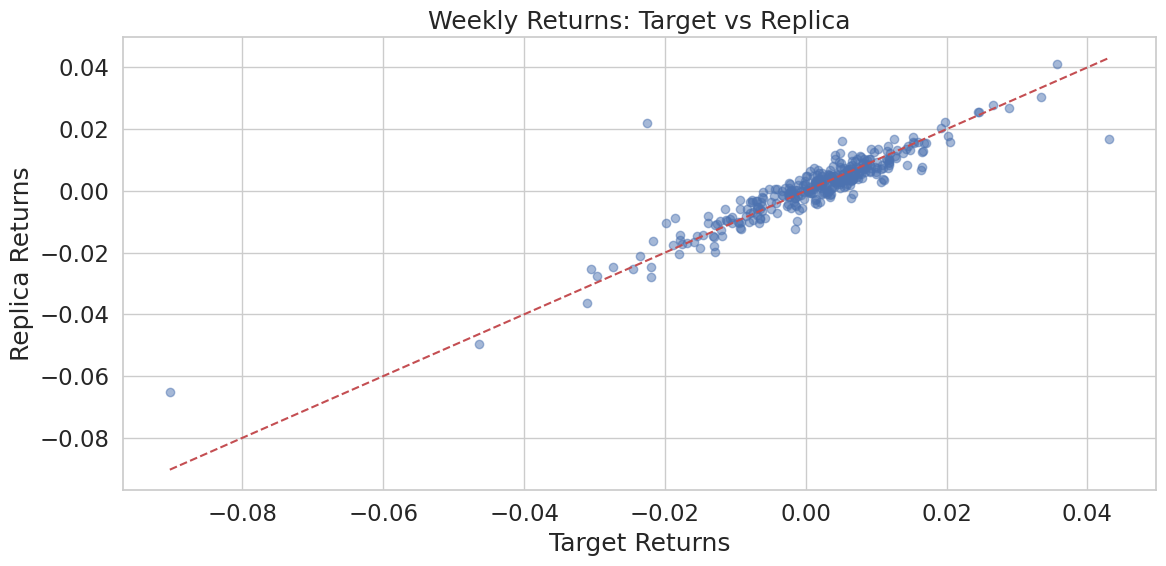

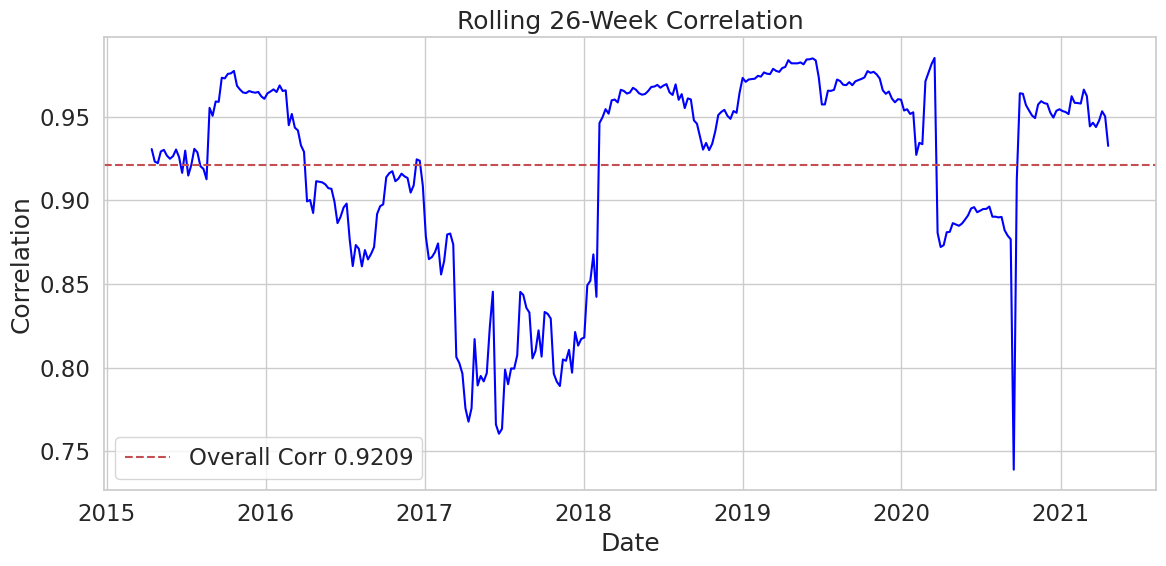


Metrics for Kalman Replica vs Target:


Metric  Target Replica
0       Annualized return   6.37%   6.69%
1   Annualized volatility   8.30%   7.68%
2            Sharpe ratio    0.77    0.87
3            Max Drawdown  13.50%  13.50%
4          Tracking Error     N/A   3.23%
5       Information ratio     N/A    0.10
6             Correlation     N/A  0.9209
7  Average gross exposure     N/A  0.7770
8    Average VaR (1%, 1M)     N/A   2.06%

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Run kalman filter
kf_res = run_kalman_normalized(
    rolling_window=rolling_window,
    start_test=7*52,
    transaction_cost_rate=0.0005,
    Q_scale=0.001
)

# Cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(kf_res['cumulative_target'], label='Target Index', linewidth=2)
plt.plot(kf_res['cumulative_replica'], label='Kalman Replica', linewidth=2)
plt.title(f"Cumulative Returns (IR={kf_res['information_ratio']:.2f}, TE={kf_res['tracking_error']*100:.2f}%)")
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Drawdowns
plt.figure(figsize=(12, 6))
target_dd = 1 - kf_res['cumulative_target'] / kf_res['cumulative_target'].cummax()
replica_dd = 1 - kf_res['cumulative_replica'] / kf_res['cumulative_replica'].cummax()
plt.plot(target_dd, label='Target Index', color='blue')
plt.plot(replica_dd, label='Kalman Replica', color='red')
plt.title('Drawdowns: Target vs Replica')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Gross Exposure
plt.figure(figsize=(12, 6))
plt.plot(pd.Series(kf_res['gross_exposures'], index=kf_res['replica_returns'].index), color='purple')
plt.title('Gross Exposure Over Time')
plt.xlabel('Date')
plt.ylabel('Gross Exposure')
plt.grid(True)
plt.tight_layout()
plt.show()

# Var
plt.figure(figsize=(12, 6))
plt.plot(pd.Series(kf_res['var_values'], index=kf_res['replica_returns'].index), color='orange')
# plt.axhline(y=max_var_threshold, color='r', linestyle='--', label='VaR Threshold')
plt.title('Value at Risk (VaR) Over Time')
plt.xlabel('Date')
plt.ylabel('VaR')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scaling factors
plt.figure(figsize=(12, 6))
plt.plot(pd.Series(kf_res['scaling_factors'], index=kf_res['replica_returns'].index), color='green')
plt.title('Risk Scaling Factors Over Time')
plt.xlabel('Date')
plt.ylabel('Scaling Factor')
plt.grid(True)
plt.tight_layout()
plt.show()

# Weights over time
weights_df = pd.DataFrame(
    kf_res['weights_history'],
    index=kf_res['replica_returns'].index,
    columns=futures_returns.columns  # *** use the true futures columns here ***
)

top_weights = weights_df.abs().mean().sort_values(ascending=False).head(11).index

plt.figure(figsize=(14, 8))
for col in top_weights:
    plt.plot(weights_df[col], label=col)
plt.title('Portfolio Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Normalized weights
normalized_df = weights_df.div(weights_df.sum(axis=1), axis=0)
top_norm = normalized_df.abs().mean().sort_values(ascending=False).head(11).index

plt.figure(figsize=(14, 8))
for col in top_norm:
    plt.plot(normalized_df[col], label=col)
plt.title('Normalized Portfolio Weights Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Weight')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Weekly returns scatter
plt.figure(figsize=(12, 6))
plt.scatter(kf_res['aligned_target'], kf_res['replica_returns'], alpha=0.5)
lims = [min(kf_res['aligned_target'].min(), kf_res['replica_returns'].min()),
        max(kf_res['aligned_target'].max(), kf_res['replica_returns'].max())]
plt.plot(lims, lims, 'r--')
plt.title('Weekly Returns: Target vs Replica')
plt.xlabel('Target Returns')
plt.ylabel('Replica Returns')
plt.grid(True)
plt.tight_layout()
plt.show()

# Rolling correlation
plt.figure(figsize=(12, 6))
rolling_corr = kf_res['replica_returns'].rolling(window=26).corr(kf_res['aligned_target'])
plt.plot(rolling_corr, color='blue')
plt.axhline(y=kf_res['correlation'], color='r', linestyle='--',
            label=f'Overall Corr {kf_res["correlation"]:.4f}')
plt.title('Rolling 26-Week Correlation')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display Kalman Filter performance metrics
metrics_df = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{kf_res['target_return']*100:.2f}%",
               f"{kf_res['target_vol']*100:.2f}%",
               f"{kf_res['target_sharpe']:.2f}",
               f"{kf_res['max_drawdown']*100:.2f}%",
               "N/A", "N/A", "N/A", "N/A", "N/A"],
    'Replica': [f"{kf_res['replica_return']*100:.2f}%",
                f"{kf_res['replica_vol']*100:.2f}%",
                f"{kf_res['replica_sharpe']:.2f}",
                f"{kf_res['max_drawdown']*100:.2f}%",
                f"{kf_res['tracking_error']*100:.2f}%",
                f"{kf_res['information_ratio']:.2f}",
                f"{kf_res['correlation']:.4f}",
                f"{kf_res['avg_gross_exposure']:.4f}",
                f"{kf_res['avg_var']*100:.2f}%"]
})
print("\nMetrics for Kalman Replica vs Target:")
display(metrics_df)


# **Territorial Exposure**

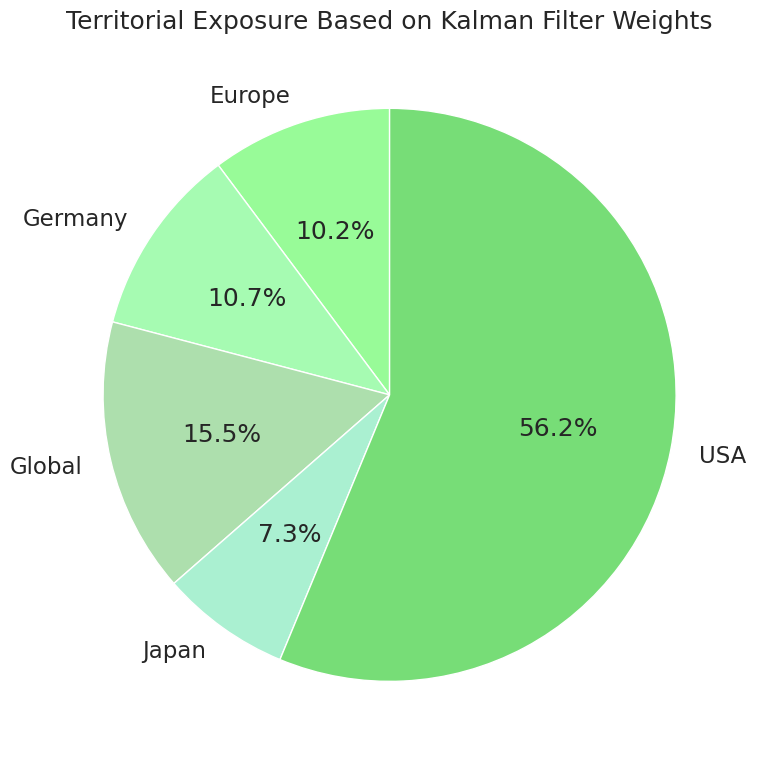

In [ ]:
import matplotlib.pyplot as plt

# Updated mapping: ticker → geographic region
region_map = {
    'MXWO Index': 'Global',
    'MXWD Index': 'Global',
    'LEGATRUU Index': 'Global',
    'HFRXGL Index': 'Global',
    'GC1': 'Global',
    'RX1': 'Germany',
    'CO1': 'Global',
    'DU1': 'Germany',
    'ES1': 'USA',
    'NQ1': 'USA',
    'TP1': 'Japan',
    'TU2': 'USA',
    'TY1': 'USA',
    'VG1': 'Europe',
    'LLL1': 'USA'
}

# Rename the columns of the weights dataframe with their corresponding regions
weights_df_region = weights_df.copy()
weights_df_region.columns = [region_map.get(col, 'Other') for col in weights_df.columns]

# Calculate the average absolute weights by region
avg_weights_by_region = weights_df_region.abs().mean().groupby(level=0).sum()

# Pastel green color palette
green_pastel_colors = ['#98FB98', '#A6FBB2', '#ADDFAD', '#AAF0D1', '#77DD77', '#C1E1C1']

# Ensure the number of colors matches the number of regions
colors_to_use = green_pastel_colors[:len(avg_weights_by_region)]

# Pie chart plot
plt.figure(figsize=(8, 8))
avg_weights_by_region.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    legend=False,
    colors=colors_to_use
)
plt.title('Territorial Exposure Based on Kalman Filter Weights')
plt.ylabel('')
plt.tight_layout()
plt.show()


# **Recurrent Neural Network**

 # 📈 RNN-based Portfolio Allocation with Sliding Windows

We implement a **Recurrent Neural Network (RNN)** model to replicate the returns of athe target index by dynamically adjusting portfolio weights. The method combines:

- A **rolling window** over historical asset returns with a **one-step-ahead** prediction
- A **two-input neural network** structure  

---

## ⚙️ Model Architecture

**Inputs:**

- `seq_input`: a matrix of shape $[T \times m]$, where $T$ is the time window and $m$ is the number of assets  
- `last_input`: a vector of shape $[m]$, containing the most recent return values

**Network Structure:**

- Two stacked `SimpleRNN` layers with `tanh` activation  
- Each RNN followed by `LayerNormalization` and `Dropout`  
- A `Dense(m)` layer outputs raw asset scores  
- A `Softmax` layer transforms scores into portfolio weights:

$$
w_i = \frac{e^{z_i}}{\sum_{j=1}^m e^{z_j}}
$$

- A `Dot` layer computes the predicted portfolio return:

$$
\hat{y}_t = \sum_{i=1}^m w_i \cdot x_{t,i}
$$

---

## 🔁 Sliding Window & Walk-Forward Learning

At each step $t$:

- Select $N$ training samples using a rolling window  
- Normalize the historical input features using `StandardScaler`  
- Retrain the model on the most recent data  
- Predict next asset weights $w_t$  
- Compute portfolio return with transaction costs:

$$
r_t = \mathbf{w}_t^\top \mathbf{x}_t - \gamma \cdot \left\| \mathbf{w}_t - \mathbf{w}_{t-1} \right\|_1
$$

- Apply return scaling if Value-at-Risk exceeds a defined threshold

We remark that we do not rescale the weights as we decide not to scale the most recent returns and the target value



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, Dropout, Dense, Softmax, LayerNormalization, Dot
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Fuction that runs Recurrent neural network
def run_rnn_normalized(
    neurons: int,
    batch_size: int,
    learning_rate: float,
    rolling_window: int,
    start_test: int = 365,
    end_test: int = None,
    train_samples: int = 100,
    var_confidence: float = 0.01,
    var_horizon: int = 4,
    max_var_threshold: float = 0.08,
    transaction_costs: bool = True
) -> dict:

    # Fuction to build the network's architecture
    def build_model(m):
        seq_in = Input(shape=(rolling_window, m), name='seq_input')
        last_in = Input(shape=(m,), name='last_input')
        x = SimpleRNN(neurons, return_sequences=True, activation='tanh')(seq_in)
        x = LayerNormalization()(x)
        x = Dropout(0.2)(x)
        x = SimpleRNN(neurons, activation='tanh')(x)
        x = LayerNormalization()(x)
        x = Dropout(0.2)(x)
        w = Dense(m)(x)
        w_norm = Softmax(name='weights')(w)
        y_pred = Dot(axes=1, name='pred_index')([w_norm, last_in])
        model = Model([seq_in, last_in], y_pred)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')
        return model

    end_idx = end_test if end_test is not None else len(X_values)

    # Initialize outputs and state
    replica_rets, gross_exposures, var_vals, scale_factors, weights_hist = [], [], [], [], []
    prev_w = np.zeros(X_values.shape[1])
    tc_rate = 0.0005 if transaction_costs else 0.0

    # Rolling window training loop
    for t in range(start_test, end_idx):
        X_train_seqs, X_last_vals, y_train_vals = [], [], []

        # Prepare training data
        for i in range(t - rolling_window - train_samples, t - rolling_window):

            # Past observations
            seq = X_values[i: i + rolling_window]

            # Last value of sequence
            last = X_values[i + rolling_window - 1]

            # Target value
            y = y_values[i + rolling_window]

            # Append
            X_train_seqs.append(seq)
            X_last_vals.append(last)
            y_train_vals.append(y)

        # Normalize training sequences
        scaler = StandardScaler().fit(np.vstack(X_train_seqs))
        X_train_seqs = np.array([scaler.transform(seq) for seq in X_train_seqs])
        X_last_vals = np.array(X_last_vals)
        y_train_vals = np.array(y_train_vals)

        # Build and train model
        model = build_model(m=X_values.shape[1])
        model.fit([X_train_seqs, X_last_vals], y_train_vals, epochs=5, batch_size=batch_size, verbose=0)

        # Predict weights for current day
        X_seq = scaler.transform(X_values[t - rolling_window: t]).reshape(1, rolling_window, -1)
        X_last = X_values[t - 1].reshape(1, -1)
        w = Model(model.inputs, model.get_layer('weights').output).predict([X_seq, X_last], verbose=0).ravel()
        weights_hist.append(w.copy())

        # Compute return with transaction costs
        ret = np.dot(w, X_values[t]) - np.sum(np.abs(w - prev_w)) * tc_rate
        prev_w = w

        # Risk adjustment via VaR scaling
        scale = 1.0
        if len(replica_rets) >= 12:
            hist = np.array(replica_rets[-52:])
            var_raw = -np.percentile(hist, var_confidence * 100) * np.sqrt(var_horizon)
            if var_raw > max_var_threshold:
                scale = max_var_threshold / var_raw
                ret *= scale
                var_raw = max_var_threshold
            var_vals.append(var_raw)
        else:
            var_vals.append(np.nan)

        scale_factors.append(scale)
        replica_rets.append(ret)
        gross_exposures.append(np.sum(np.abs(w)))

    # Evaluation metrics
    dates = dates_array[start_test:end_idx]
    replica_ser = pd.Series(replica_rets, index=dates)
    target_ser = pd.Series(y_values[start_test:end_idx], index=dates)
    freq = 52
    ann_rep = replica_ser.mean() * freq
    ann_tgt = target_ser.mean() * freq
    vol_rep = replica_ser.std() * np.sqrt(freq)
    vol_tgt = target_ser.std() * np.sqrt(freq)
    te = (replica_ser - target_ser).std() * np.sqrt(freq)
    ir = (ann_rep - ann_tgt) / te if te > 0 else np.nan
    corr = replica_ser.corr(target_ser)
    cum_rep = (1 + replica_ser).cumprod()
    max_dd = (1 - cum_rep / cum_rep.cummax()).max()
    avg_exp = np.mean(gross_exposures)
    avg_var = np.nanmean(var_vals)

    # Return results
    return {
        'replica_return': ann_rep,
        'target_return': ann_tgt,
        'replica_vol': vol_rep,
        'target_vol': vol_tgt,
        'replica_sharpe': ann_rep / vol_rep if vol_rep > 0 else np.nan,
        'target_sharpe': ann_tgt / vol_tgt if vol_tgt > 0 else np.nan,
        'tracking_error': te,
        'information_ratio': ir,
        'correlation': corr,
        'max_drawdown': max_dd,
        'avg_gross_exposure': avg_exp,
        'avg_var': avg_var,
        'replica_returns': replica_ser,
        'aligned_target': target_ser,
        'cumulative_replica': cum_rep,
        'cumulative_target': (1 + target_ser).cumprod(),
        'gross_exposures': gross_exposures,
        'var_values': var_vals,
        'scaling_factors': scale_factors,
        'weights_history': weights_hist,
        'X_last': X_last,
        'last_weights': weights_hist[-1]
    }



Metrics for Selected Pareto-Optimal RNN Configuration:


Metric  Target Replica
0       Annualized return  13.15%  -1.22%
1   Annualized volatility  11.70%  11.14%
2            Sharpe ratio    1.12   -0.11
3            Max Drawdown  16.99%  16.99%
4          Tracking Error     N/A   7.83%
5       Information ratio     N/A   -1.84
6             Correlation     N/A  0.7662
7  Average gross exposure     N/A  1.0000
8    Average VaR (1%, 1M)     N/A   6.86%

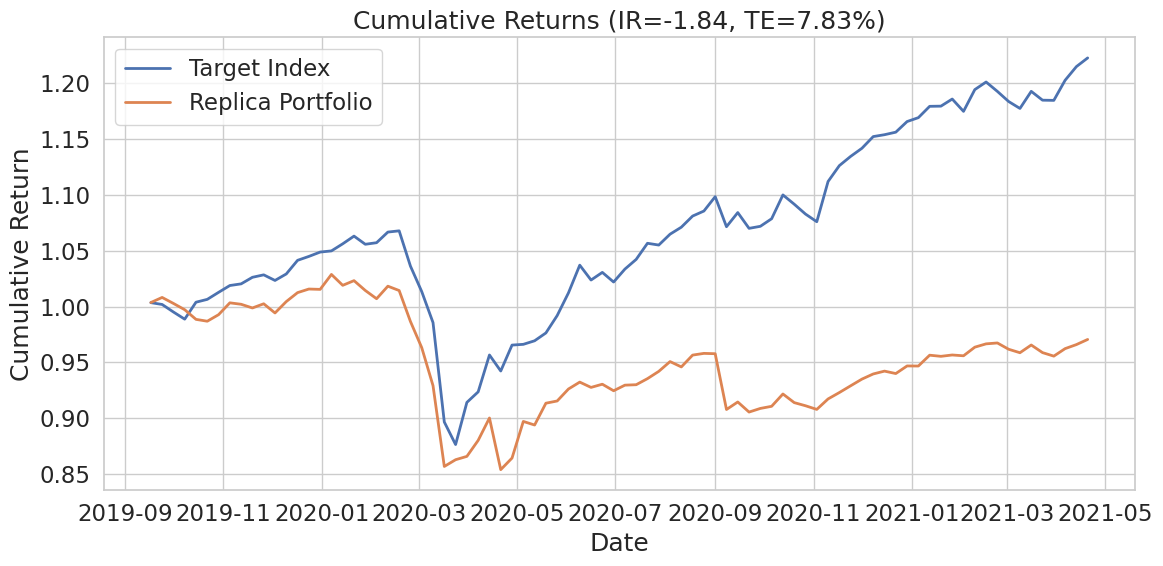

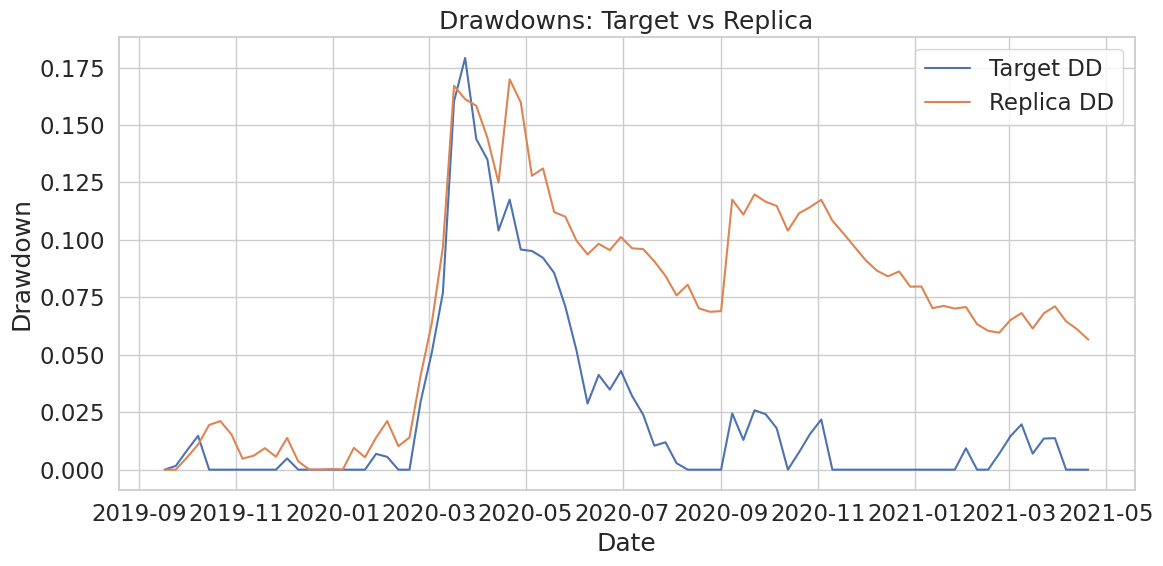

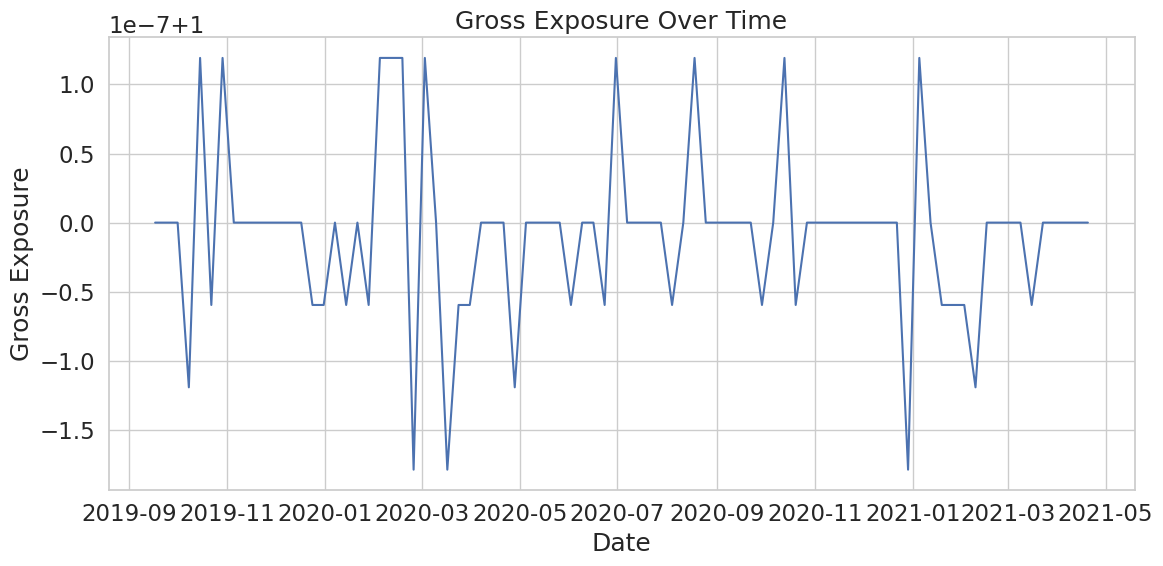

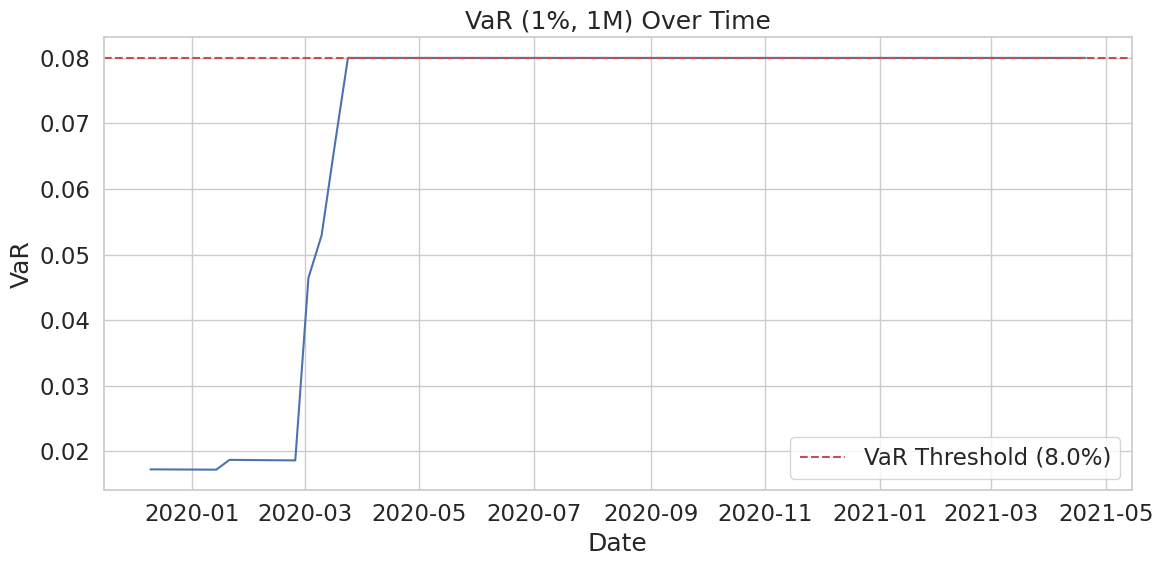

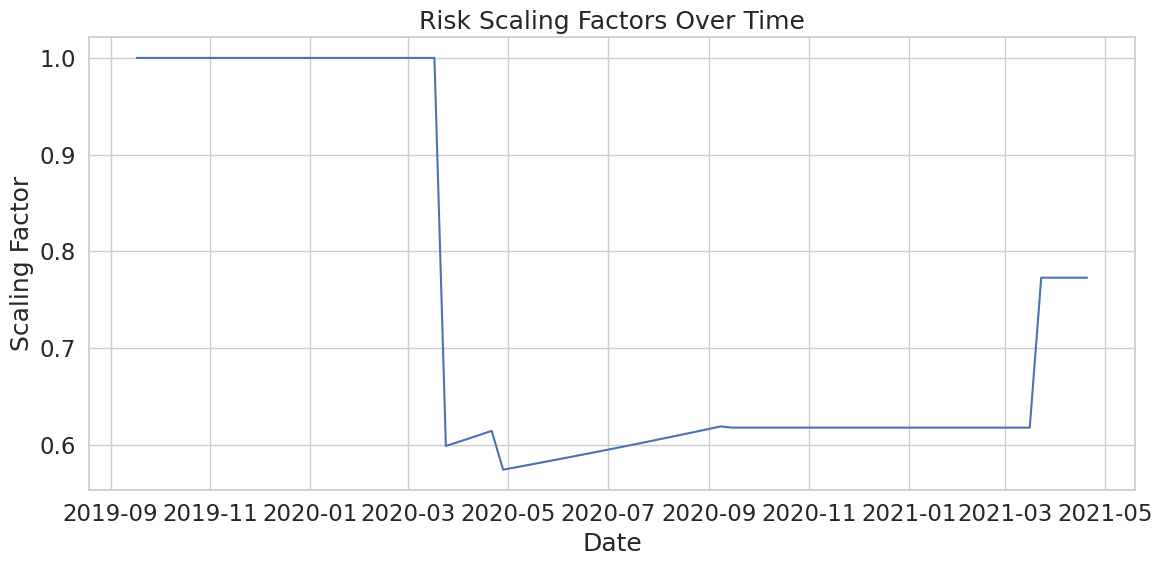

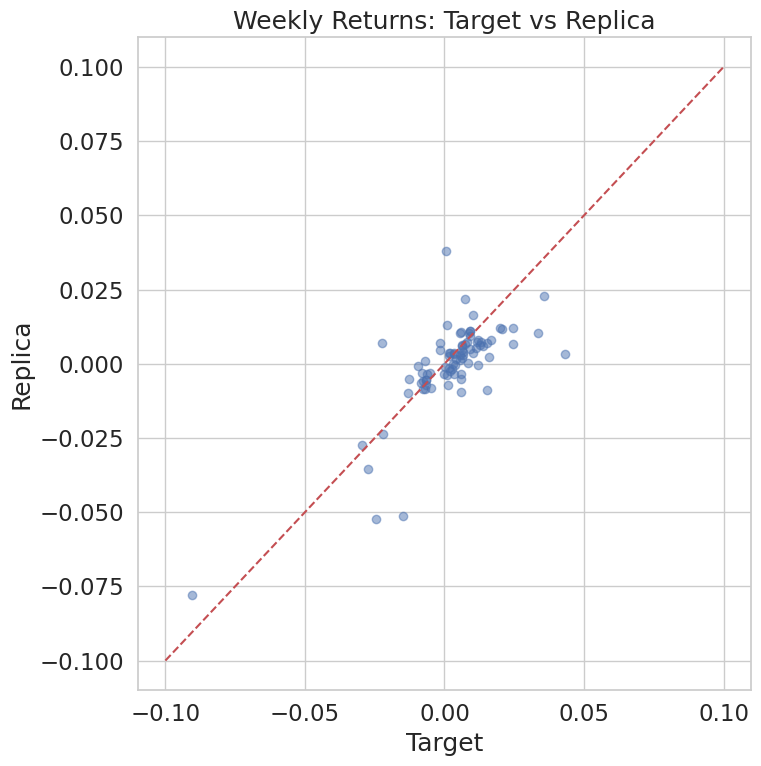

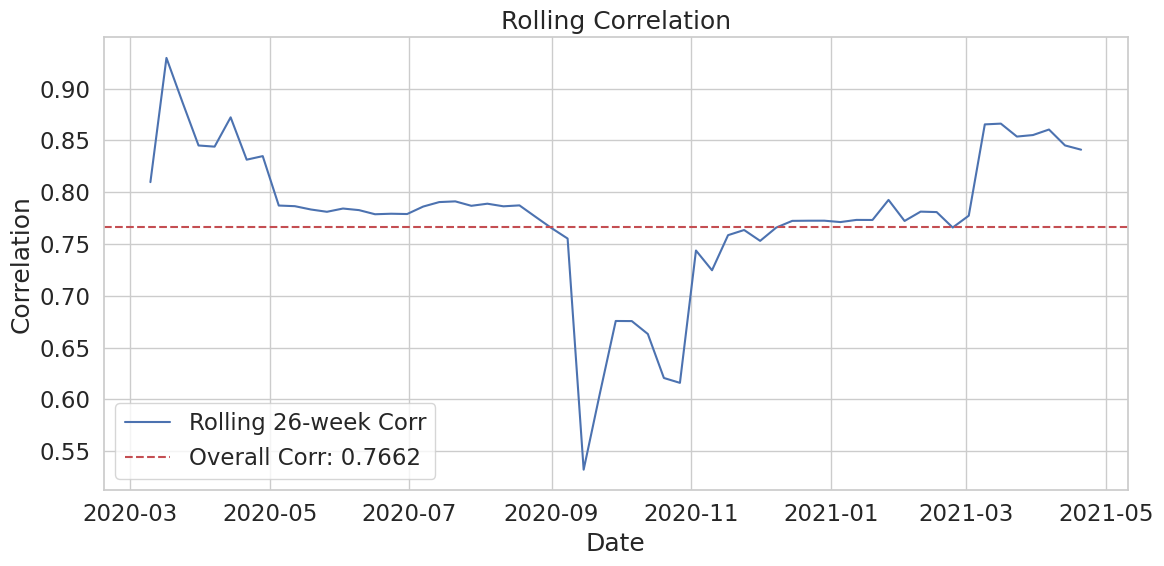

In [ ]:
# Final evaluation with transaction costs
nn_res = run_rnn_normalized(
    neurons=10,
    batch_size=32,
    learning_rate=0.001,
    rolling_window=52,
    start_test=620,
    end_test=None
)

# Display performance metrics
metrics_df = pd.DataFrame({
    'Metric': [
        'Annualized return', 'Annualized volatility', 'Sharpe ratio',
        'Max Drawdown', 'Tracking Error', 'Information ratio',
        'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'
    ],
    'Target': [
        f"{nn_res['target_return']*100:.2f}%",
        f"{nn_res['target_vol']*100:.2f}%",
        f"{nn_res['target_sharpe']:.2f}",
        f"{nn_res['max_drawdown']*100:.2f}%",
        "N/A", "N/A", "N/A", "N/A", "N/A"
    ],
    'Replica': [
        f"{nn_res['replica_return']*100:.2f}%",
        f"{nn_res['replica_vol']*100:.2f}%",
        f"{nn_res['replica_sharpe']:.2f}",
        f"{nn_res['max_drawdown']*100:.2f}%",
        f"{nn_res['tracking_error']*100:.2f}%",
        f"{nn_res['information_ratio']:.2f}",
        f"{nn_res['correlation']:.4f}",
        f"{nn_res['avg_gross_exposure']:.4f}",
        f"{nn_res['avg_var']*100:.2f}%"
    ]
})
print("\nMetrics for Selected Pareto-Optimal RNN Configuration:")
display(metrics_df)

# Cumulative returns
plt.figure(figsize=(12,6))
plt.plot(nn_res['cumulative_target'], label='Target Index', linewidth=2)
plt.plot(nn_res['cumulative_replica'], label='Replica Portfolio', linewidth=2)
plt.title(f"Cumulative Returns (IR={nn_res['information_ratio']:.2f}, TE={nn_res['tracking_error']*100:.2f}%)")
plt.xlabel("Date"); plt.ylabel("Cumulative Return")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Drawdowns
plt.figure(figsize=(12,6))
t_dd = 1 - nn_res['cumulative_target'] / nn_res['cumulative_target'].cummax()
r_dd = 1 - nn_res['cumulative_replica'] / nn_res['cumulative_replica'].cummax()
plt.plot(t_dd, label='Target DD'); plt.plot(r_dd, label='Replica DD')
plt.title("Drawdowns: Target vs Replica")
plt.xlabel("Date"); plt.ylabel("Drawdown")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Gross exposure over time
plt.figure(figsize=(12,6))
plt.plot(pd.Series(nn_res['gross_exposures'], index=nn_res['replica_returns'].index))
plt.title("Gross Exposure Over Time")
plt.xlabel("Date"); plt.ylabel("Gross Exposure")
plt.grid(True); plt.tight_layout(); plt.show()

# Value at Risk over time
plt.figure(figsize=(12,6))
plt.plot(pd.Series(nn_res['var_values'], index=nn_res['replica_returns'].index))
plt.axhline(y=0.08, color='r', linestyle='--', label="VaR Threshold (8.0%)")  # update threshold
plt.title("VaR (1%, 1M) Over Time")
plt.xlabel("Date"); plt.ylabel("VaR")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Scaling factors over time
plt.figure(figsize=(12,6))
plt.plot(pd.Series(nn_res['scaling_factors'], index=nn_res['replica_returns'].index))
plt.title("Risk Scaling Factors Over Time")
plt.xlabel("Date"); plt.ylabel("Scaling Factor")
plt.grid(True); plt.tight_layout(); plt.show()

# Weekly returns scatter
plt.figure(figsize=(8,8))
plt.scatter(nn_res['aligned_target'], nn_res['replica_returns'], alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], 'r--')
plt.title("Weekly Returns: Target vs Replica")
plt.xlabel("Target"); plt.ylabel("Replica")
plt.grid(True); plt.tight_layout(); plt.show()

# Rolling correlation
plt.figure(figsize=(12,6))
roc = nn_res['replica_returns'].rolling(window=26).corr(nn_res['aligned_target'])
plt.plot(roc, label='Rolling 26-week Corr')
plt.axhline(nn_res['correlation'], color='r', linestyle='--',
            label=f"Overall Corr: {nn_res['correlation']:.4f}")
plt.title("Rolling Correlation")
plt.xlabel("Date"); plt.ylabel("Correlation")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


# **LIME**

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 18.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e36833526ff77006e7b09093449933e550e6ea0110c5ee2aaf979058e7ec2bc7
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
Intercept 0.1055763058367217
Prediction_local [0.0924719]
Right: 0.10256074124605291


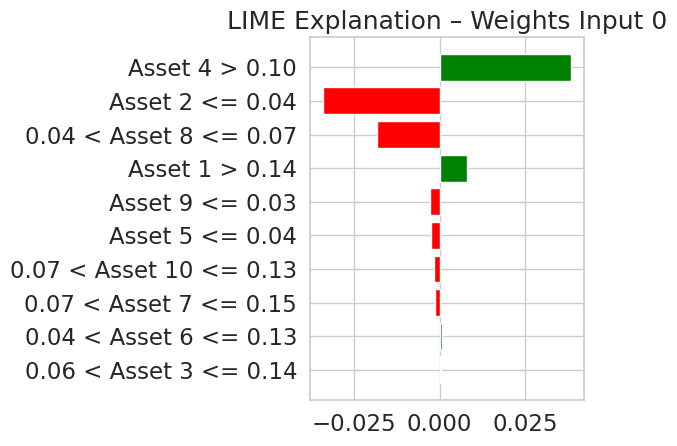

In [ ]:
!pip install lime

from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import matplotlib.pyplot as plt

# Get the last 10 portfolio weights as input
X_last_all = np.array(nn_res['weights_history'][-50:])
last_weights = np.array(nn_res['last_weights']).reshape(1, -1)

# Define surrogate prediction model
def surrogate_model(x):
    return np.sum(x * last_weights, axis=1).reshape(-1, 1)

# Initialize LIME Explainer
explainer = LimeTabularExplainer(
    training_data=X_last_all,
    mode='regression',
    feature_names=[f"Asset {i+1}" for i in range(X_last_all.shape[1])],
    verbose=True,
    random_state=42
)

# Explain a single instance (index 0)
idx = 0
explanation = explainer.explain_instance(
    data_row=X_last_all[idx],
    predict_fn=surrogate_model,
    num_features=X_last_all.shape[1]
)

# Bar chart
explanation.as_pyplot_figure()
plt.title(f"LIME Explanation – Weights Input {idx}")
plt.tight_layout()
plt.show()

# **SHAP**

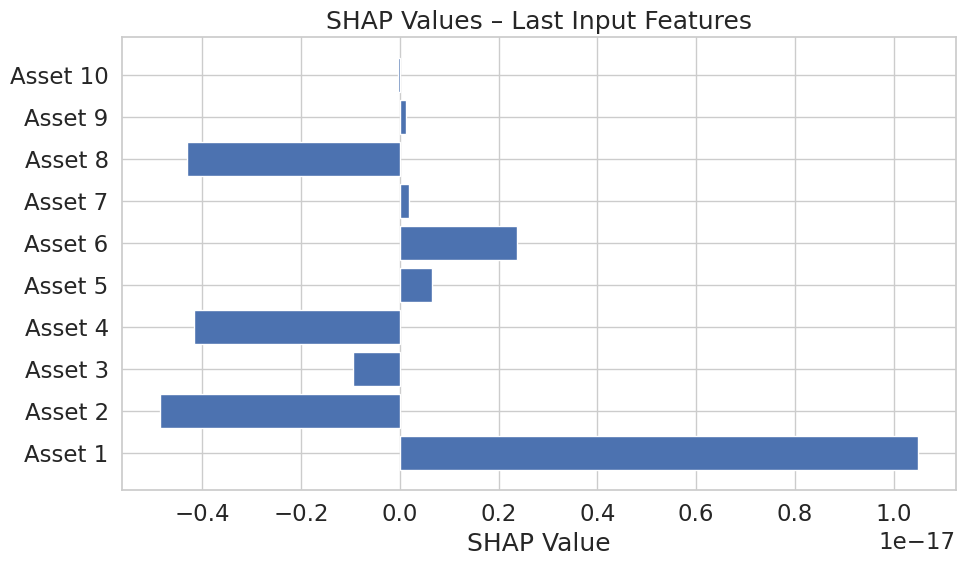

In [ ]:
# Shapley Value
import shap

# Last RNN previsions
X_last_all = np.array(nn_res['weights_history'][-50:])
last_weights = np.array(nn_res['last_weights']).reshape(1, -1)

# Surrogate linear model
def surrogate_model(x):
    return np.sum(x * last_weights, axis=1).reshape(-1, 1)

# Shap Values computation
explainer = shap.Explainer(surrogate_model, X_last_all)
shap_vals = explainer(X_last_all)
mean_shap = np.mean(shap_vals.values, axis=0)
nn_res['shap_last_input'] = mean_shap

# SHAP Values for Last Prediction
plt.figure(figsize=(10,6))
plt.barh([f"Asset {i+1}" for i in range(len(nn_res['shap_last_input']))],
         nn_res['shap_last_input'])
plt.title("SHAP Values – Last Input Features")
plt.xlabel("SHAP Value")
plt.grid(True); plt.tight_layout(); plt.show()

# **Ensemble Model**

\# 📊 Ensemble Model: Kalman + Optuna + Neural Network

We start with the idea of constructing an **ensemble portfolio** by combining three distinct replication strategies:

- 🔄 **Kalman Filter** (adaptive, state-space model)
- 🧪 **Elastic Net** (hyperparameter-tuned)
- 🧠 **Neural Network** (non-linear, data-driven model)

Each model provides its own version of **replica returns**, which are aligned over a common time index before combination.

However, eventually we do not considered the RNN because the results are not so good. It would be possible to see what happens by increasing the model complexity or calibrating the hyperparameters, but the computational time would increase a lot.



# 🧮 Ensemble Weight Calibration via Tracking Error Minimization (EN + KF)

To build a robust ensemble portfolio that combines the two individual strategies — ElasticNet ($r_{en}$) and Kalman Filter ($r_{kf}$) — we define a convex combination of their weekly returns:

$$
r_{\text{ensemble}} = \lambda_{\text{EN}} \cdot r_{en} + \lambda_{\text{KF}} \cdot r_{kf}, \quad \text{subject to} \quad \lambda_{\text{EN}} + \lambda_{\text{KF}} = 1
$$

---

### 🎯 Calibration Objective

The goal is to determine the weights $\lambda_{\text{EN}}, \lambda_{\text{KF}}$ that minimize the tracking error (TE) over a 52-week calibration window.

Tracking error is computed as:

$$
\text{TE} = \sqrt{52} \cdot \text{std}(r_{\text{ensemble}} - r_{\text{target}})
$$

A grid search is performed on $(\lambda_{\text{EN}}, \lambda_{\text{KF}})$ with step size 0.05 over the admissible simplex.

---

### 🗳️ Rank-Based Selection

- All combinations are ranked in ascending order by tracking error.
- The pair with the **lowest TE** is selected as optimal.

This ensures transparency and avoids overfitting.

---

### 📈 Out-of-Sample Performance Evaluation

Once calibrated, the weights are applied to the out-of-sample period to compute:

$$
r_{\text{ensemble}}^{\text{OOS}} = \lambda_{\text{EN}} \cdot r_{en}^{\text{OOS}} + \lambda_{\text{KF}} \cdot r_{kf}^{\text{OOS}}
$$

Then, the following metrics are computed:

- **Annualized Return**
- **Annualized Volatility**
- **Sharpe Ratio**
- **Tracking Error**
- **Information Ratio**
- **Correlation with Target**
- **Cumulative Performance**

---

This methodology provides an interpretable and effective way to combine signals with minimal deviation from the benchmark.


Calibrated weights (excluding Neural Network):
  ElasticNet: 0.15
  Kalman:     0.85

Out-of-Sample Ensemble Performance (EN + KF only):
Annualized Return:      8.22%
Annualized Volatility:  7.17%
Sharpe Ratio:           1.15
Tracking Error:         3.33%
Information Ratio:      -0.03
Correlation:            0.9211


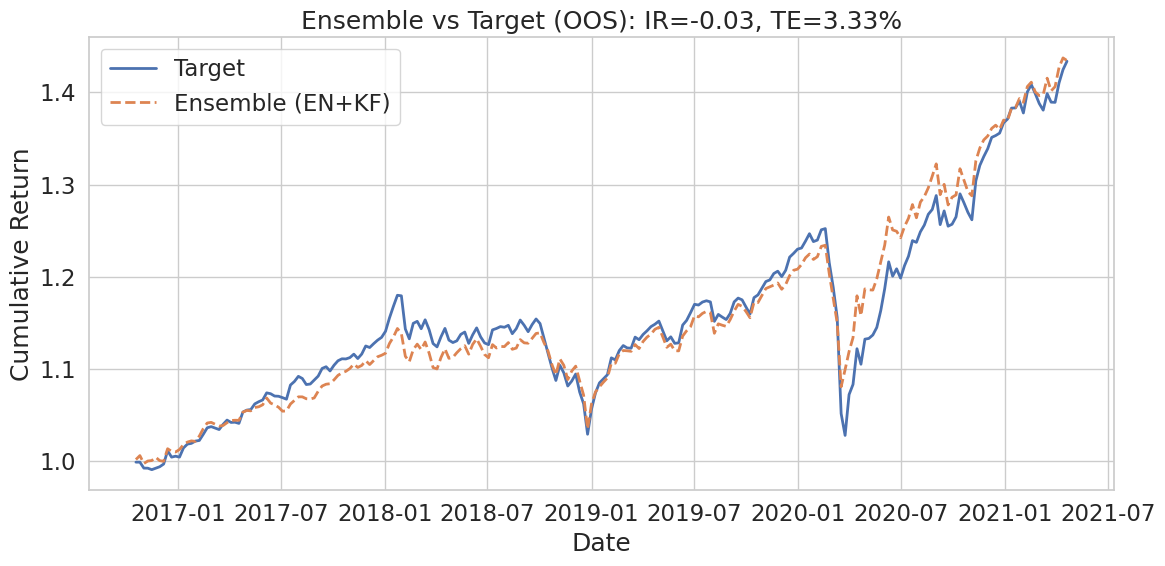


Metrics for Ensemble (EN + KF) vs Target:


Metric  Target Ensemble
0       Annualized return   6.37%    8.22%
1   Annualized volatility   8.30%    7.17%
2            Sharpe ratio    0.77     1.15
3            Max Drawdown  13.50%   13.50%
4          Tracking Error     N/A    3.33%
5       Information ratio     N/A    -0.03
6             Correlation     N/A   0.9211
7  Average gross exposure     N/A      N/A
8    Average VaR (1%, 1M)     N/A      N/A

Ensemble future weights:
RX1 --> 0.065566
TY1 --> -0.009756
GC1 --> 0.081312
CO1 --> 0.002029
ES1 --> 0.281720
VG1 --> 0.036103
NQ1 --> 0.080437
TP1 --> 0.095376
DU1 --> 0.009152
TU2 --> -0.000760


In [ ]:
# Prepare aligned series
r_en = en_res['replica_returns']
r_kf = kf_res['replica_returns']
aligned_target = en_res['aligned_target']

# Force all indexes to datetime and align formats
for series in [r_en, r_kf, aligned_target]:
    series.index = pd.to_datetime(series.index)

# Calibration period (first 52 weeks)
calib_idx = aligned_target.index[:52]
common_calib_idx = calib_idx.intersection(r_en.index).intersection(r_kf.index)

# Slice with guaranteed matching dates
x_en = r_en.reindex(common_calib_idx)
x_kf = r_kf.reindex(common_calib_idx)
y_t  = aligned_target.reindex(common_calib_idx)

# λ grid search (only EN and KF, λ_nn = 0)
step = 0.05
grid = [
    (λ_en, 1 - λ_en)
    for λ_en in np.arange(0, 1 + step, step)
]

def score_weights(λ_en, λ_kf):
    r_ens = λ_en * x_en + λ_kf * x_kf
    ann = r_ens.mean() * 52
    vol = r_ens.std() * np.sqrt(52)
    sharpe = ann / vol if vol > 0 else 0
    te = (r_ens - y_t).std() * np.sqrt(52)
    return ann, sharpe, te

results = []
for λ_en, λ_kf in grid:
    ann, sharpe, te = score_weights(λ_en, λ_kf)
    results.append({
        'λ_en': λ_en, 'λ_kf': λ_kf,
        'tracking_error': te
    })

df = pd.DataFrame(results)
df['r_te'] = df['tracking_error'].rank(ascending=True)
df['score'] = df['r_te']

best = df.sort_values('score').iloc[0]
λ_en, λ_kf = best[['λ_en', 'λ_kf']].values

print("Calibrated weights (excluding Neural Network):")
print(f"  ElasticNet: {λ_en:.2f}")
print(f"  Kalman:     {λ_kf:.2f}")

# Out-of-sample test
test_idx = aligned_target.index[52:]
common_test_idx = test_idx.intersection(r_en.index).intersection(r_kf.index)

e_en = r_en.reindex(common_test_idx)
e_kf = r_kf.reindex(common_test_idx)
y_test = aligned_target.reindex(common_test_idx)

r_ensemble = λ_en * e_en + λ_kf * e_kf

# Compute performance
ann_ens = r_ensemble.mean() * 52
vol_ens = r_ensemble.std() * np.sqrt(52)
sharpe_ens = ann_ens / vol_ens if vol_ens > 0 else np.nan
te_ens = (r_ensemble - y_test).std() * np.sqrt(52)
ir_ens = (ann_ens - y_test.mean() * 52) / te_ens if te_ens > 0 else np.nan
corr_ens = r_ensemble.corr(y_test)
cum_ens = (1 + r_ensemble).cumprod()
cum_tgt = (1 + y_test).cumprod()

print("\nOut-of-Sample Ensemble Performance (EN + KF only):")
print(f"Annualized Return:      {ann_ens*100:.2f}%")
print(f"Annualized Volatility:  {vol_ens*100:.2f}%")
print(f"Sharpe Ratio:           {sharpe_ens:.2f}")
print(f"Tracking Error:         {te_ens*100:.2f}%")
print(f"Information Ratio:      {ir_ens:.2f}")
print(f"Correlation:            {corr_ens:.4f}")

# Plot
plt.figure(figsize=(12,6))
plt.plot(cum_tgt, label='Target', linewidth=2)
plt.plot(cum_ens, label='Ensemble (EN+KF)', linestyle='--', linewidth=2)
plt.title(f'Ensemble vs Target (OOS): IR={ir_ens:.2f}, TE={te_ens*100:.2f}%')
plt.xlabel('Date'); plt.ylabel('Cumulative Return')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Display Ensemble (EN + KF) performance metrics
ensemble_metrics_df = pd.DataFrame({
    'Metric': ['Annualized return', 'Annualized volatility', 'Sharpe ratio',
               'Max Drawdown', 'Tracking Error', 'Information ratio',
               'Correlation', 'Average gross exposure', 'Average VaR (1%, 1M)'],
    'Target': [f"{kf_res['target_return']*100:.2f}%",
               f"{kf_res['target_vol']*100:.2f}%",
               f"{kf_res['target_sharpe']:.2f}",
               f"{kf_res['max_drawdown']*100:.2f}%",
               "N/A", "N/A", "N/A", "N/A", "N/A"],
    'Ensemble': [f"{ann_ens*100:.2f}%",
                 f"{vol_ens*100:.2f}%",
                 f"{sharpe_ens:.2f}",
                 f"{kf_res['max_drawdown']*100:.2f}%",
                 f"{te_ens*100:.2f}%",
                 f"{ir_ens:.2f}",
                 f"{corr_ens:.4f}",
                 "N/A",
                 "N/A"]
})
print("\nMetrics for Ensemble (EN + KF) vs Target:")
display(ensemble_metrics_df)


# Retrieve the last weight vectors
en_last_weights = np.array(en_res['weights_history'][-1])
kf_last_weights = np.array(kf_res['weights_history'][-1])

# Combine them using the calibrated ensemble weights
ensemble_weights = λ_en * en_last_weights + λ_kf * kf_last_weights
